In [2]:
import sys, pathlib, pandas as pd, numpy as np
root = pathlib.Path().resolve()
sys.path.append(str(root / "src"))

from src.utils import set_seeds
set_seeds(seed=42, num_threads=4)

from src.tcn import tcn_regressor, tcn_backbone
from src.window import split_xy, fit_scaler_on_train, transform, make_sequences
from src.loop import train_one_city_cpu, retrain_on_train_valid_cpu
from src.metrics import rmse, mae, r2

In [3]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month']       = df['date'].dt.month
    df['is_weekend']  = df['day_of_week'].isin([5, 6]).astype(int)
    return df
def add_seasonality_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month']       = df['date'].dt.month
    df['is_weekend']  = df['day_of_week'].isin([5, 6]).astype(int)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365.25)
    return df


In [4]:
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from src.window import fit_scaler_on_train, transform, make_sequences

data_dir = Path("Datasets") / "Train_Valid_Test"
lookback = 30     # start with 30; you can try 45/60 later

def load_city(name: str):
    tr = pd.read_csv(data_dir / f"{name}_train_imp.csv", parse_dates=["date"])
    va = pd.read_csv(data_dir / f"{name}_valid_imp.csv", parse_dates=["date"])
    te = pd.read_csv(data_dir / f"{name}_test_imp.csv",  parse_dates=["date"])
    return tr, va, te

excluded_cols = ["date", "city_lat", "city_lon"]

def prepare_city(name: str, variant: str):
    """variant ∈ {'calendar', 'seasonality'}"""
    df_tr, df_va, df_te = load_city(name)

    if variant == "calendar":
        df_tr, df_va, df_te = map(add_calendar_features, (df_tr, df_va, df_te))
    elif variant == "seasonality":
        df_tr, df_va, df_te = map(add_seasonality_features, (df_tr, df_va, df_te))


    feature_cols = [c for c in df_tr.columns if c not in excluded_cols]
    # fit scaler on TRAIN features only; transform all splits
    scaler = fit_scaler_on_train(df_tr, feature_cols)
    xtr_df, ytr = transform(df_tr, scaler, feature_cols)
    xva_df, yva = transform(df_va, scaler, feature_cols)
    xte_df, yte = transform(df_te, scaler, feature_cols)

    # build (n, L, d) windows and (n,)
    xtr, ytr = make_sequences(xtr_df, ytr, lookback)
    xva, yva = make_sequences(xva_df, yva, lookback)
    xte, yte = make_sequences(xte_df, yte, lookback)
    return (xtr, ytr, xva, yva, xte, yte, feature_cols)


In [5]:
from src.tcn import tcn_regressor
from src.loop import train_one_city_cpu
import pandas as pd

# modest regularisation; you can tweak later
hidden_channels = 64
num_blocks      = 5
kernel_size     = 4
dropout_rate    = 0.20

learning_rate   = 1.5e-3
batch_size      = 16
max_epochs      = 90
patience_epochs = 12

def fit_city_tuple(city_tuple):
    xtr, ytr, xva, yva, xte, yte, feat_cols = city_tuple
    model = tcn_regressor(in_ch=xtr.shape[-1], hid=hidden_channels,
                          n_blocks=num_blocks, k=kernel_size, dropout=dropout_rate)
    out = train_one_city_cpu(model, xtr, ytr, xva, yva,
                             lr=learning_rate, batch_size=batch_size,
                             max_epochs=max_epochs, patience=patience_epochs, seed=42)
    return out, (xtr, ytr, xva, yva, xte, yte, feat_cols)

# ---- Experiment A: Calendar only ----
abj_cal = prepare_city("Abuja",     variant="calendar")
che_cal = prepare_city("Chennai",   variant="calendar")
ndl_cal = prepare_city("NewDelhi",  variant="calendar")

val_cal = {}
val_cal["Abuja"],   abj_cal_data = fit_city_tuple(abj_cal)
val_cal["Chennai"], che_cal_data = fit_city_tuple(che_cal)
val_cal["NewDelhi"],ndl_cal_data = fit_city_tuple(ndl_cal)

val_cal_table = (pd.DataFrame(val_cal)
                   .T.drop(columns=["model"])
                   .loc[:, ["valid_rmse","valid_mae","valid_r2"]])
print("Validation — Calendar features only")
display(val_cal_table)


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Validation — Calendar features only


valid_rmse  valid_mae  valid_r2
Abuja     21.074852  13.487962  0.695956
Chennai    8.011538   5.917175  0.481921
NewDelhi  32.922066  25.400927   0.15075

In [6]:
#Seasonality 
abj_sea = prepare_city("Abuja",     variant="seasonality")
che_sea = prepare_city("Chennai",   variant="seasonality")
ndl_sea = prepare_city("NewDelhi",  variant="seasonality")

val_sea = {}
val_sea["Abuja"],   abj_sea_data = fit_city_tuple(abj_sea)
val_sea["Chennai"], che_sea_data = fit_city_tuple(che_sea)
val_sea["NewDelhi"],ndl_sea_data = fit_city_tuple(ndl_sea)

val_sea_table = (pd.DataFrame(val_sea)
                   .T.drop(columns=["model"])
                   .loc[:, ["valid_rmse","valid_mae","valid_r2"]])
print("Validation — Seasonality (calendar + dayofyear sin/cos)")
display(val_sea_table)

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Validation — Seasonality (calendar + dayofyear sin/cos)


valid_rmse  valid_mae  valid_r2
Abuja     21.512686  12.714424  0.683191
Chennai    7.447953   5.606917  0.552247
NewDelhi  29.696962  22.747818  0.308988

In [7]:
import os, itertools, pandas as pd
from pathlib import Path
from src.tcn import tcn_regressor
from src.loop import train_one_city_cpu

results_dir = Path("figures")
results_dir.mkdir(parents=True, exist_ok=True)

def evaluate_city_calendar_fast(city_name,
                                lookback_values=(30, 45),
                                hidden_values=(64,),           # single value to cut runtime
                                block_values=(4,),              # single value
                                kernel_values=(3, 5),
                                dropout_values=(0.15, 0.25),
                                learning_rate=2e-3,
                                batch_size=32,                  # bigger batch → faster on CPU
                                max_epochs=60,                  # fewer epochs
                                patience=6,                     # tighter early stop
                                seed=42):
    rows = []
    config_index = 0

    for lookback_value in lookback_values:
        # make sure prepare_city reads the updated global lookback
        global lookback
        lookback = lookback_value

        x_train, y_train, x_valid, y_valid, x_test, y_test, feature_cols = prepare_city(city_name, variant="calendar")

        for hidden_channels, num_blocks, kernel_size, dropout_rate in itertools.product(
            hidden_values, block_values, kernel_values, dropout_values
        ):
            config_index += 1
            print(f"[{city_name}] #{config_index}  lb={lookback_value}  hid={hidden_channels}  "
                  f"blocks={num_blocks}  k={kernel_size}  drop={dropout_rate}")

            model = tcn_regressor(
                in_ch=x_train.shape[-1],
                hid=hidden_channels,
                n_blocks=num_blocks,
                k=kernel_size,
                dropout=dropout_rate
            )

            result = train_one_city_cpu(
                model,
                x_train, y_train,
                x_valid, y_valid,
                lr=learning_rate,
                batch_size=batch_size,
                max_epochs=max_epochs,
                patience=patience,
                seed=seed
            )

            rows.append({
                "city": city_name,
                "lookback": lookback_value,
                "hidden_channels": hidden_channels,
                "num_blocks": num_blocks,
                "kernel_size": kernel_size,
                "dropout_rate": dropout_rate,
                "valid_rmse": result["valid_rmse"],
                "valid_mae":  result["valid_mae"],
                "valid_r2":   result["valid_r2"]
            })

            # save incremental progress
            pd.DataFrame(rows).to_csv(results_dir / f"tcn_valgrid_{city_name}.csv", index=False)

    table = pd.DataFrame(rows).sort_values("valid_rmse").reset_index(drop=True)
    return table

# run fast sweeps per city
table_abuja    = evaluate_city_calendar_fast("Abuja")
table_chennai  = evaluate_city_calendar_fast("Chennai")
table_newdelhi = evaluate_city_calendar_fast("NewDelhi")

print("Abuja — top 5")
display(table_abuja.head(5)[["lookback","hidden_channels","num_blocks","kernel_size","dropout_rate","valid_rmse","valid_mae","valid_r2"]])

print("Chennai — top 5")
display(table_chennai.head(5)[["lookback","hidden_channels","num_blocks","kernel_size","dropout_rate","valid_rmse","valid_mae","valid_r2"]])

print("New Delhi — top 5")
display(table_newdelhi.head(5)[["lookback","hidden_channels","num_blocks","kernel_size","dropout_rate","valid_rmse","valid_mae","valid_r2"]])


[Abuja] #1  lb=30  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Abuja] #2  lb=30  hid=64  blocks=4  k=3  drop=0.25
[Abuja] #3  lb=30  hid=64  blocks=4  k=5  drop=0.15
[Abuja] #4  lb=30  hid=64  blocks=4  k=5  drop=0.25
[Abuja] #5  lb=45  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Abuja] #6  lb=45  hid=64  blocks=4  k=3  drop=0.25
[Abuja] #7  lb=45  hid=64  blocks=4  k=5  drop=0.15
[Abuja] #8  lb=45  hid=64  blocks=4  k=5  drop=0.25
[Chennai] #1  lb=30  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Chennai] #2  lb=30  hid=64  blocks=4  k=3  drop=0.25
[Chennai] #3  lb=30  hid=64  blocks=4  k=5  drop=0.15
[Chennai] #4  lb=30  hid=64  blocks=4  k=5  drop=0.25
[Chennai] #5  lb=45  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Chennai] #6  lb=45  hid=64  blocks=4  k=3  drop=0.25
[Chennai] #7  lb=45  hid=64  blocks=4  k=5  drop=0.15
[Chennai] #8  lb=45  hid=64  blocks=4  k=5  drop=0.25
[NewDelhi] #1  lb=30  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[NewDelhi] #2  lb=30  hid=64  blocks=4  k=3  drop=0.25
[NewDelhi] #3  lb=30  hid=64  blocks=4  k=5  drop=0.15
[NewDelhi] #4  lb=30  hid=64  blocks=4  k=5  drop=0.25
[NewDelhi] #5  lb=45  hid=64  blocks=4  k=3  drop=0.15


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[NewDelhi] #6  lb=45  hid=64  blocks=4  k=3  drop=0.25
[NewDelhi] #7  lb=45  hid=64  blocks=4  k=5  drop=0.15
[NewDelhi] #8  lb=45  hid=64  blocks=4  k=5  drop=0.25
Abuja — top 5


lookback  hidden_channels  num_blocks  kernel_size  dropout_rate  \
0        45               64           4            3          0.15   
1        45               64           4            3          0.25   
2        45               64           4            5          0.25   
3        30               64           4            3          0.15   
4        30               64           4            3          0.25   

   valid_rmse  valid_mae  valid_r2  
0   10.221231   8.130333  0.446033  
1   10.836694   8.684772  0.377311  
2   12.992175   9.581580  0.104962  
3   18.676172  11.360534  0.761228  
4   19.362585  11.511806  0.743354

Chennai — top 5


lookback  hidden_channels  num_blocks  kernel_size  dropout_rate  \
0        45               64           4            3          0.25   
1        45               64           4            3          0.15   
2        45               64           4            5          0.25   
3        30               64           4            3          0.25   
4        30               64           4            3          0.15   

   valid_rmse  valid_mae  valid_r2  
0    6.555248   5.200755  0.612904  
1    6.872366   5.250014  0.574546  
2    7.390852   5.954205  0.507928  
3    7.443680   5.879090  0.552761  
4    7.567034   5.581579  0.537815

New Delhi — top 5


lookback  hidden_channels  num_blocks  kernel_size  dropout_rate  \
0        30               64           4            3          0.25   
1        45               64           4            3          0.25   
2        45               64           4            3          0.15   
3        45               64           4            5          0.15   
4        30               64           4            3          0.15   

   valid_rmse  valid_mae  valid_r2  
0   28.895636  22.213461  0.345777  
1   29.448563  21.951836 -0.377773  
2   30.520817  22.544703 -0.479932  
3   30.962168  23.584332 -0.523043  
4   31.502333  24.018316  0.222417

In [9]:
import json, pandas as pd
from src.tcn import tcn_regressor
from src.loop import retrain_on_train_valid_cpu

# 
chosen = {
    "Abuja":    {"lookback": 30, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.15},
    "Chennai":  {"lookback": 45, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.25},
    "NewDelhi": {"lookback": 30, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.25},  
}

test_rows = []

for city_name, cfg in chosen.items():
    print(f"\n=== {city_name}: final train+valid → test ===")

    #drive your prepare_city by setting the global lookback
    global lookback
    lookback = cfg["lookback"]

    x_train, y_train, x_valid, y_valid, x_test, y_test, feature_cols = prepare_city(city_name, variant="calendar")

    model = tcn_regressor(
        in_ch=x_train.shape[-1],
        hid=cfg["hidden"],
        n_blocks=cfg["blocks"],
        k=cfg["kernel"],
        dropout=cfg["dropout"]
    )

    #short fine-tuning on train+valid before test; keep modest for CPU
    test_result = retrain_on_train_valid_cpu(
        model,
        x_train, y_train,
        x_valid, y_valid,
        x_test,  y_test,
        lr=2e-3,
        batch_size=32,
        epochs=20,     
        seed=42
    )

    row = {"city": city_name, **cfg, **test_result}
    test_rows.append(row)

test_table = pd.DataFrame(test_rows)
print("\n=== Final TEST metrics ===")
display(test_table[["city","lookback","hidden","blocks","kernel","dropout","test_rmse","test_mae","test_r2"]])



=== Abuja: final train+valid → test ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



=== Chennai: final train+valid → test ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



=== NewDelhi: final train+valid → test ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



=== Final TEST metrics ===


city  lookback  hidden  blocks  kernel  dropout  test_rmse   test_mae  \
0     Abuja        30      64       4       3     0.15  15.666682   9.281525   
1   Chennai        45      64       4       3     0.25  18.413006  10.832047   
2  NewDelhi        30      64       4       3     0.25  72.619598  42.009113   

    test_r2  
0  0.346859  
1  0.516750  
2  0.510096

In [11]:
# --- Persistence baseline on val/test using the same lookback per city ---

import pandas as pd
from pathlib import Path
from src.metrics import rmse, mae, r2

# locked configs you used for test (from your final table)
chosen = {
    "Abuja":    {"lookback": 45},
    "Chennai":  {"lookback": 45},
    "NewDelhi": {"lookback": 30},
}

def persistence_from_series(pm, lookback):
    """
    pm: pandas Series of daily PM2.5 (chronological)
    Returns y_true, y_pred for the windowed persistence baseline:
      y_true[i] = pm[i+lookback]
      y_pred[i] = pm[i+lookback-1]
    """
    pm = pm.reset_index(drop=True).astype(float)
    n = len(pm) - lookback
    if n <= 0:
        return None, None
    y_true = pm.iloc[lookback:].to_numpy()
    y_pred = pm.iloc[lookback-1:-1].to_numpy()
    return y_true, y_pred

def persistence_metrics_for_split(df, lookback):
    y_true, y_pred = persistence_from_series(df["pm25"], lookback)
    return {
        "rmse": rmse(y_pred, y_true),
        "mae" : mae (y_pred, y_true),
        "r2"  : r2  (y_pred, y_true),
    }

def persistence_table_calendar(city_name, lookback_value):
    # call your existing loader and calendar variant so dates match TCN splits
    global lookback
    lookback = lookback_value
    tr_df, va_df, te_df = load_city(city_name)  # you already defined load_city earlier
    va_df = add_calendar_features(va_df)
    te_df = add_calendar_features(te_df)

    val_m = persistence_metrics_for_split(va_df, lookback_value)
    tst_m = persistence_metrics_for_split(te_df, lookback_value)

    return pd.DataFrame([{
        "city": city_name,
        "lookback": lookback_value,
        "val_rmse": val_m["rmse"], "val_mae": val_m["mae"], "val_r2": val_m["r2"],
        "test_rmse": tst_m["rmse"], "test_mae": tst_m["mae"], "test_r2": tst_m["r2"],
    }])

tables = []
for city_name, cfg in chosen.items():
    tables.append(persistence_table_calendar(city_name, cfg["lookback"]))

persistence_results = pd.concat(tables, ignore_index=True)
print("Persistence baseline (calendar features in place for parity):")
display(persistence_results)


Persistence baseline (calendar features in place for parity):


city  lookback   val_rmse    val_mae    val_r2  test_rmse   test_mae  \
0     Abuja        45   6.431044   4.679779  0.780699  14.558939   8.230620   
1   Chennai        45   5.532731   3.593191  0.724248  19.388175  10.897877   
2  NewDelhi        30  31.345266  20.793454  0.230151  51.896197  28.560517   

    test_r2  
0  0.477390  
1  0.464208  
2  0.749807

In [13]:
# --- PM2.5-only (and pm25+calendar) ablation ---------------------

def prepare_city_pm25_only(city_name, lookback_value):
    # load splits
    tr_df, va_df, te_df = load_city(city_name)
    # choose features = just pm25
    def keep_pm(df):
        return df[["date","pm25"]].copy()
    tr_df, va_df, te_df = map(keep_pm, (tr_df, va_df, te_df))

    # scale pm25 on TRAIN only
    scaler = fit_scaler_on_train(tr_df, ["pm25"])
    xtr_df, ytr = transform(tr_df, scaler, ["pm25"])
    xva_df, yva = transform(va_df, scaler, ["pm25"])
    xte_df, yte = transform(te_df, scaler, ["pm25"])

    xtr, ytr = make_sequences(xtr_df, ytr, lookback_value)
    xva, yva = make_sequences(xva_df, yva, lookback_value)
    xte, yte = make_sequences(xte_df, yte, lookback_value)
    return xtr, ytr, xva, yva, xte, yte, ["pm25"]

def prepare_city_pm25_plus_calendar(city_name, lookback_value):
    tr_df, va_df, te_df = load_city(city_name)
    tr_df, va_df, te_df = map(add_calendar_features, (tr_df, va_df, te_df))
    # keep pm25 + added calendar cols
    cal_cols = ["day_of_week","month","is_weekend"]
    feat_cols = ["pm25"] + cal_cols

    scaler = fit_scaler_on_train(tr_df, feat_cols)
    xtr_df, ytr = transform(tr_df, scaler, feat_cols)
    xva_df, yva = transform(va_df, scaler, feat_cols)
    xte_df, yte = transform(te_df, scaler, feat_cols)

    xtr, ytr = make_sequences(xtr_df, ytr, lookback_value)
    xva, yva = make_sequences(xva_df, yva, lookback_value)
    xte, yte = make_sequences(xte_df, yte, lookback_value)
    return xtr, ytr, xva, yva, xte, yte, feat_cols

In [14]:
from src.tcn import tcn_regressor
from src.loop import train_one_city_cpu
import pandas as pd

locked_lb = {"Abuja":45, "Chennai":45, "NewDelhi":30}

def eval_pm25_only(city_name):
    lb = locked_lb[city_name]
    xtr, ytr, xva, yva, xte, yte, feat = prepare_city_pm25_only(city_name, lb)
    model = tcn_regressor(in_ch=xtr.shape[-1], hid=64, n_blocks=5, k=3, dropout=0.10)
    val_res = train_one_city_cpu(model, xtr, ytr, xva, yva, lr=2e-3, batch_size=32, max_epochs=60, patience=10, seed=42)
    return {**val_res, "features": feat}

def eval_pm25_plus_calendar(city_name):
    lb = locked_lb[city_name]
    xtr, ytr, xva, yva, xte, yte, feat = prepare_city_pm25_plus_calendar(city_name, lb)
    model = tcn_regressor(in_ch=xtr.shape[-1], hid=64, n_blocks=5, k=3, dropout=0.10)
    val_res = train_one_city_cpu(model, xtr, ytr, xva, yva, lr=2e-3, batch_size=32, max_epochs=60, patience=10, seed=42)
    return {**val_res, "features": feat}

rows = []
for city_name in ["Abuja","Chennai","NewDelhi"]:
    r1 = eval_pm25_only(city_name)
    r2 = eval_pm25_plus_calendar(city_name)
    rows.append({
        "city": city_name,
        "setup": "pm25_only",
        "valid_rmse": r1["valid_rmse"], "valid_mae": r1["valid_mae"], "valid_r2": r1["valid_r2"]
    })
    rows.append({
        "city": city_name,
        "setup": "pm25_plus_calendar",
        "valid_rmse": r2["valid_rmse"], "valid_mae": r2["valid_mae"], "valid_r2": r2["valid_r2"]
    })

ablation_table = pd.DataFrame(rows)
display(ablation_table)

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, nam

city               setup  valid_rmse  valid_mae  valid_r2
0     Abuja           pm25_only    7.194943   5.440948  0.725506
1     Abuja  pm25_plus_calendar    7.389567   5.696317  0.710455
2   Chennai           pm25_only    5.665011   3.872661  0.710905
3   Chennai  pm25_plus_calendar    5.641230   3.903063  0.713327
4  NewDelhi           pm25_only   27.596348  18.661413  0.403288
5  NewDelhi  pm25_plus_calendar   27.557938  18.930315  0.404948

In [15]:
# ========== Cell 1: train/eval/save + prepare adapters ==========
import os, json, pathlib, numpy as np, pandas as pd, torch, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader

from src.window import fit_scaler_on_train, transform, make_sequences
from src.tcn import tcn_regressor
from src.metrics import rmse, mae, r2

# ----------------------- config (CPU) -------------------------------------
pc_learning_rate   = 2e-3
pc_batch_size      = 32
pc_max_epochs      = 40
pc_patience_epochs = 8
pc_seed_value      = 42

pc_locked = {
    "Abuja":    {"lookback": 45, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.25},
    "Chennai":  {"lookback": 45, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.25},
    "NewDelhi": {"lookback": 30, "hidden": 64, "blocks": 4, "kernel": 3, "dropout": 0.15},
}

models_dir  = Path("models") / "tcn_residual_percity"
results_dir = Path("Datasets") / "results_csv"
for d in [models_dir, results_dir]:
    d.mkdir(parents=True, exist_ok=True)

# ------------------- helpers ------------------------------------------------
def pc_set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.set_num_threads(4)

def pc_make_loader(features, targets, batch_size, shuffle, seed):
    ds = TensorDataset(features, targets)
    g  = torch.Generator().manual_seed(seed)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, generator=g)

def pc_add_calendar_features(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["day_of_week"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    return df

def pc_load_city(name):
    base = pathlib.Path("Datasets") / "Train_Valid_Test"
    tr = pd.read_csv(base / f"{name}_train_imp.csv", parse_dates=["date"])
    va = pd.read_csv(base / f"{name}_valid_imp.csv", parse_dates=["date"])
    te = pd.read_csv(base / f"{name}_test_imp.csv",  parse_dates=["date"])
    return tr, va, te

def pc_build_city_residual_data(city_name, lookback_value):
    df_tr_raw, df_va_raw, df_te_raw = pc_load_city(city_name)
    df_tr = pc_add_calendar_features(df_tr_raw.copy())
    df_va = pc_add_calendar_features(df_va_raw.copy())
    df_te = pc_add_calendar_features(df_te_raw.copy())

    excluded = ["date", "city_lat", "city_lon"]
    feature_cols = [c for c in df_tr.columns if c not in excluded]

    scaler = fit_scaler_on_train(df_tr, feature_cols)
    x_tr_df, y_tr = transform(df_tr, scaler, feature_cols)
    x_va_df, y_va = transform(df_va, scaler, feature_cols)
    x_te_df, y_te = transform(df_te, scaler, feature_cols)

    x_tr, y_true_tr = make_sequences(x_tr_df, y_tr, lookback_value)
    x_va, y_true_va = make_sequences(x_va_df, y_va, lookback_value)
    x_te, y_true_te = make_sequences(x_te_df, y_te, lookback_value)

    pm_tr = df_tr["pm25"].astype(np.float32).to_numpy()
    pm_va = df_va["pm25"].astype(np.float32).to_numpy()
    pm_te = df_te["pm25"].astype(np.float32).to_numpy()

    prev_tr = torch.from_numpy(pm_tr[lookback_value-1:-1].copy())
    prev_va = torch.from_numpy(pm_va[lookback_value-1:-1].copy())
    prev_te = torch.from_numpy(pm_te[lookback_value-1:-1].copy())

    y_res_tr = y_true_tr - prev_tr
    y_res_va = y_true_va - prev_va
    y_res_te = y_true_te - prev_te

    return (x_tr, y_res_tr, prev_tr, y_true_tr,
            x_va, y_res_va, prev_va, y_true_va,
            x_te, y_res_te, prev_te, y_true_te,
            feature_cols)

def pc_train_residual_one_city(model, x_tr, y_res_tr, x_va, y_res_va,
                               lr, batch_size, max_epochs, patience, seed):
    pc_set_seeds(seed)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.SmoothL1Loss()
    tr_loader = pc_make_loader(x_tr, y_res_tr, batch_size, True, seed)
    va_loader = pc_make_loader(x_va, y_res_va, batch_size, False, seed)

    best_rmse = np.inf
    best_state, bad = None, 0

    for epoch_idx in range(max_epochs):
        model.train()
        for xb, yb in tr_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            vp = torch.cat([model(xb) for xb, _ in va_loader]).numpy()
            vy = torch.cat([yb       for _, yb in va_loader]).numpy()
        v_rmse = rmse(vp, vy)

        if v_rmse < best_rmse - 1e-4:
            best_rmse, bad = v_rmse, 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad == patience: break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model

def pc_retrain_on_train_valid(model, x_tr, y_res_tr, x_va, y_res_va, lr, batch_size, epochs, seed):
    pc_set_seeds(seed)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.SmoothL1Loss()
    x_tv = torch.cat([x_tr, x_va], dim=0)
    y_tv = torch.cat([y_res_tr, y_res_va], dim=0)
    loader = pc_make_loader(x_tv, y_tv, batch_size, True, seed)
    model.train()
    for epoch_idx in range(epochs):
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    model.eval()
    return model

def pc_eval_residual_on_split(model, x_split, prev_split, y_true_split):
    with torch.no_grad():
        r_hat = model(x_split).numpy()
    y_hat = prev_split.numpy() + r_hat
    y_true = y_true_split.numpy()
    return {"rmse": rmse(y_hat, y_true), "mae": mae(y_hat, y_true), "r2": r2(y_hat, y_true)}

class tcn_permutation_adapter:
    def __init__(self, torch_model, x_windows, prev_vec, feature_cols):
        self.model        = torch_model.eval()
        self.x_windows    = x_windows.clone()
        self.prev_vec     = prev_vec.clone()
        self.feature_cols = list(feature_cols)
    @torch.no_grad()
    def predict(self, X_df: pd.DataFrame):
        X_np = X_df.to_numpy(dtype=np.float32, copy=False)
        Xw   = self.x_windows.clone()
        Xw[:, -1, :] = torch.from_numpy(X_np)
        r_hat = self.model(Xw).cpu().numpy()
        return self.prev_vec.cpu().numpy() + r_hat

# ---------------- run per city: train/val/test, then save + prepare adapters -----------------
final_models_tcn_pc = {}   # {city: {"adapter_train":..., "adapter_test":..., "weights":..., "meta":...}}
city_data_tcn_pc    = {}   # {city: {"X_train_2d":..., "y_train_seq":..., "X_test_2d":..., "y_test_seq":...}}

pc_val_rows, pc_test_rows = [], []

for pc_city_name, pc_cfg in pc_locked.items():
    print(f"\n=== {pc_city_name}: residual-learning TCN (calendar only) ===")
    pc_lookback = pc_cfg["lookback"]

    (pc_x_tr, pc_y_res_tr, pc_prev_tr, pc_y_true_tr,
     pc_x_va, pc_y_res_va, pc_prev_va, pc_y_true_va,
     pc_x_te, pc_y_res_te, pc_prev_te, pc_y_true_te,
     pc_feature_cols) = pc_build_city_residual_data(pc_city_name, pc_lookback)

    pc_model = tcn_regressor(
        in_ch=pc_x_tr.shape[-1], hid=pc_cfg["hidden"],
        n_blocks=pc_cfg["blocks"], k=pc_cfg["kernel"], dropout=pc_cfg["dropout"]
    )

    # train on TRAIN, early-stop on VALID (residual space)
    pc_model = pc_train_residual_one_city(
        pc_model, pc_x_tr, pc_y_res_tr, pc_x_va, pc_y_res_va,
        pc_learning_rate, pc_batch_size, pc_max_epochs, pc_patience_epochs, pc_seed_value
    )

    # validation metrics (original units)
    pc_val_metrics = pc_eval_residual_on_split(pc_model, pc_x_va, pc_prev_va, pc_y_true_va)
    pc_val_rows.append({"city": pc_city_name, "lookback": pc_lookback,
                        "valid_rmse": pc_val_metrics["rmse"],
                        "valid_mae" : pc_val_metrics["mae"],
                        "valid_r2"  : pc_val_metrics["r2"]})
    print("validation:", pc_val_metrics)

    # retrain on TRAIN+VALID (residual) BEFORE TEST — no training after test
    pc_model = pc_retrain_on_train_valid(
        pc_model, pc_x_tr, pc_y_res_tr, pc_x_va, pc_y_res_va,
        pc_learning_rate, pc_batch_size, epochs=30, seed=pc_seed_value
    )

    # test metrics (original units)
    pc_test_metrics = pc_eval_residual_on_split(pc_model, pc_x_te, pc_prev_te, pc_y_true_te)
    pc_test_rows.append({"city": pc_city_name, "lookback": pc_lookback,
                         "test_rmse": pc_test_metrics["rmse"],
                         "test_mae" : pc_test_metrics["mae"],
                         "test_r2"  : pc_test_metrics["r2"]})
    print("test:", pc_test_metrics)

    # save trained weights + meta (for exactly this TRAIN+VALID model evaluated on TEST)
    weights_path = models_dir / f"{pc_city_name}_weights.pt"
    meta_path    = models_dir / f"{pc_city_name}_meta.json"
    torch.save(pc_model.state_dict(), weights_path)
    meta = {"city": pc_city_name, "feature_cols": pc_feature_cols, "lookback": pc_lookback, "arch": pc_cfg}
    meta_path.write_text(json.dumps(meta, indent=2))

    # build 2D last-timestep frames for skexplain and make lightweight adapters (no retraining, no reloading)
    x_train_2d = pd.DataFrame(pc_x_tr[:, -1, :].numpy(), columns=pc_feature_cols)
    x_test_2d  = pd.DataFrame(pc_x_te[:,  -1, :].numpy(), columns=pc_feature_cols)
    y_train_seq = pd.Series(pc_y_true_tr.numpy())
    y_test_seq  = pd.Series(pc_y_true_te.numpy())

    final_models_tcn_pc[pc_city_name] = {
        "adapter_train": tcn_permutation_adapter(pc_model, pc_x_tr, pc_prev_tr, pc_feature_cols),
        "adapter_test":  tcn_permutation_adapter(pc_model, pc_x_te, pc_prev_te, pc_feature_cols),
        "weights_path": str(weights_path),
        "meta_path":    str(meta_path),
    }
    city_data_tcn_pc[pc_city_name] = {
        "feature_cols": pc_feature_cols,
        "X_train_2d": x_train_2d, "y_train_seq": y_train_seq,
        "X_test_2d":  x_test_2d,  "y_test_seq":  y_test_seq,
    }

pc_val_table  = pd.DataFrame(pc_val_rows).set_index("city")
pc_test_table = pd.DataFrame(pc_test_rows).set_index("city")
print("\nValidation — per-city residual TCN"); display(pc_val_table)
print("Test — per-city residual TCN");        display(pc_test_table)

pc_val_table.to_csv(results_dir / "tcn_pc_validation.csv", index=True)
pc_test_table.to_csv(results_dir / "tcn_pc_test.csv", index=True)



=== Abuja: residual-learning TCN (calendar only) ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


validation: {'rmse': 6.316932678222656, 'mae': 4.591017246246338, 'r2': 0.788412396564768}
test: {'rmse': 13.154587745666504, 'mae': 8.115412712097168, 'r2': 0.5733490018590206}

=== Chennai: residual-learning TCN (calendar only) ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


validation: {'rmse': 5.196142196655273, 'mae': 3.7109365463256836, 'r2': 0.7567785404006511}
test: {'rmse': 18.214519500732422, 'mae': 10.517182350158691, 'r2': 0.5271128106952028}

=== NewDelhi: residual-learning TCN (calendar only) ===


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


validation: {'rmse': 28.421276092529297, 'mae': 20.413240432739258, 'r2': 0.3670802538677851}
test: {'rmse': 50.02051544189453, 'mae': 26.730884552001953, 'r2': 0.767565936401792}

Validation — per-city residual TCN


lookback  valid_rmse  valid_mae  valid_r2
city                                               
Abuja           45    6.316933   4.591017  0.788412
Chennai         45    5.196142   3.710937  0.756779
NewDelhi        30   28.421276  20.413240  0.367080

Test — per-city residual TCN


lookback  test_rmse   test_mae   test_r2
city                                              
Abuja           45  13.154588   8.115413  0.573349
Chennai         45  18.214520  10.517182  0.527113
NewDelhi        30  50.020515  26.730885  0.767566

In [16]:
# ================= SHARED-BACKBONE residual TCN (calendar only) — CONFIG A =================
# Distinct names: all variables/functions/classes prefixed with `sha_` to avoid clashes.

import numpy as np, pandas as pd, torch, pathlib
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from src.window import fit_scaler_on_train, transform, make_sequences
from src.tcn import tcn_backbone
from src.metrics import rmse, mae, r2

# ---------------- configuration ----------------
sha_city_names      = ["Abuja", "Chennai", "NewDelhi"]
sha_shared_lookback = 45
sha_embed_dim       = 8
sha_hidden_channels = 64
sha_num_blocks      = 4
sha_kernel_size     = 3
sha_dropout_rate    = 0.20

sha_learning_rate   = 2e-3
sha_batch_size      = 64
sha_max_epochs      = 60
sha_patience_epochs = 10
sha_seed_value      = 42

# ---------------- helpers ----------------
def sha_set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.set_num_threads(4)

def sha_make_loader(features, city_ids, targets, batch_size, shuffle, seed):
    ds = TensorDataset(features, city_ids, targets)
    g  = torch.Generator().manual_seed(seed)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, generator=g)

def sha_add_calendar_features(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["day_of_week"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    return df

def sha_load_city(name):
    base = pathlib.Path("Datasets") / "Train_Valid_Test"
    tr = pd.read_csv(base / f"{name}_train_imp.csv", parse_dates=["date"])
    va = pd.read_csv(base / f"{name}_valid_imp.csv", parse_dates=["date"])
    te = pd.read_csv(base / f"{name}_test_imp.csv",  parse_dates=["date"])
    return tr, va, te

def sha_build_city_residual_splits(city_name, lookback_value):
    tr_raw, va_raw, te_raw = sha_load_city(city_name)
    tr = sha_add_calendar_features(tr_raw.copy())
    va = sha_add_calendar_features(va_raw.copy())
    te = sha_add_calendar_features(te_raw.copy())

    excluded = ["date", "city_lat", "city_lon"]
    feature_cols = [c for c in tr.columns if c not in excluded]

    scaler = fit_scaler_on_train(tr, feature_cols)
    xtr_df, ytr_sr = transform(tr, scaler, feature_cols)
    xva_df, yva_sr = transform(va, scaler, feature_cols)
    xte_df, yte_sr = transform(te, scaler, feature_cols)

    xtr, ytrue_tr = make_sequences(xtr_df, ytr_sr, lookback_value)
    xva, ytrue_va = make_sequences(xva_df, yva_sr, lookback_value)
    xte, ytrue_te = make_sequences(xte_df, yte_sr, lookback_value)

    pm_tr = tr["pm25"].astype(np.float32).to_numpy()
    pm_va = va["pm25"].astype(np.float32).to_numpy()
    pm_te = te["pm25"].astype(np.float32).to_numpy()

    prev_tr = torch.from_numpy(pm_tr[lookback_value-1:-1].copy())
    prev_va = torch.from_numpy(pm_va[lookback_value-1:-1].copy())
    prev_te = torch.from_numpy(pm_te[lookback_value-1:-1].copy())

    yres_tr = ytrue_tr - prev_tr
    yres_va = ytrue_va - prev_va
    yres_te = ytrue_te - prev_te

    return (xtr, yres_tr, prev_tr, ytrue_tr,
            xva, yres_va, prev_va, ytrue_va,
            xte, yres_te, prev_te, ytrue_te)

def sha_stack_multicity_residual_splits(city_list, lookback_value):
    x_tr_list, yres_tr_list, pid_tr_list, prev_tr_list, ytrue_tr_list = [], [], [], [], []
    x_va_list, yres_va_list, pid_va_list, prev_va_list, ytrue_va_list = [], [], [], [], []
    x_te_list, yres_te_list, pid_te_list, prev_te_list, ytrue_te_list = [], [], [], [], []

    for city_idx, city_name in enumerate(city_list):
        (x_tr, yres_tr, prev_tr, ytrue_tr,
         x_va, yres_va, prev_va, ytrue_va,
         x_te, yres_te, prev_te, ytrue_te) = sha_build_city_residual_splits(city_name, lookback_value)

        x_tr_list.append(x_tr); yres_tr_list.append(yres_tr)
        prev_tr_list.append(prev_tr); ytrue_tr_list.append(ytrue_tr)
        pid_tr_list.append(torch.full((x_tr.size(0),), city_idx, dtype=torch.long))

        x_va_list.append(x_va); yres_va_list.append(yres_va)
        prev_va_list.append(prev_va); ytrue_va_list.append(ytrue_va)
        pid_va_list.append(torch.full((x_va.size(0),), city_idx, dtype=torch.long))

        x_te_list.append(x_te); yres_te_list.append(yres_te)
        prev_te_list.append(prev_te); ytrue_te_list.append(ytrue_te)
        pid_te_list.append(torch.full((x_te.size(0),), city_idx, dtype=torch.long))

    x_tr_all    = torch.cat(x_tr_list,    dim=0)
    yres_tr_all = torch.cat(yres_tr_list, dim=0)
    pid_tr_all  = torch.cat(pid_tr_list,  dim=0)
    prev_tr_all = torch.cat(prev_tr_list, dim=0)
    ytrue_tr_all= torch.cat(ytrue_tr_list,dim=0)

    x_va_all    = torch.cat(x_va_list,    dim=0)
    yres_va_all = torch.cat(yres_va_list, dim=0)
    pid_va_all  = torch.cat(pid_va_list,  dim=0)
    prev_va_all = torch.cat(prev_va_list, dim=0)
    ytrue_va_all= torch.cat(ytrue_va_list,dim=0)

    x_te_all    = torch.cat(x_te_list,    dim=0)
    yres_te_all = torch.cat(yres_te_list, dim=0)
    pid_te_all  = torch.cat(pid_te_list,  dim=0)
    prev_te_all = torch.cat(prev_te_list, dim=0)
    ytrue_te_all= torch.cat(ytrue_te_list,dim=0)

    return (x_tr_all, yres_tr_all, pid_tr_all, prev_tr_all, ytrue_tr_all,
            x_va_all, yres_va_all, pid_va_all, prev_va_all, ytrue_va_all,
            x_te_all, yres_te_all, pid_te_all, prev_te_all, ytrue_te_all)

# ---------------- shared model (residual) ----------------
class SharedTCNResidA(nn.Module):
    def __init__(self, in_ch, n_cities, embed_dim, hid, n_blocks, k, dropout):
        super().__init__()
        self.city_embed = nn.Embedding(n_cities, embed_dim)
        self.backbone   = tcn_backbone(in_ch + embed_dim, hid, n_blocks, k, dropout)
        self.heads      = nn.ModuleList([nn.Linear(hid, 1) for _ in range(n_cities)])

    def forward(self, x_seq, city_ids):
        emb = self.city_embed(city_ids)                      # (b, e)
        emb = emb.unsqueeze(1).expand(-1, x_seq.size(1), -1) # (b, t, e)
        x   = torch.cat([x_seq, emb], dim=-1)                # (b, t, d+e)
        h   = self.backbone(x)                               # (b, t, hid)
        last= h[:, -1, :]                                    # (b, hid)
        out = torch.empty(x_seq.size(0), dtype=last.dtype)
        for idx in range(len(self.heads)):
            m = (city_ids == idx)
            if m.any():
                out[m] = self.heads[idx](last[m]).squeeze(-1)
        return out

# ---------------- training and evaluation ----------------
def sha_train(model, train_loader, valid_loader, lr, max_epochs, patience, seed):
    sha_set_seeds(seed)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.SmoothL1Loss()

    best_rmse, best_state, bad = np.inf, None, 0
    for epoch_idx in range(max_epochs):
        model.train()
        for xb, cb, yb in train_loader:
            pred = model(xb, cb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            vp = torch.cat([model(xb, cb) for xb, cb, _ in valid_loader]).numpy()
            vy = torch.cat([yb           for _,  _, yb in valid_loader]).numpy()
        v_rmse = rmse(vp, vy)

        if v_rmse < best_rmse - 1e-4:
            best_rmse, bad = v_rmse, 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad == patience: break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model

def sha_eval_split_per_city(model, x_all, pid_all, prev_all, ytrue_all, city_list):
    with torch.no_grad():
        r_hat = model(x_all, pid_all).numpy()
    y_hat = prev_all.numpy() + r_hat
    y_true= ytrue_all.numpy()

    rows = []
    for idx, name in enumerate(city_list):
        m = (pid_all.numpy() == idx)
        rows.append({"city": name,
                     "rmse": rmse(y_hat[m], y_true[m]),
                     "mae" : mae (y_hat[m], y_true[m]),
                     "r2"  : r2  (y_hat[m], y_true[m])})
    return pd.DataFrame(rows).set_index("city")

# ---------------- run: build data, train, evaluate ----------------
(sha_x_tr_all, sha_yres_tr_all, sha_pid_tr_all, sha_prev_tr_all, sha_ytrue_tr_all,
 sha_x_va_all, sha_yres_va_all, sha_pid_va_all, sha_prev_va_all, sha_ytrue_va_all,
 sha_x_te_all, sha_yres_te_all, sha_pid_te_all, sha_prev_te_all, sha_ytrue_te_all) = \
    sha_stack_multicity_residual_splits(sha_city_names, sha_shared_lookback)

sha_train_loader = sha_make_loader(sha_x_tr_all, sha_pid_tr_all, sha_yres_tr_all, sha_batch_size, True,  sha_seed_value)
sha_valid_loader = sha_make_loader(sha_x_va_all, sha_pid_va_all, sha_yres_va_all, sha_batch_size, False, sha_seed_value)

sha_model = SharedTCNResidA(
    in_ch=sha_x_tr_all.shape[-1], n_cities=len(sha_city_names),
    embed_dim=sha_embed_dim, hid=sha_hidden_channels,
    n_blocks=sha_num_blocks, k=sha_kernel_size, dropout=sha_dropout_rate
)

sha_model = sha_train(sha_model, sha_train_loader, sha_valid_loader,
                      sha_learning_rate, sha_max_epochs, sha_patience_epochs, sha_seed_value)

sha_val_table = sha_eval_split_per_city(sha_model, sha_x_va_all, sha_pid_va_all, sha_prev_va_all, sha_ytrue_va_all, sha_city_names)
print("Validation — shared residual TCN (A)"); display(sha_val_table)

# retrain on train+valid
sha_x_tv_all    = torch.cat([sha_x_tr_all, sha_x_va_all], dim=0)
sha_yres_tv_all = torch.cat([sha_yres_tr_all, sha_yres_va_all], dim=0)
sha_pid_tv_all  = torch.cat([sha_pid_tr_all, sha_pid_va_all], dim=0)

sha_tv_loader = sha_make_loader(sha_x_tv_all, sha_pid_tv_all, sha_yres_tv_all, sha_batch_size, True, sha_seed_value)
sha_opt = torch.optim.Adam(sha_model.parameters(), lr=sha_learning_rate)
sha_loss_fn = torch.nn.SmoothL1Loss()
sha_model.train()
for sha_epoch_idx in range(30):
    for xb, cb, yb in sha_tv_loader:
        pred = sha_model(xb, cb)
        loss = sha_loss_fn(pred, yb)
        sha_opt.zero_grad(); loss.backward(); sha_opt.step()
sha_model.eval()

sha_test_table = sha_eval_split_per_city(sha_model, sha_x_te_all, sha_pid_te_all, sha_prev_te_all, sha_ytrue_te_all, sha_city_names)
print("Test — shared residual TCN (A)"); display(sha_test_table)


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Validation — shared residual TCN (A)


rmse        mae        r2
city                                    
Abuja      6.275347   4.727667  0.791189
Chennai    5.182974   3.487734  0.758010
NewDelhi  22.917484  17.151737  0.165583

Test — shared residual TCN (A)


rmse        mae        r2
city                                    
Abuja     13.647087   8.167735  0.540804
Chennai   16.599010   9.673038  0.607277
NewDelhi  50.894154  28.170053  0.762056

In [ ]:
# ================= SHARED-BACKBONE residual TCN (calendar only) — CONFIG B =================

shb_city_names      = ["Abuja", "Chennai", "NewDelhi"]
shb_shared_lookback = 60
shb_embed_dim       = 8
shb_hidden_channels = 64
shb_num_blocks      = 4
shb_kernel_size     = 5
shb_dropout_rate    = 0.25

shb_learning_rate   = 2e-3
shb_batch_size      = 64
shb_max_epochs      = 60
shb_patience_epochs = 10
shb_seed_value      = 42

# ---------------- helpers ----------------
def shb_set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.set_num_threads(4)

def shb_make_loader(features, city_ids, targets, batch_size, shuffle, seed):
    ds = TensorDataset(features, city_ids, targets)
    g  = torch.Generator().manual_seed(seed)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, generator=g)

def shb_add_calendar_features(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["day_of_week"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    return df

def shb_load_city(name):
    base = pathlib.Path("Datasets") / "Train_Valid_Test"
    tr = pd.read_csv(base / f"{name}_train_imp.csv", parse_dates=["date"])
    va = pd.read_csv(base / f"{name}_valid_imp.csv", parse_dates=["date"])
    te = pd.read_csv(base / f"{name}_test_imp.csv",  parse_dates=["date"])
    return tr, va, te

def shb_build_city_residual_splits(city_name, lookback_value):
    tr_raw, va_raw, te_raw = shb_load_city(city_name)
    tr = shb_add_calendar_features(tr_raw.copy())
    va = shb_add_calendar_features(va_raw.copy())
    te = shb_add_calendar_features(te_raw.copy())

    excluded = ["date", "city_lat", "city_lon"]
    feature_cols = [c for c in tr.columns if c not in excluded]

    scaler = fit_scaler_on_train(tr, feature_cols)
    xtr_df, ytr_sr = transform(tr, scaler, feature_cols)
    xva_df, yva_sr = transform(va, scaler, feature_cols)
    xte_df, yte_sr = transform(te, scaler, feature_cols)

    xtr, ytrue_tr = make_sequences(xtr_df, ytr_sr, lookback_value)
    xva, ytrue_va = make_sequences(xva_df, yva_sr, lookback_value)
    xte, ytrue_te = make_sequences(xte_df, yte_sr, lookback_value)

    pm_tr = tr["pm25"].astype(np.float32).to_numpy()
    pm_va = va["pm25"].astype(np.float32).to_numpy()
    pm_te = te["pm25"].astype(np.float32).to_numpy()

    prev_tr = torch.from_numpy(pm_tr[lookback_value-1:-1].copy())
    prev_va = torch.from_numpy(pm_va[lookback_value-1:-1].copy())
    prev_te = torch.from_numpy(pm_te[lookback_value-1:-1].copy())

    yres_tr = ytrue_tr - prev_tr
    yres_va = ytrue_va - prev_va
    yres_te = ytrue_te - prev_te

    return (xtr, yres_tr, prev_tr, ytrue_tr,
            xva, yres_va, prev_va, ytrue_va,
            xte, yres_te, prev_te, ytrue_te)

def shb_stack_multicity_residual_splits(city_list, lookback_value):
    x_tr_list, yres_tr_list, pid_tr_list, prev_tr_list, ytrue_tr_list = [], [], [], [], []
    x_va_list, yres_va_list, pid_va_list, prev_va_list, ytrue_va_list = [], [], [], [], []
    x_te_list, yres_te_list, pid_te_list, prev_te_list, ytrue_te_list = [], [], [], [], []

    for city_idx, city_name in enumerate(city_list):
        (x_tr, yres_tr, prev_tr, ytrue_tr,
         x_va, yres_va, prev_va, ytrue_va,
         x_te, yres_te, prev_te, ytrue_te) = shb_build_city_residual_splits(city_name, lookback_value)

        x_tr_list.append(x_tr); yres_tr_list.append(yres_tr)
        prev_tr_list.append(prev_tr); ytrue_tr_list.append(ytrue_tr)
        pid_tr_list.append(torch.full((x_tr.size(0),), city_idx, dtype=torch.long))

        x_va_list.append(x_va); yres_va_list.append(yres_va)
        prev_va_list.append(prev_va); ytrue_va_list.append(ytrue_va)
        pid_va_list.append(torch.full((x_va.size(0),), city_idx, dtype=torch.long))

        x_te_list.append(x_te); yres_te_list.append(yres_te)
        prev_te_list.append(prev_te); ytrue_te_list.append(ytrue_te)
        pid_te_list.append(torch.full((x_te.size(0),), city_idx, dtype=torch.long))

    x_tr_all    = torch.cat(x_tr_list,    dim=0)
    yres_tr_all = torch.cat(yres_tr_list, dim=0)
    pid_tr_all  = torch.cat(pid_tr_list,  dim=0)
    prev_tr_all = torch.cat(prev_tr_list, dim=0)
    ytrue_tr_all= torch.cat(ytrue_tr_list,dim=0)

    x_va_all    = torch.cat(x_va_list,    dim=0)
    yres_va_all = torch.cat(yres_va_list, dim=0)
    pid_va_all  = torch.cat(pid_va_list,  dim=0)
    prev_va_all = torch.cat(prev_va_list, dim=0)
    ytrue_va_all= torch.cat(ytrue_va_list,dim=0)

    x_te_all    = torch.cat(x_te_list,    dim=0)
    yres_te_all = torch.cat(yres_te_list, dim=0)
    pid_te_all  = torch.cat(pid_te_list,  dim=0)
    prev_te_all = torch.cat(prev_te_list, dim=0)
    ytrue_te_all= torch.cat(ytrue_te_list,dim=0)

    return (x_tr_all, yres_tr_all, pid_tr_all, prev_tr_all, ytrue_tr_all,
            x_va_all, yres_va_all, pid_va_all, prev_va_all, ytrue_va_all,
            x_te_all, yres_te_all, pid_te_all, prev_te_all, ytrue_te_all)

# ---------------- shared model (residual) ----------------
class SharedTCNResidB(nn.Module):
    def __init__(self, in_ch, n_cities, embed_dim, hid, n_blocks, k, dropout):
        super().__init__()
        self.city_embed = nn.Embedding(n_cities, embed_dim)
        self.backbone   = tcn_backbone(in_ch + embed_dim, hid, n_blocks, k, dropout)
        self.heads      = nn.ModuleList([nn.Linear(hid, 1) for _ in range(n_cities)])

    def forward(self, x_seq, city_ids):
        emb = self.city_embed(city_ids)
        emb = emb.unsqueeze(1).expand(-1, x_seq.size(1), -1)
        x   = torch.cat([x_seq, emb], dim=-1)
        h   = self.backbone(x)
        last= h[:, -1, :]
        out = torch.empty(x_seq.size(0), dtype=last.dtype)
        for idx in range(len(self.heads)):
            m = (city_ids == idx)
            if m.any():
                out[m] = self.heads[idx](last[m]).squeeze(-1)
        return out

# ---------------- training and evaluation ----------------
def shb_train(model, train_loader, valid_loader, lr, max_epochs, patience, seed):
    shb_set_seeds(seed)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.SmoothL1Loss()

    best_rmse, best_state, bad = np.inf, None, 0
    for epoch_idx in range(max_epochs):
        model.train()
        for xb, cb, yb in train_loader:
            pred = model(xb, cb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            vp = torch.cat([model(xb, cb) for xb, cb, _ in valid_loader]).numpy()
            vy = torch.cat([yb           for _,  _, yb in valid_loader]).numpy()
        v_rmse = rmse(vp, vy)

        if v_rmse < best_rmse - 1e-4:
            best_rmse, bad = v_rmse, 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad == patience: break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model

def shb_eval_split_per_city(model, x_all, pid_all, prev_all, ytrue_all, city_list):
    with torch.no_grad():
        r_hat = model(x_all, pid_all).numpy()
    y_hat = prev_all.numpy() + r_hat
    y_true= ytrue_all.numpy()

    rows = []
    for idx, name in enumerate(city_list):
        m = (pid_all.numpy() == idx)
        rows.append({"city": name,
                     "rmse": rmse(y_hat[m], y_true[m]),
                     "mae" : mae (y_hat[m], y_true[m]),
                     "r2"  : r2  (y_hat[m], y_true[m])})
    return pd.DataFrame(rows).set_index("city")

# ---------------- run: build data, train, evaluate ----------------
(shb_x_tr_all, shb_yres_tr_all, shb_pid_tr_all, shb_prev_tr_all, shb_ytrue_tr_all,
 shb_x_va_all, shb_yres_va_all, shb_pid_va_all, shb_prev_va_all, shb_ytrue_va_all,
 shb_x_te_all, shb_yres_te_all, shb_pid_te_all, shb_prev_te_all, shb_ytrue_te_all) = \
    shb_stack_multicity_residual_splits(shb_city_names, shb_shared_lookback)

shb_train_loader = shb_make_loader(shb_x_tr_all, shb_pid_tr_all, shb_yres_tr_all, shb_batch_size, True,  shb_seed_value)
shb_valid_loader = shb_make_loader(shb_x_va_all, shb_pid_va_all, shb_yres_va_all, shb_batch_size, False, shb_seed_value)

shb_model = SharedTCNResidB(
    in_ch=shb_x_tr_all.shape[-1], n_cities=len(shb_city_names),
    embed_dim=shb_embed_dim, hid=shb_hidden_channels,
    n_blocks=shb_num_blocks, k=shb_kernel_size, dropout=shb_dropout_rate
)

shb_model = shb_train(shb_model, shb_train_loader, shb_valid_loader,
                      shb_learning_rate, shb_max_epochs, shb_patience_epochs, shb_seed_value)

shb_val_table = shb_eval_split_per_city(shb_model, shb_x_va_all, shb_pid_va_all, shb_prev_va_all, shb_ytrue_va_all, shb_city_names)
print("Validation — shared residual TCN (B)"); display(shb_val_table)

# retrain on train+valid
shb_x_tv_all    = torch.cat([shb_x_tr_all, shb_x_va_all], dim=0)
shb_yres_tv_all = torch.cat([shb_yres_tr_all, shb_yres_va_all], dim=0)
shb_pid_tv_all  = torch.cat([shb_pid_tr_all, shb_pid_va_all], dim=0)

shb_tv_loader = shb_make_loader(shb_x_tv_all, shb_pid_tv_all, shb_yres_tv_all, shb_batch_size, True, shb_seed_value)
shb_opt = torch.optim.Adam(shb_model.parameters(), lr=shb_learning_rate)
shb_loss_fn = torch.nn.SmoothL1Loss()
shb_model.train()
for shb_epoch_idx in range(30):
    for xb, cb, yb in shb_tv_loader:
        pred = shb_model(xb, cb)
        loss = shb_loss_fn(pred, yb)
        shb_opt.zero_grad(); loss.backward(); shb_opt.step()
shb_model.eval()

shb_test_table = shb_eval_split_per_city(shb_model, shb_x_te_all, shb_pid_te_all, shb_prev_te_all, shb_ytrue_te_all, shb_city_names)
print("Test — shared residual TCN (B)"); display(shb_test_table)


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Validation — shared residual TCN (B)


rmse        mae        r2
city                                    
Abuja      5.537930   4.138514  0.593120
Chennai    5.129989   3.405146  0.716027
NewDelhi  23.124004  17.236130  0.056070

Test — shared residual TCN (B)


rmse        mae        r2
city                                    
Abuja     13.781979   8.648327  0.556527
Chennai   18.593910  10.913402  0.532614
NewDelhi  56.686802  32.967197  0.704186

Per city residuals configuration is the best so far.

## Explainability with Permutation Importance, SHAP and Feature Effect Curves

In [23]:
# ========== Cell 2: patch adapters' predict to accept both DataFrame and ndarray ==========
import types, numpy as np, torch

def _predict_flexible(self, X_in):
    """
    Accepts either a pandas DataFrame or a NumPy array of shape (n_rows, n_features).
    Uses the stored windows, replaces the last step with X_in rows, predicts residuals,
    and returns pm25 = prev_vec + residual_hat.
    """
    # Convert input to float32 NumPy
    if hasattr(X_in, "to_numpy"):
        X_np = X_in.to_numpy(dtype=np.float32, copy=False)
    else:
        X_np = np.asarray(X_in, dtype=np.float32)

    # Must match the number of stored windows (one last-step row per window)
    N = int(self.x_windows.size(0))
    M = int(X_np.shape[0])
    if M != N:
        raise ValueError(f"Adapter expects X with {N} rows to match saved windows; got {M}.")

    Xw = self.x_windows.clone()
    Xw[:, -1, :] = torch.from_numpy(X_np)

    with torch.no_grad():
        r_hat = self.model(Xw).cpu().numpy().reshape(M)

    return self.prev_vec.cpu().numpy() + r_hat

# Patch both train/test adapters for every city
for city, pack in final_models_tcn_pc.items():
    pack["adapter_train"].predict = types.MethodType(_predict_flexible, pack["adapter_train"])
    pack["adapter_test"].predict  = types.MethodType(_predict_flexible, pack["adapter_test"])

print("Patched predict() for all adapters (train & test).")


Patched predict() for all adapters (train & test).


Running permutation importance (TRAIN) for Abuja...


Perm. Imp.: 100%|██████████| 10/10 [19:52<00:00, 119.27s/it]


  done in 1196.1s


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


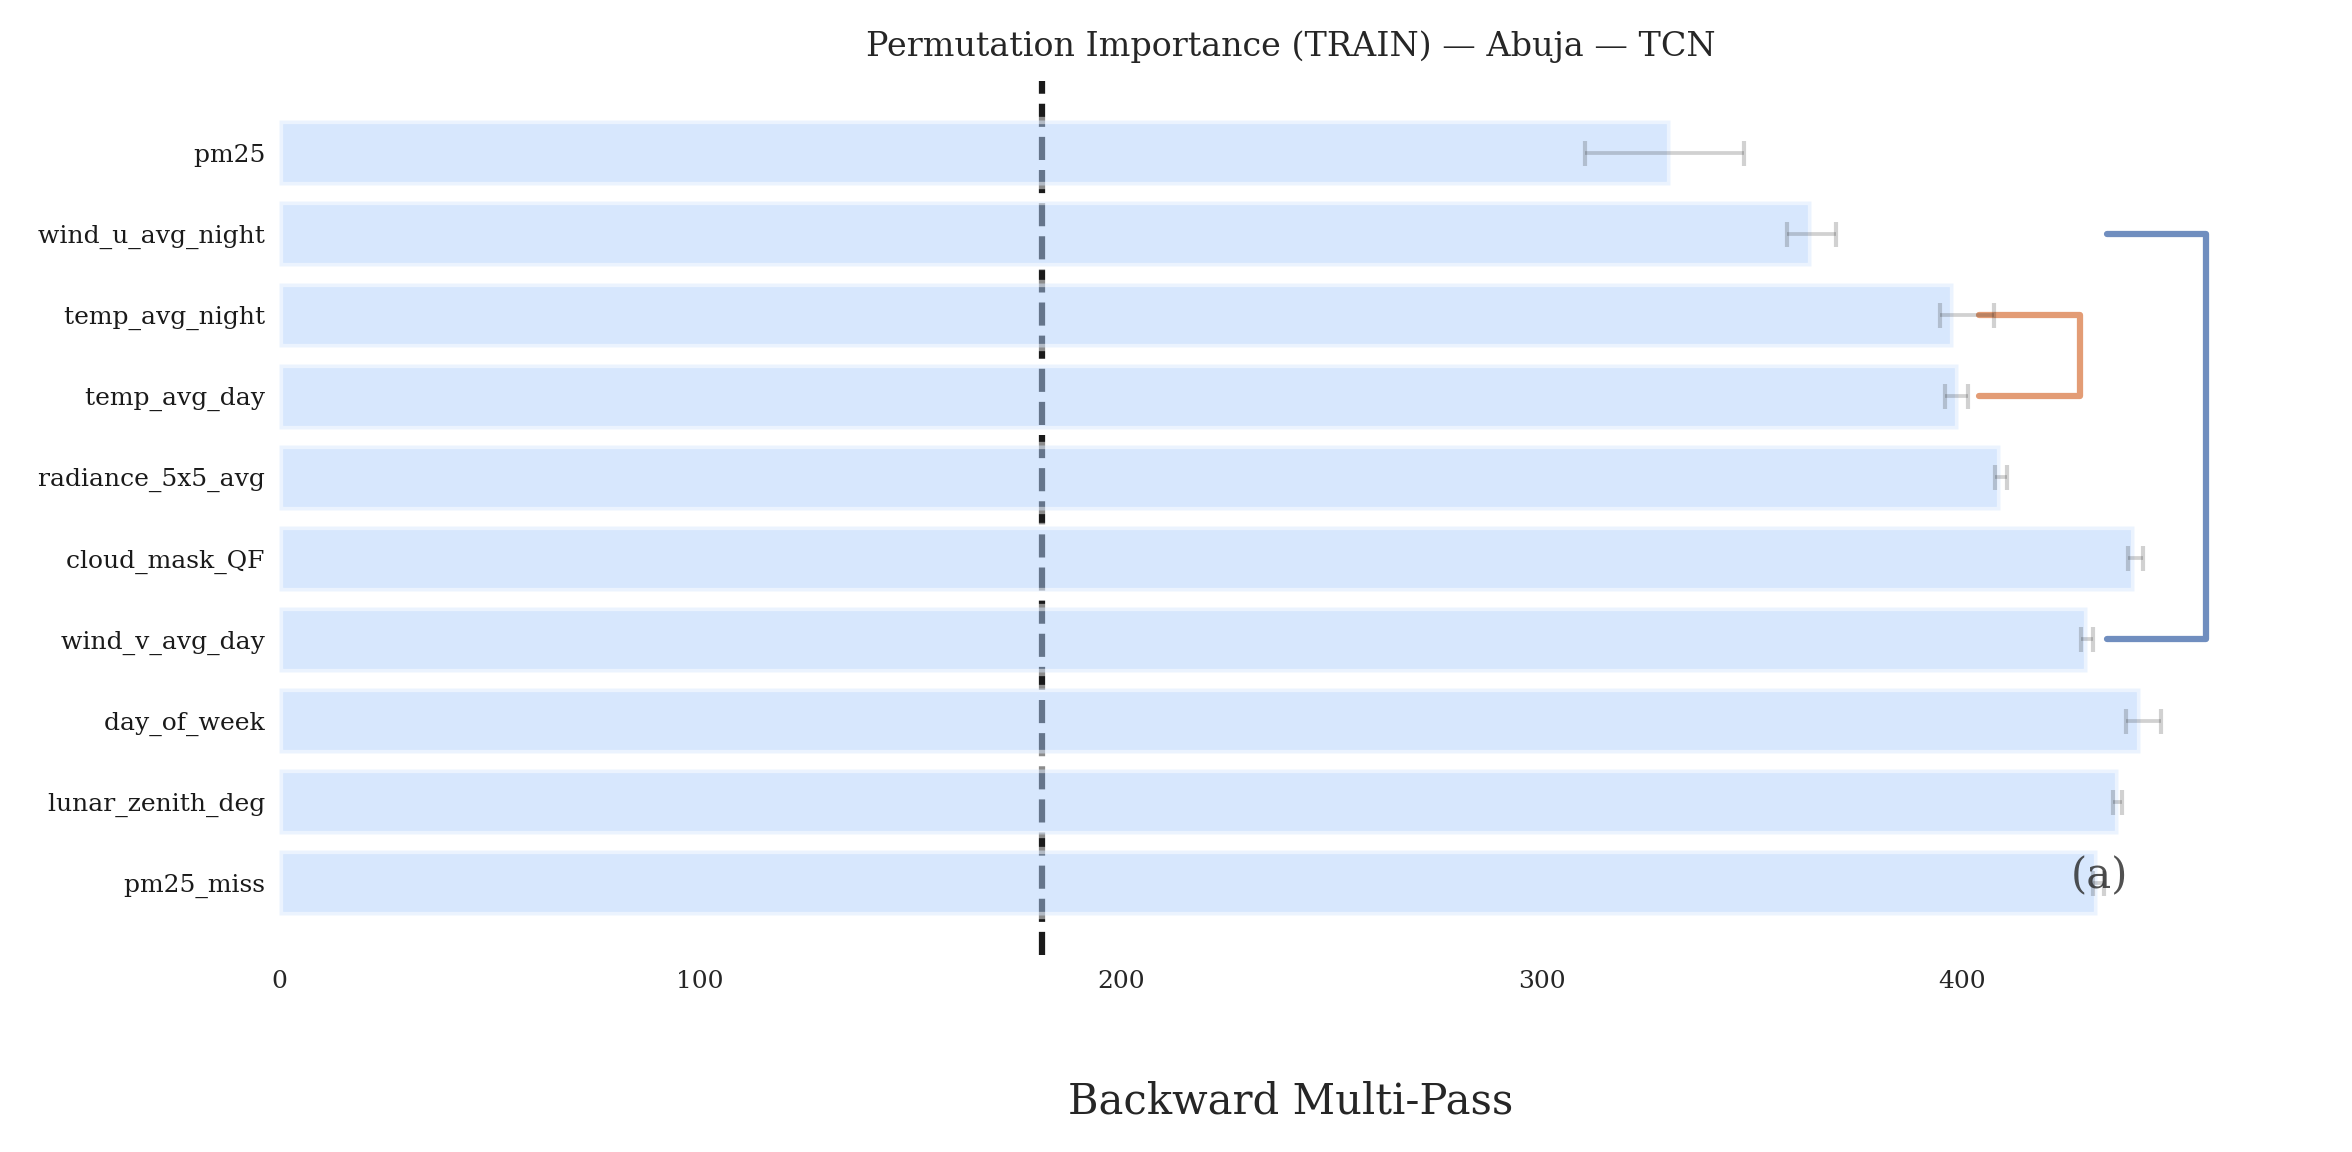

Running permutation importance (TRAIN) for Chennai...


Perm. Imp.: 100%|██████████| 10/10 [19:37<00:00, 117.72s/it]


  done in 1180.9s


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


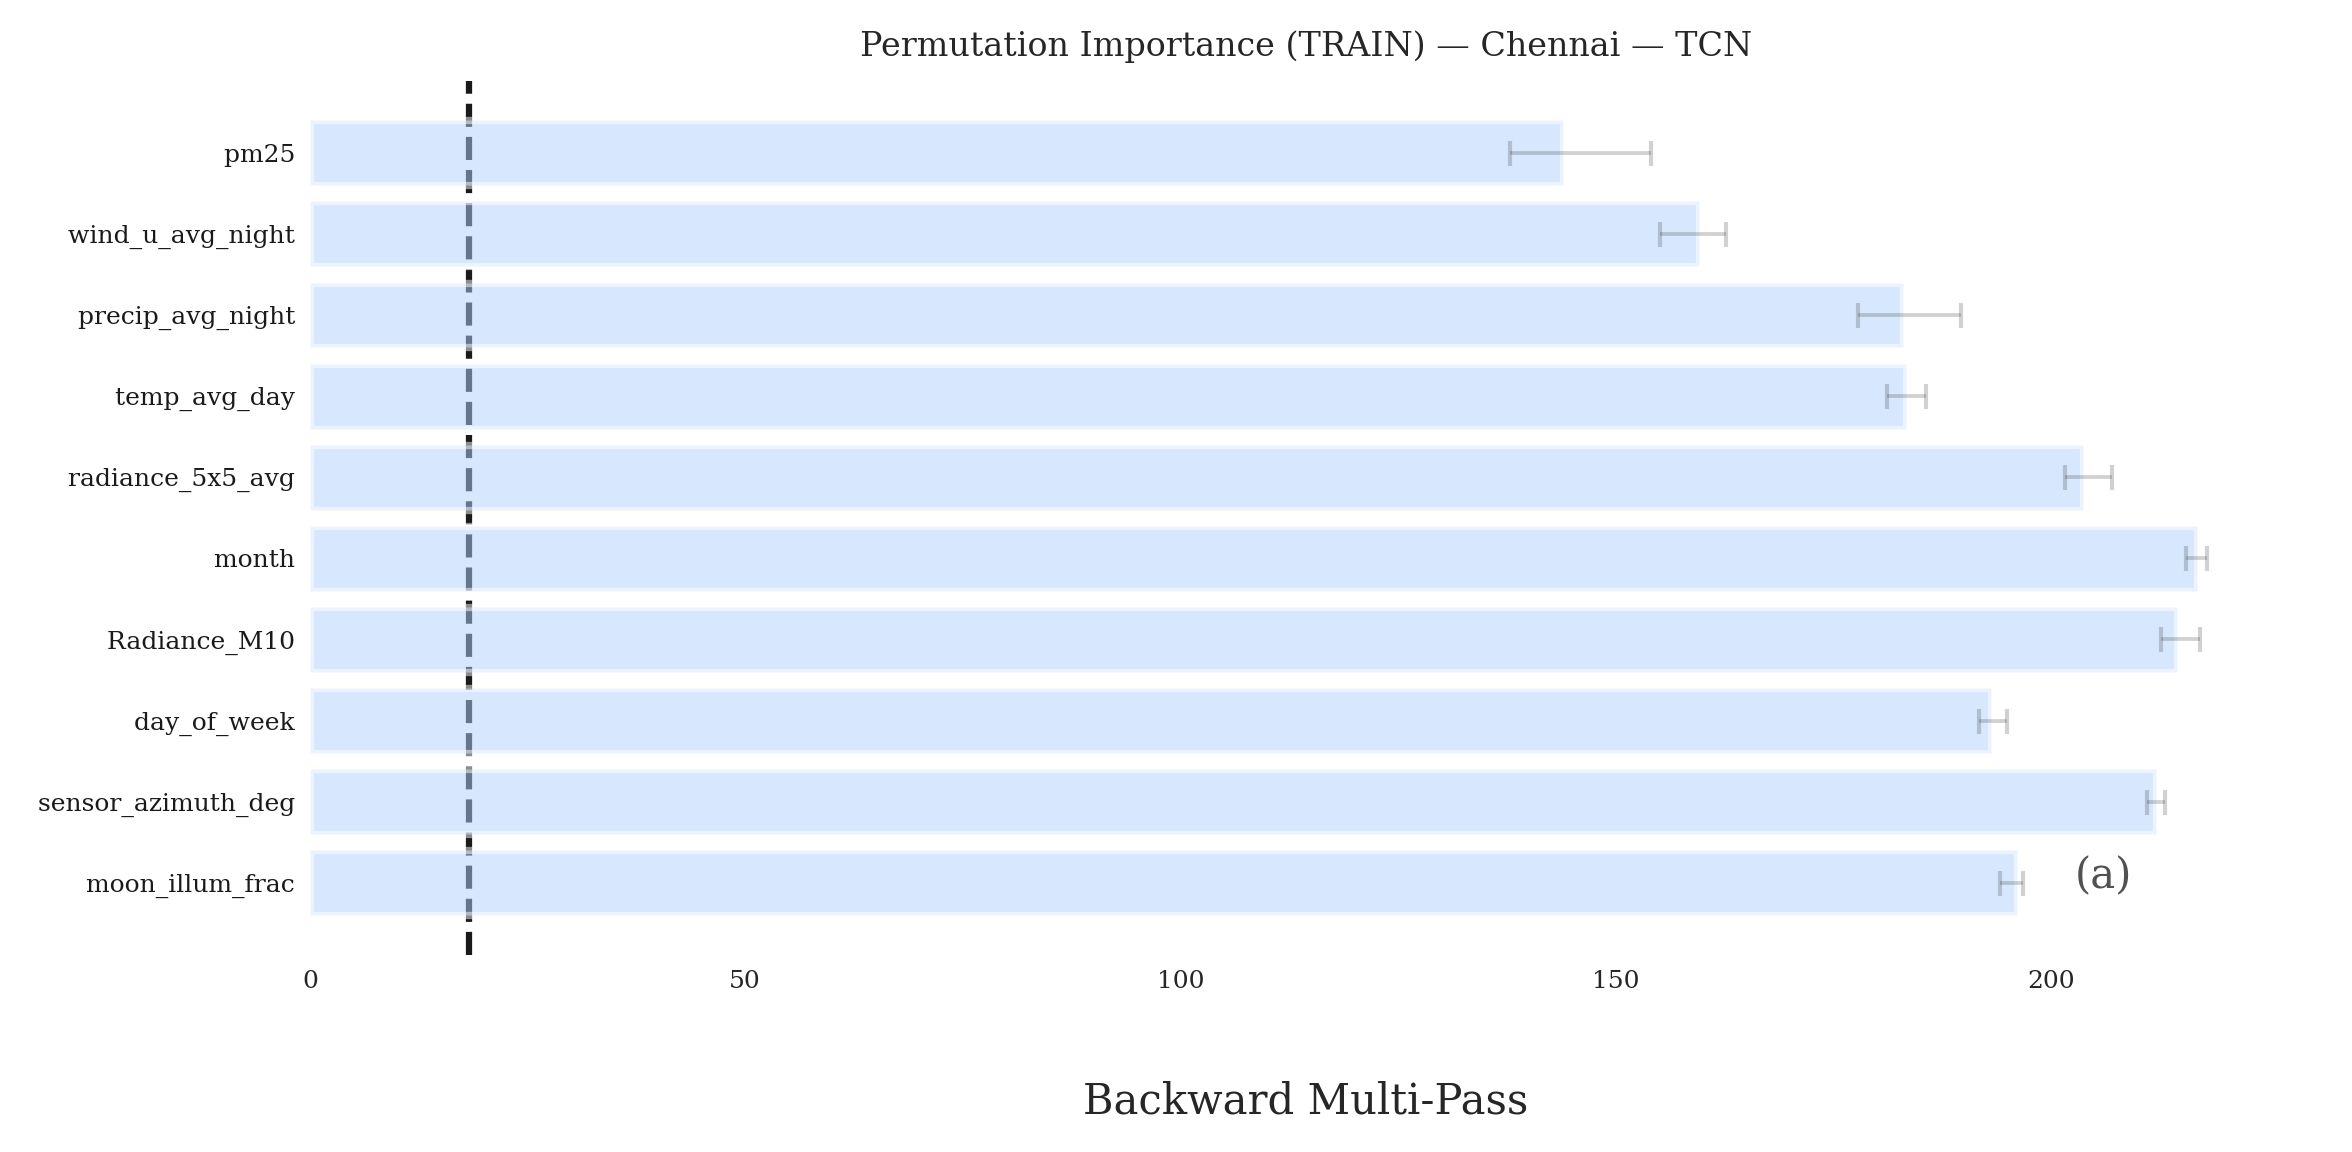

Running permutation importance (TRAIN) for NewDelhi...


Perm. Imp.: 100%|██████████| 10/10 [13:29<00:00, 80.98s/it]


  done in 811.9s


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


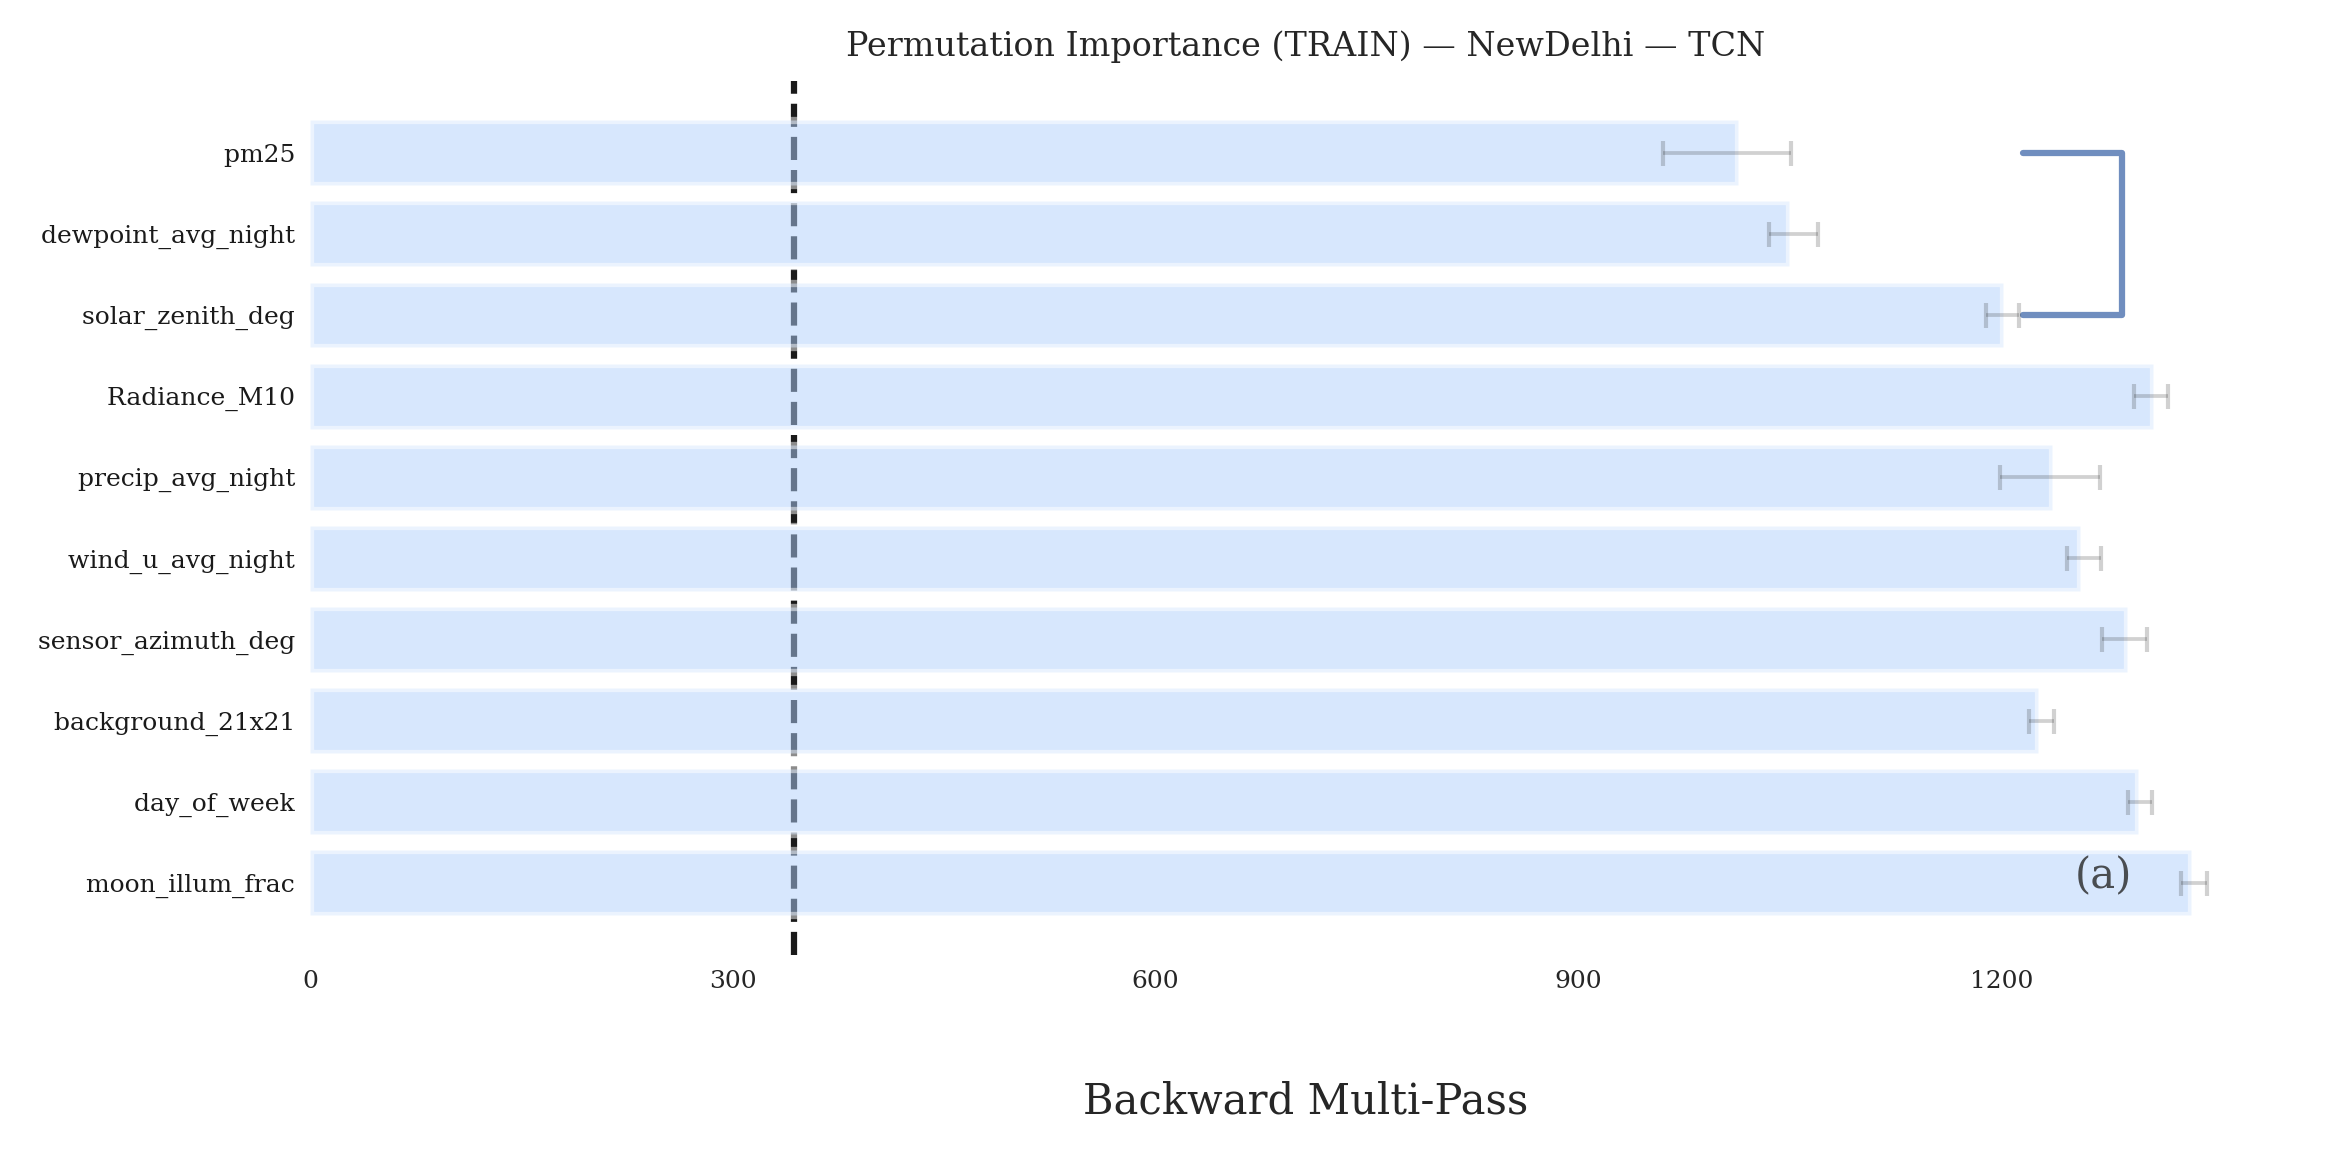

In [24]:
# ========== Cell 3: skexplain permutation importance on TRAIN ==========
import time, pathlib, numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import skexplain

results_dir = pathlib.Path("Datasets") / "results_csv"
results_dir.mkdir(parents=True, exist_ok=True)

tcn_city_explainers_train = {}

for city, pack in final_models_tcn_pc.items():
    X_train_2d = city_data_tcn_pc[city]["X_train_2d"]
    y_train    = city_data_tcn_pc[city]["y_train_seq"]

    # Build explainer exactly like XGBoost (estimator name differs)
    tcn_city_explainers_train[city] = skexplain.ExplainToolkit(
        estimators=[(f"{city}_tcn", pack["adapter_train"])],
        X=X_train_2d,
        y=y_train,
        feature_names=city_data_tcn_pc[city]["feature_cols"]
    )

# PI settings (keep subsample=1.0 so rows match stored windows; keep single job for PyTorch)
PI_TRAIN = dict(
    evaluation_fn='mse',
    n_vars=min(10, city_data_tcn_pc[next(iter(city_data_tcn_pc))]["X_train_2d"].shape[1]),
    n_permute=12,
    direction='backward',
    n_jobs=1,
    random_seed=42,
    subsample=1.0,
    verbose=False
)

for city, explainer in tcn_city_explainers_train.items():
    print(f"Running permutation importance (TRAIN) for {city}...")
    t0 = time.time()
    results = explainer.permutation_importance(**PI_TRAIN)
    print(f"  done in {time.time()-t0:.1f}s")

    out_nc = results_dir / f"{city}_TCN_permu_TRAIN.nc"
    results.to_netcdf(out_nc)

    fig = explainer.plot_importance(
        data=results,
        panels=[('backward_multipass', f"{city}_tcn")],
        num_vars_to_plot=10,
        plot_correlated_features=True,
        rho_threshold=0.60,
        sort_vars=True,
        figsize=(8, 4)
    )
    plt.title(f"Permutation Importance (TRAIN) — {city} — TCN")
    plt.tight_layout(); plt.show()


Running permutation importance (TEST) for Abuja...


Perm. Imp.: 100%|██████████| 10/10 [04:23<00:00, 26.36s/it]


  done in 266.3s


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


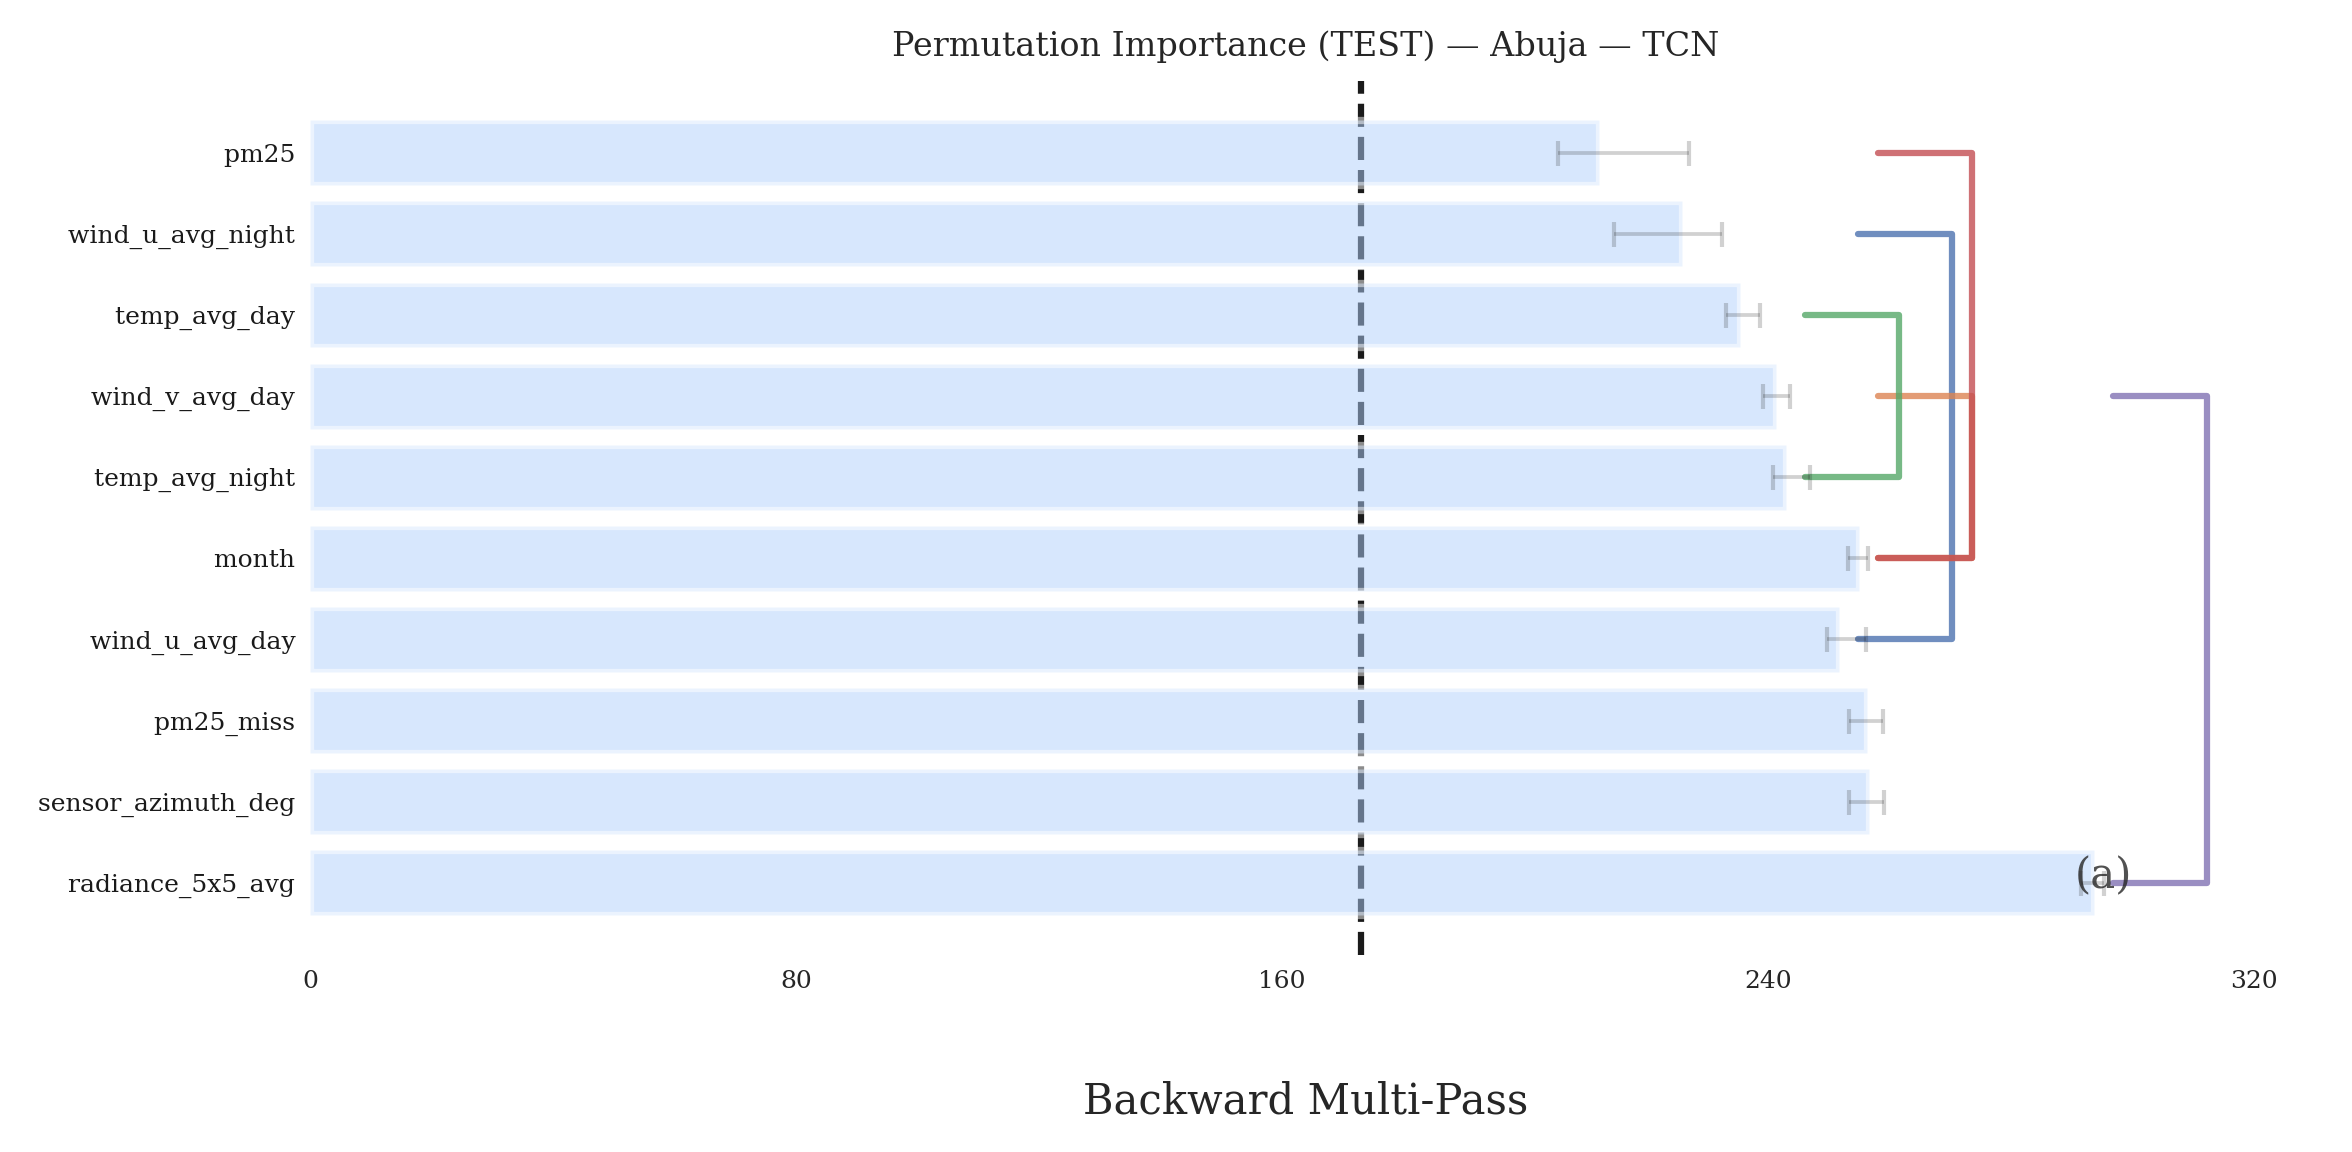

Running permutation importance (TEST) for Chennai...


Perm. Imp.: 100%|██████████| 10/10 [03:49<00:00, 22.90s/it]


  done in 229.9s


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


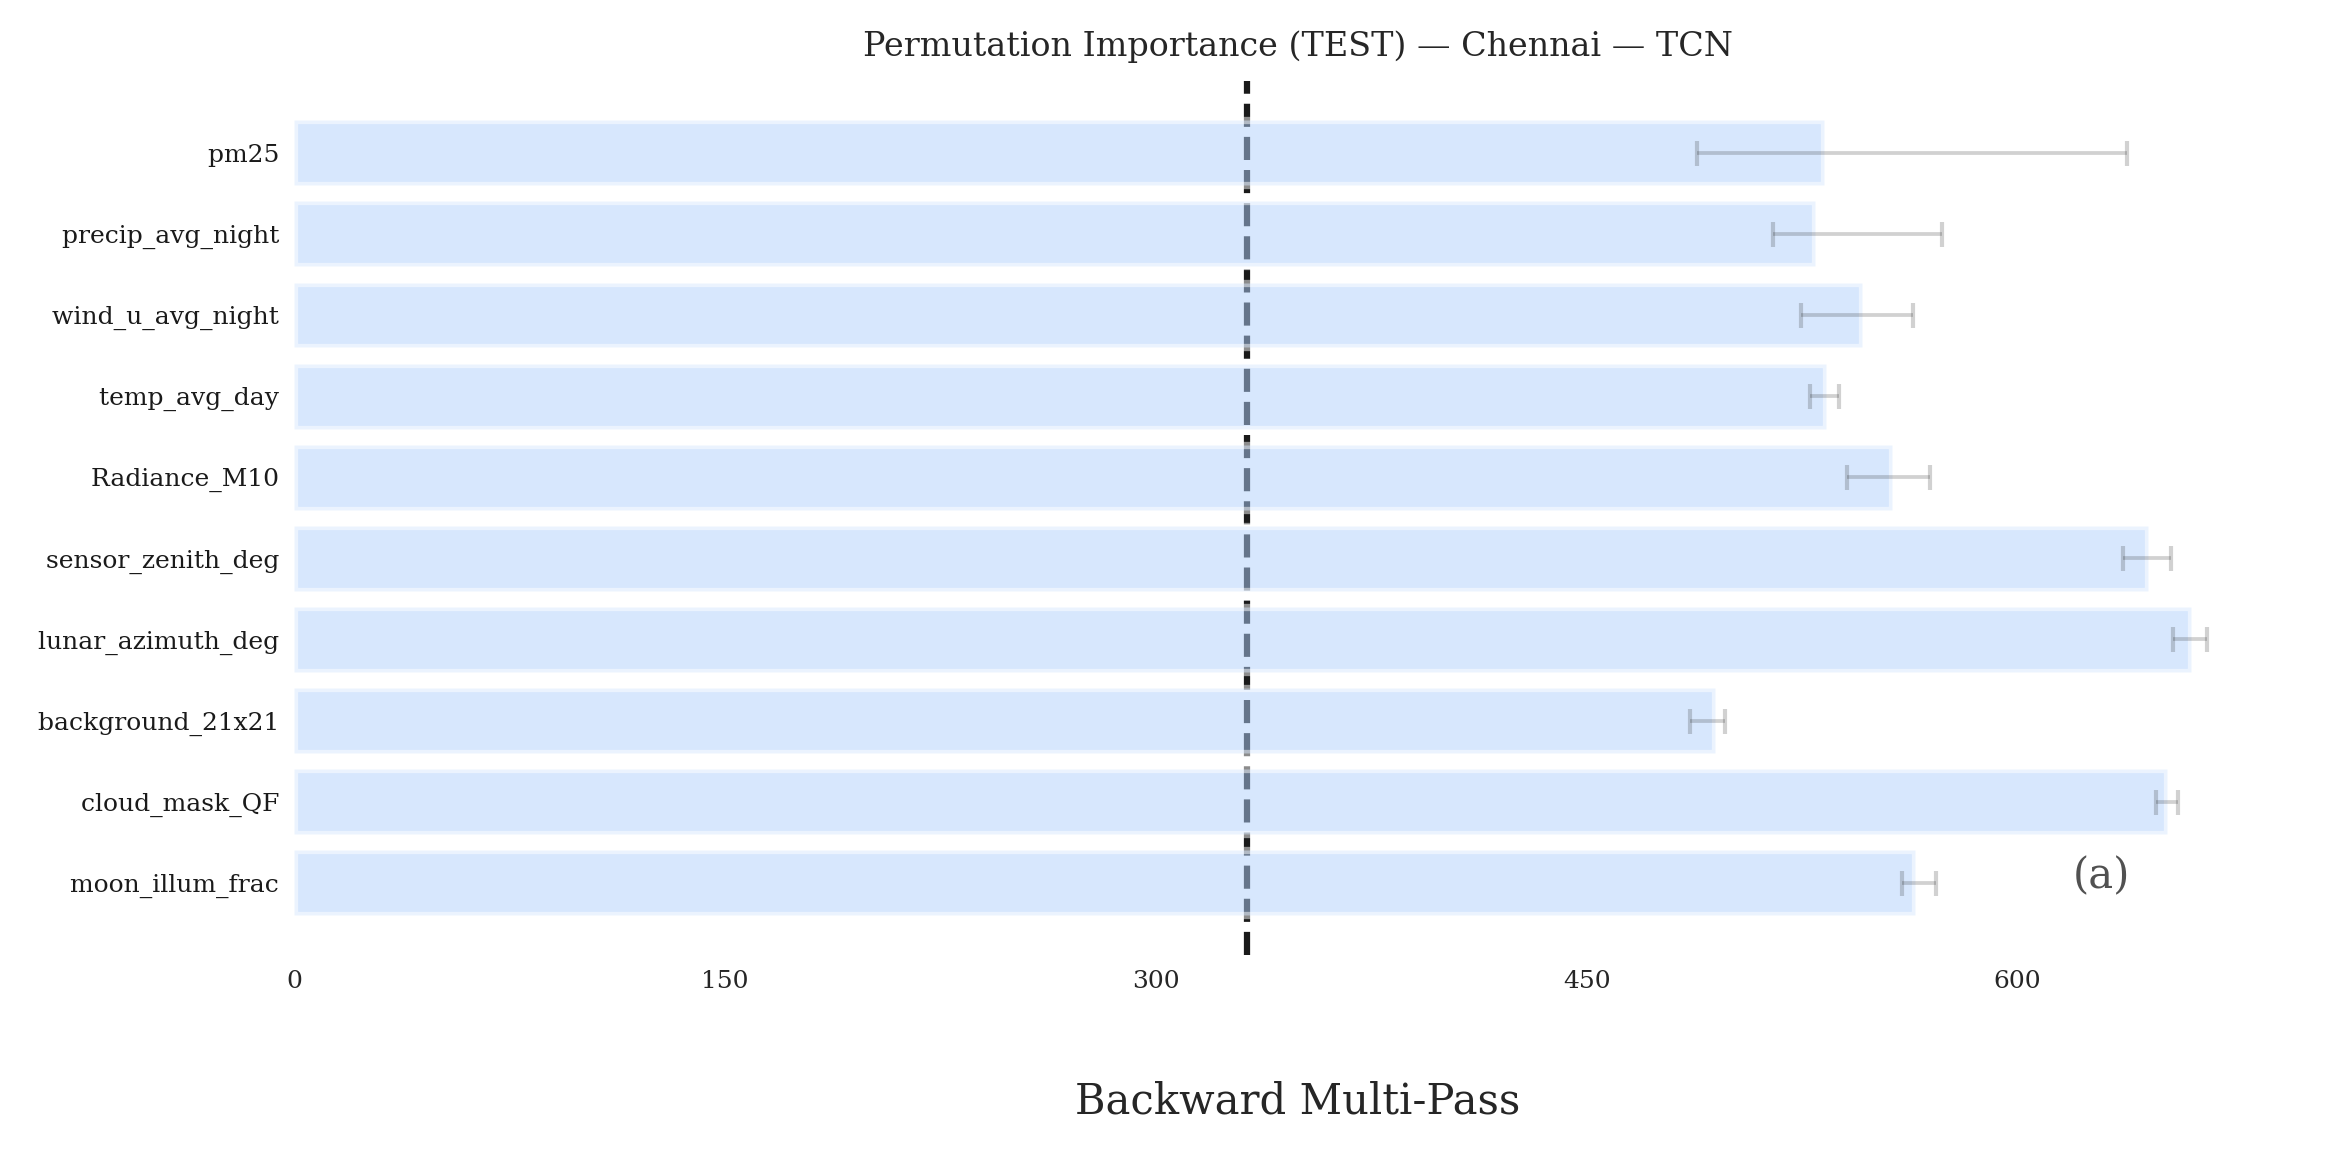

Running permutation importance (TEST) for NewDelhi...


Perm. Imp.: 100%|██████████| 10/10 [03:03<00:00, 18.31s/it]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\common\importance_utils.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_corr_value = sub_corr_matrix[feature].sort_values(ascending=False)[1]


  done in 183.7s


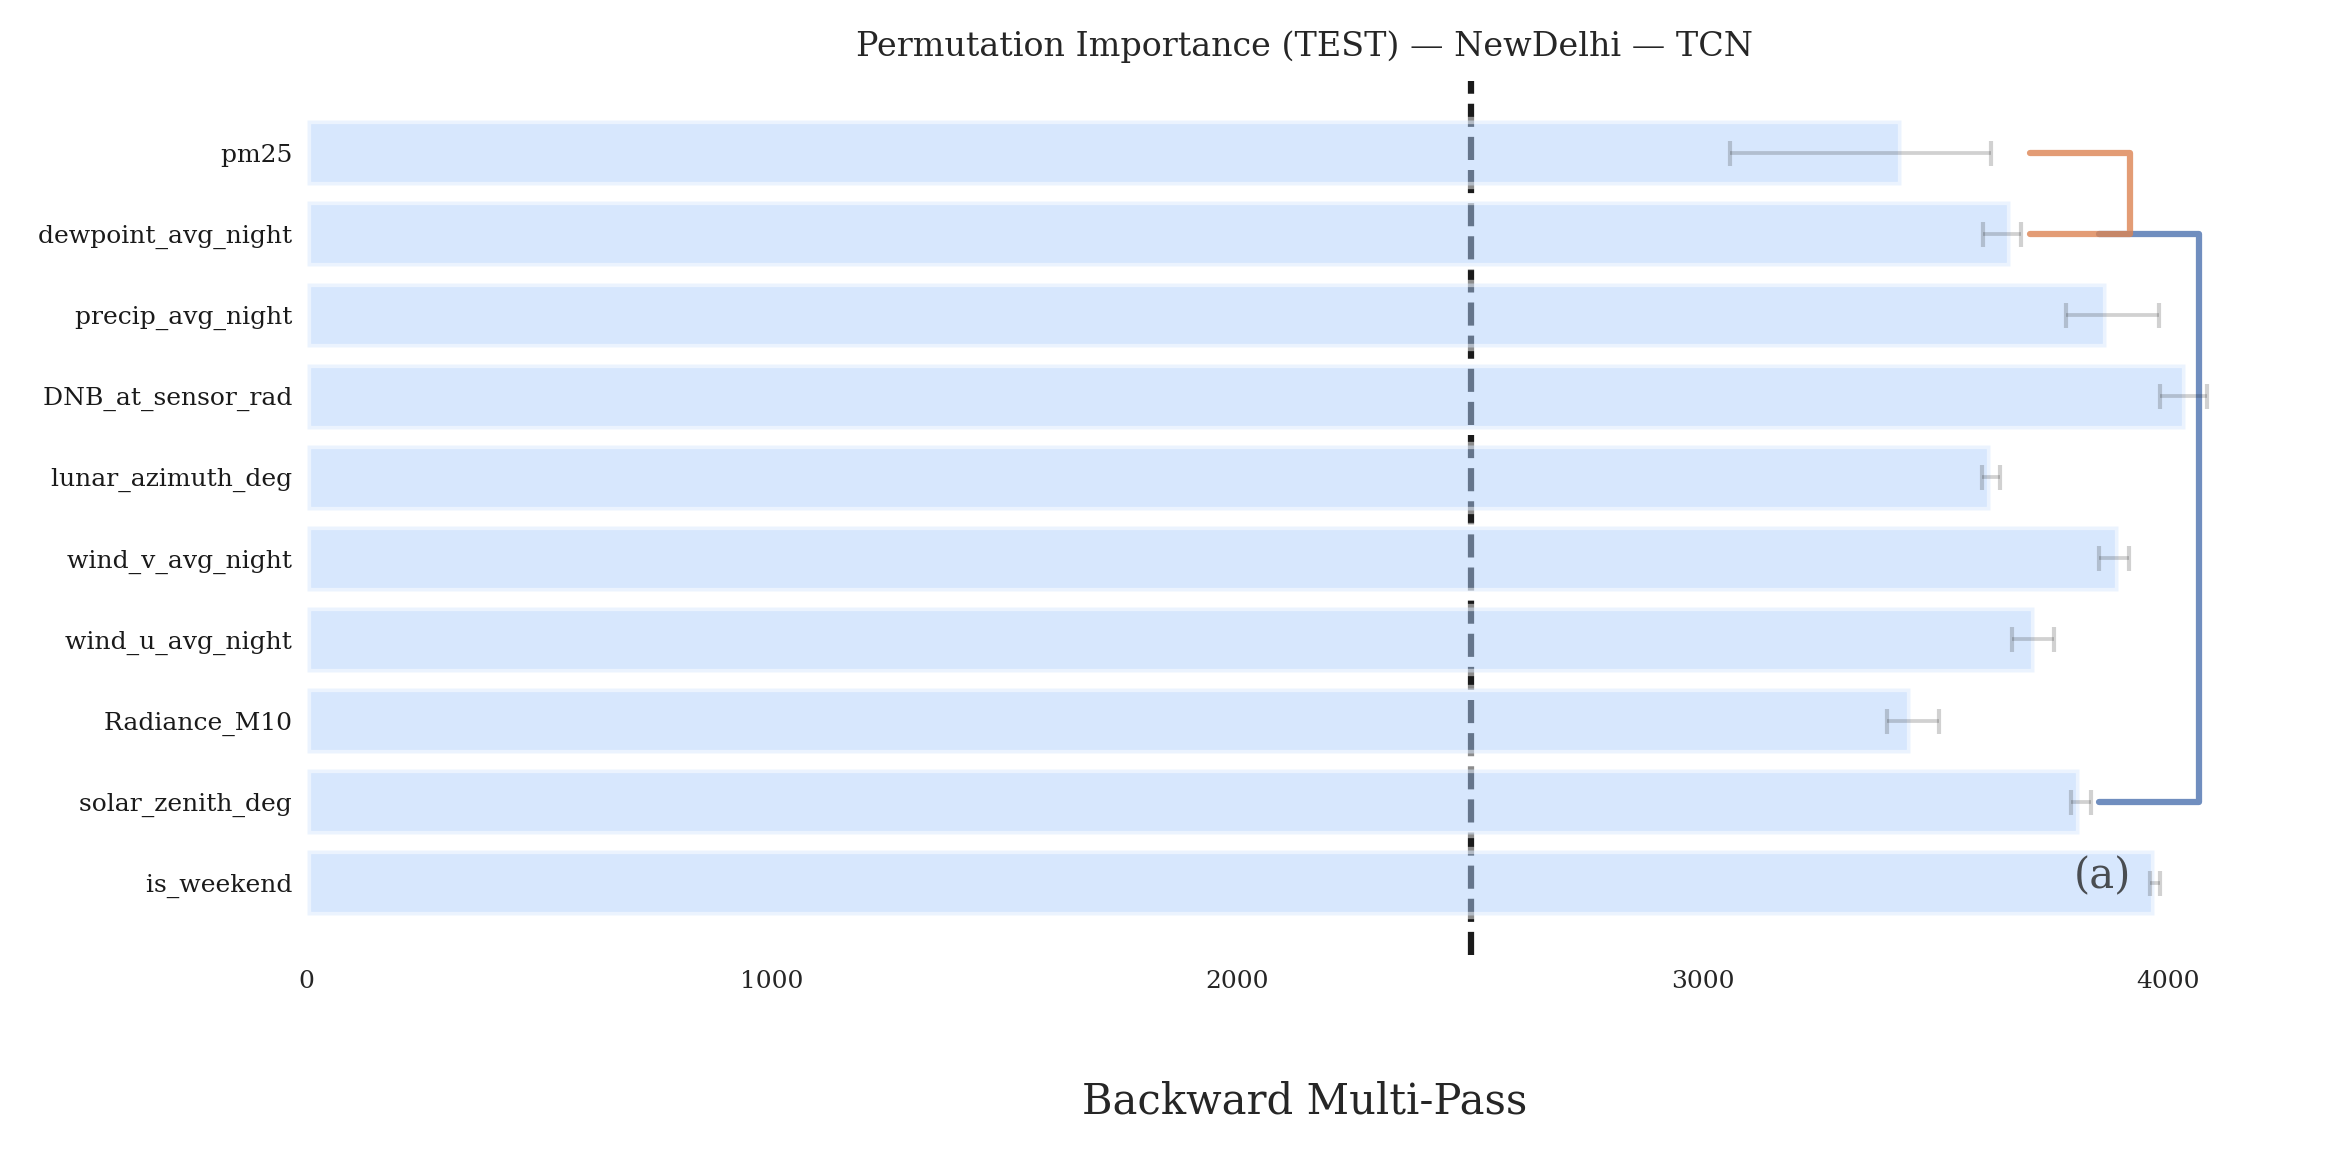

In [25]:
results_dir = pathlib.Path("Datasets") / "results_csv"
results_dir.mkdir(parents=True, exist_ok=True)

tcn_city_explainers_test = {}

for city, pack in final_models_tcn_pc.items():
    X_test_2d = city_data_tcn_pc[city]["X_test_2d"]
    y_test    = city_data_tcn_pc[city]["y_test_seq"]

    tcn_city_explainers_test[city] = skexplain.ExplainToolkit(
        estimators=[(f"{city}_tcn", pack["adapter_test"])],
        X=X_test_2d,
        y=y_test,
        feature_names=city_data_tcn_pc[city]["feature_cols"]
    )

PI_TEST = dict(
    evaluation_fn='mse',
    n_vars=min(10, city_data_tcn_pc[next(iter(city_data_tcn_pc))]["X_test_2d"].shape[1]),
    n_permute=12,
    direction='backward',
    n_jobs=1,        # keep single-process for PyTorch models
    random_seed=42,
    subsample=1.0,   # use full TEST for stability and to keep row counts aligned
    verbose=False
)

for city, explainer in tcn_city_explainers_test.items():
    print(f"Running permutation importance (TEST) for {city}...")
    t0 = time.time()
    results = explainer.permutation_importance(**PI_TEST)
    print(f"  done in {time.time()-t0:.1f}s")

    out_nc = results_dir / f"{city}_TCN_permu_TEST.nc"
    results.to_netcdf(out_nc)

    fig = explainer.plot_importance(
        data=results,
        panels=[('backward_multipass', f"{city}_tcn")],
        num_vars_to_plot=10,
        plot_correlated_features=True,
        rho_threshold=0.60,
        sort_vars=True,
        figsize=(8, 4)
    )
    plt.title(f"Permutation Importance (TEST) — {city} — TCN")
    plt.tight_layout(); plt.show()

## Local Explainability for High Pollution Days

In [27]:
import numpy as np, pandas as pd, shap, xarray as xr, matplotlib.pyplot as plt
import skexplain

PermutationExplainer explainer: 2it [00:13, 13.04s/it]               
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favou

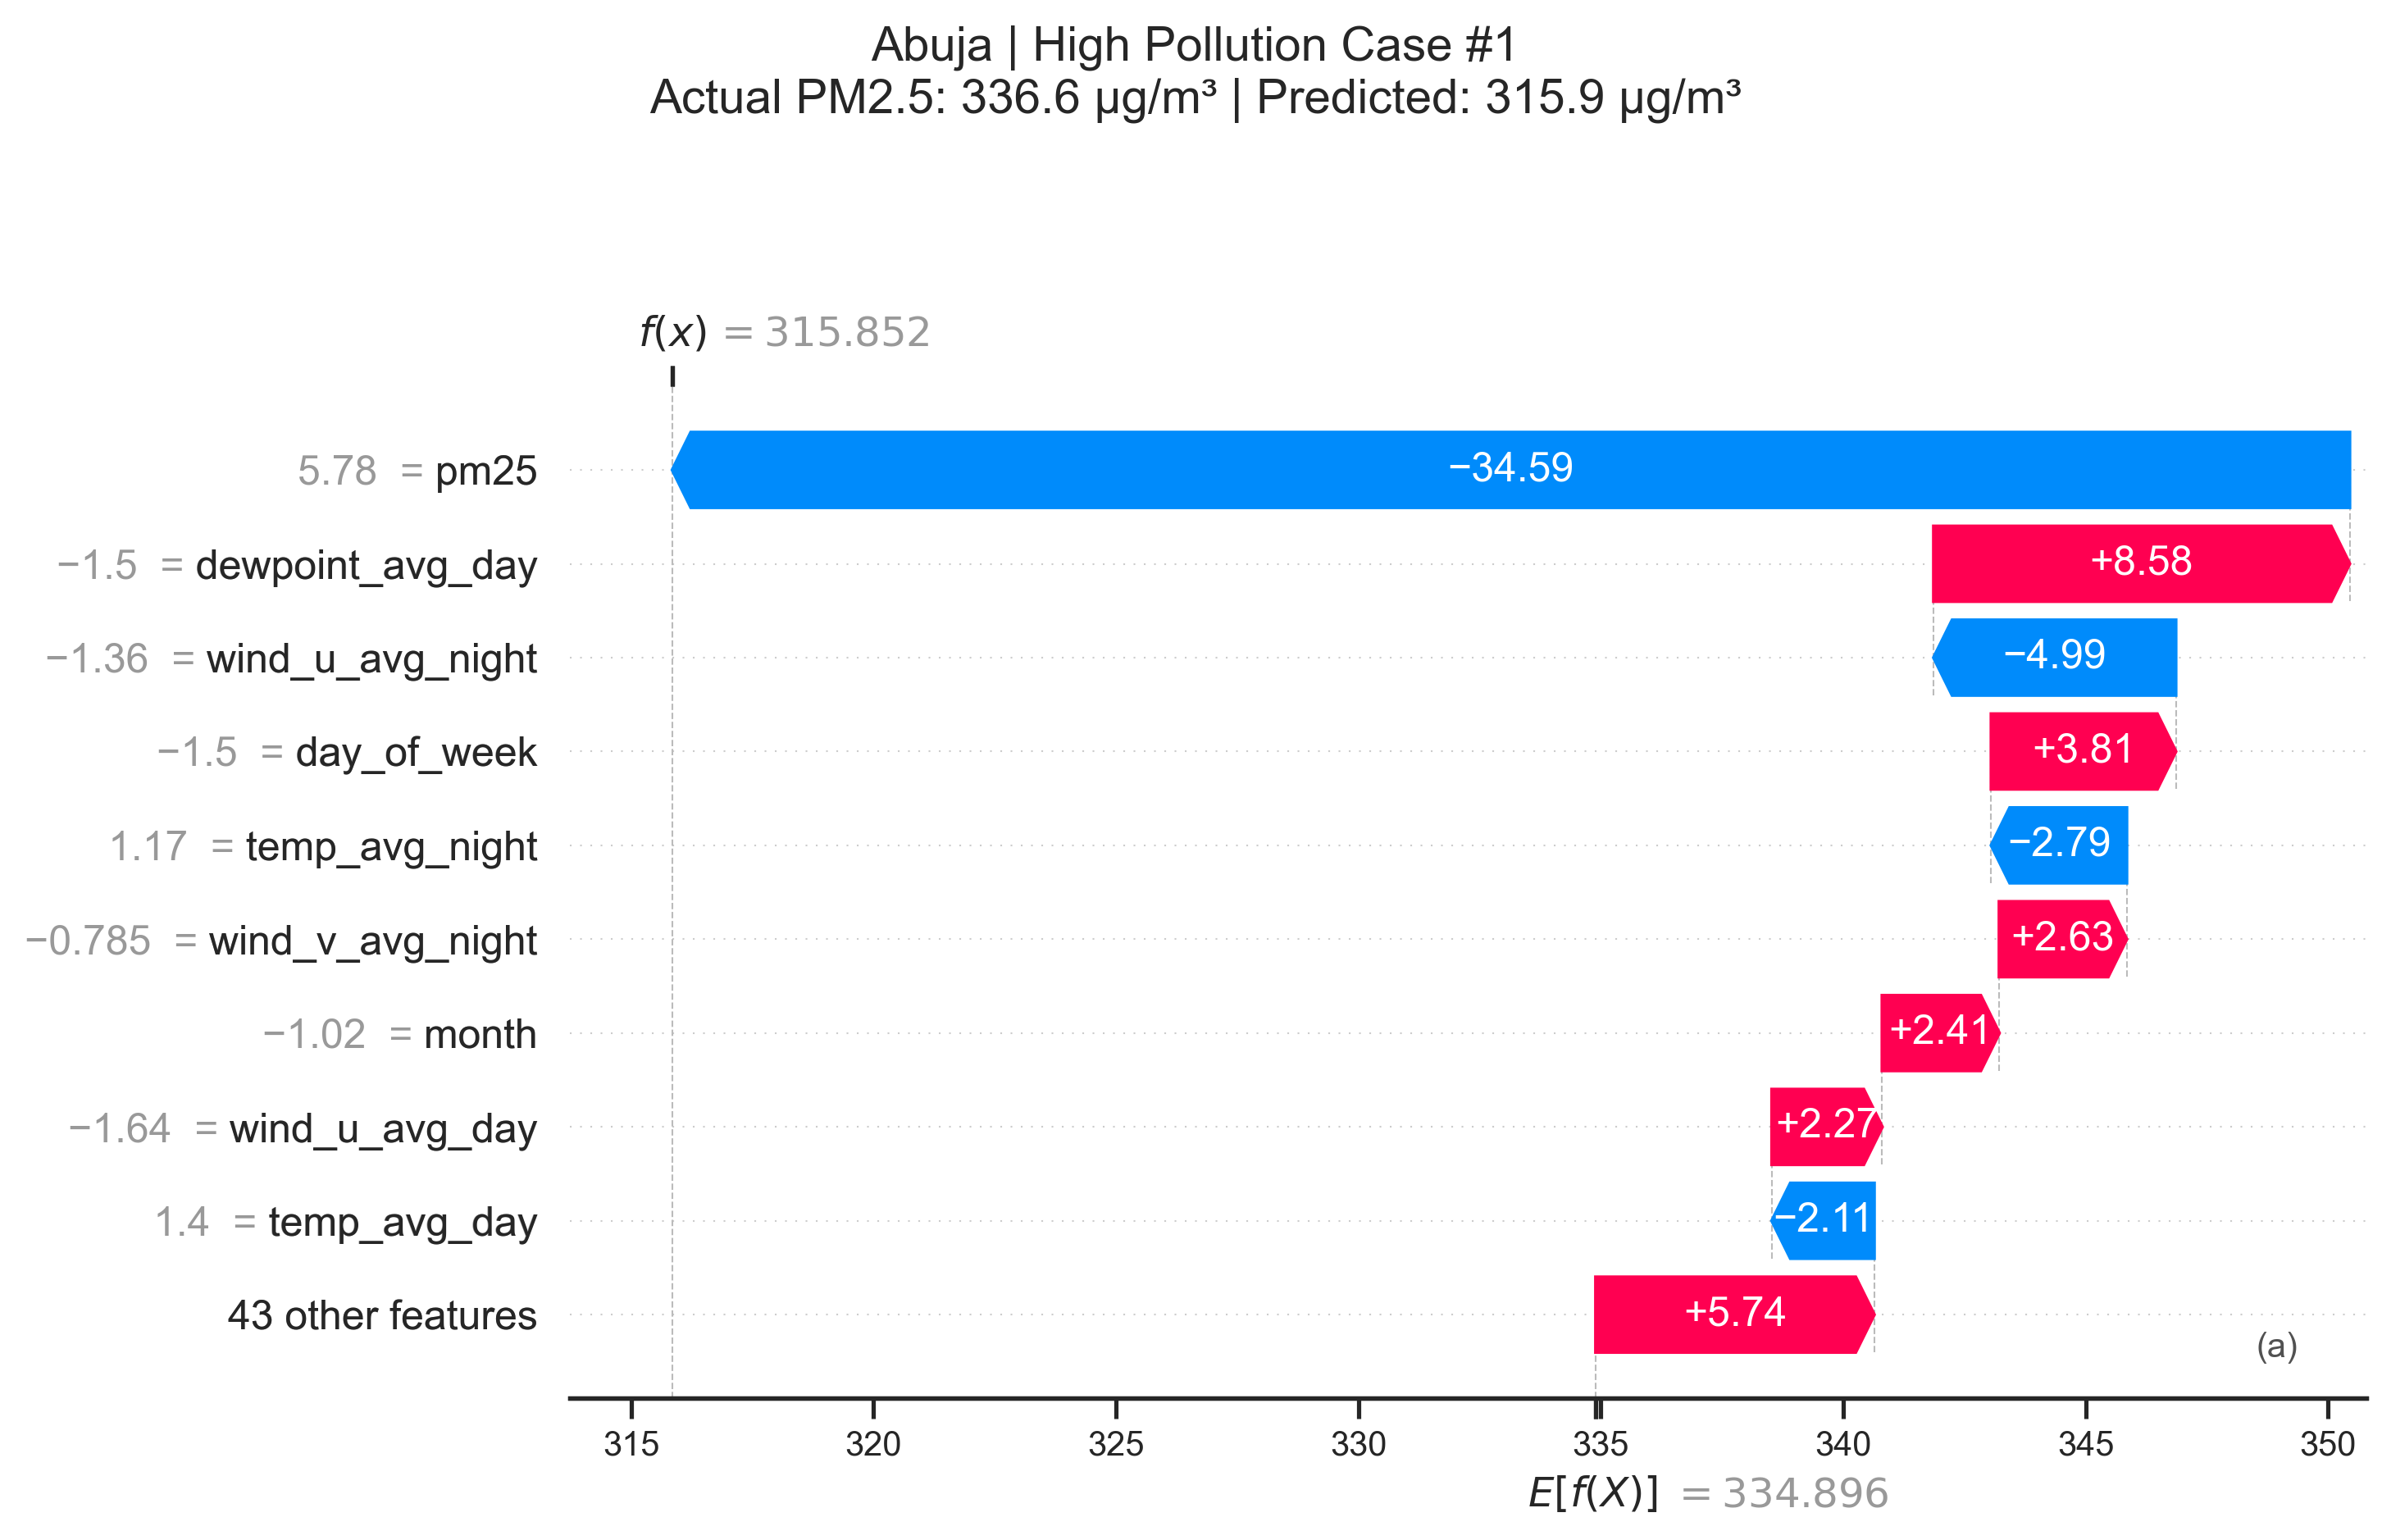

PermutationExplainer explainer: 2it [00:10, 10.35s/it]               
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favou

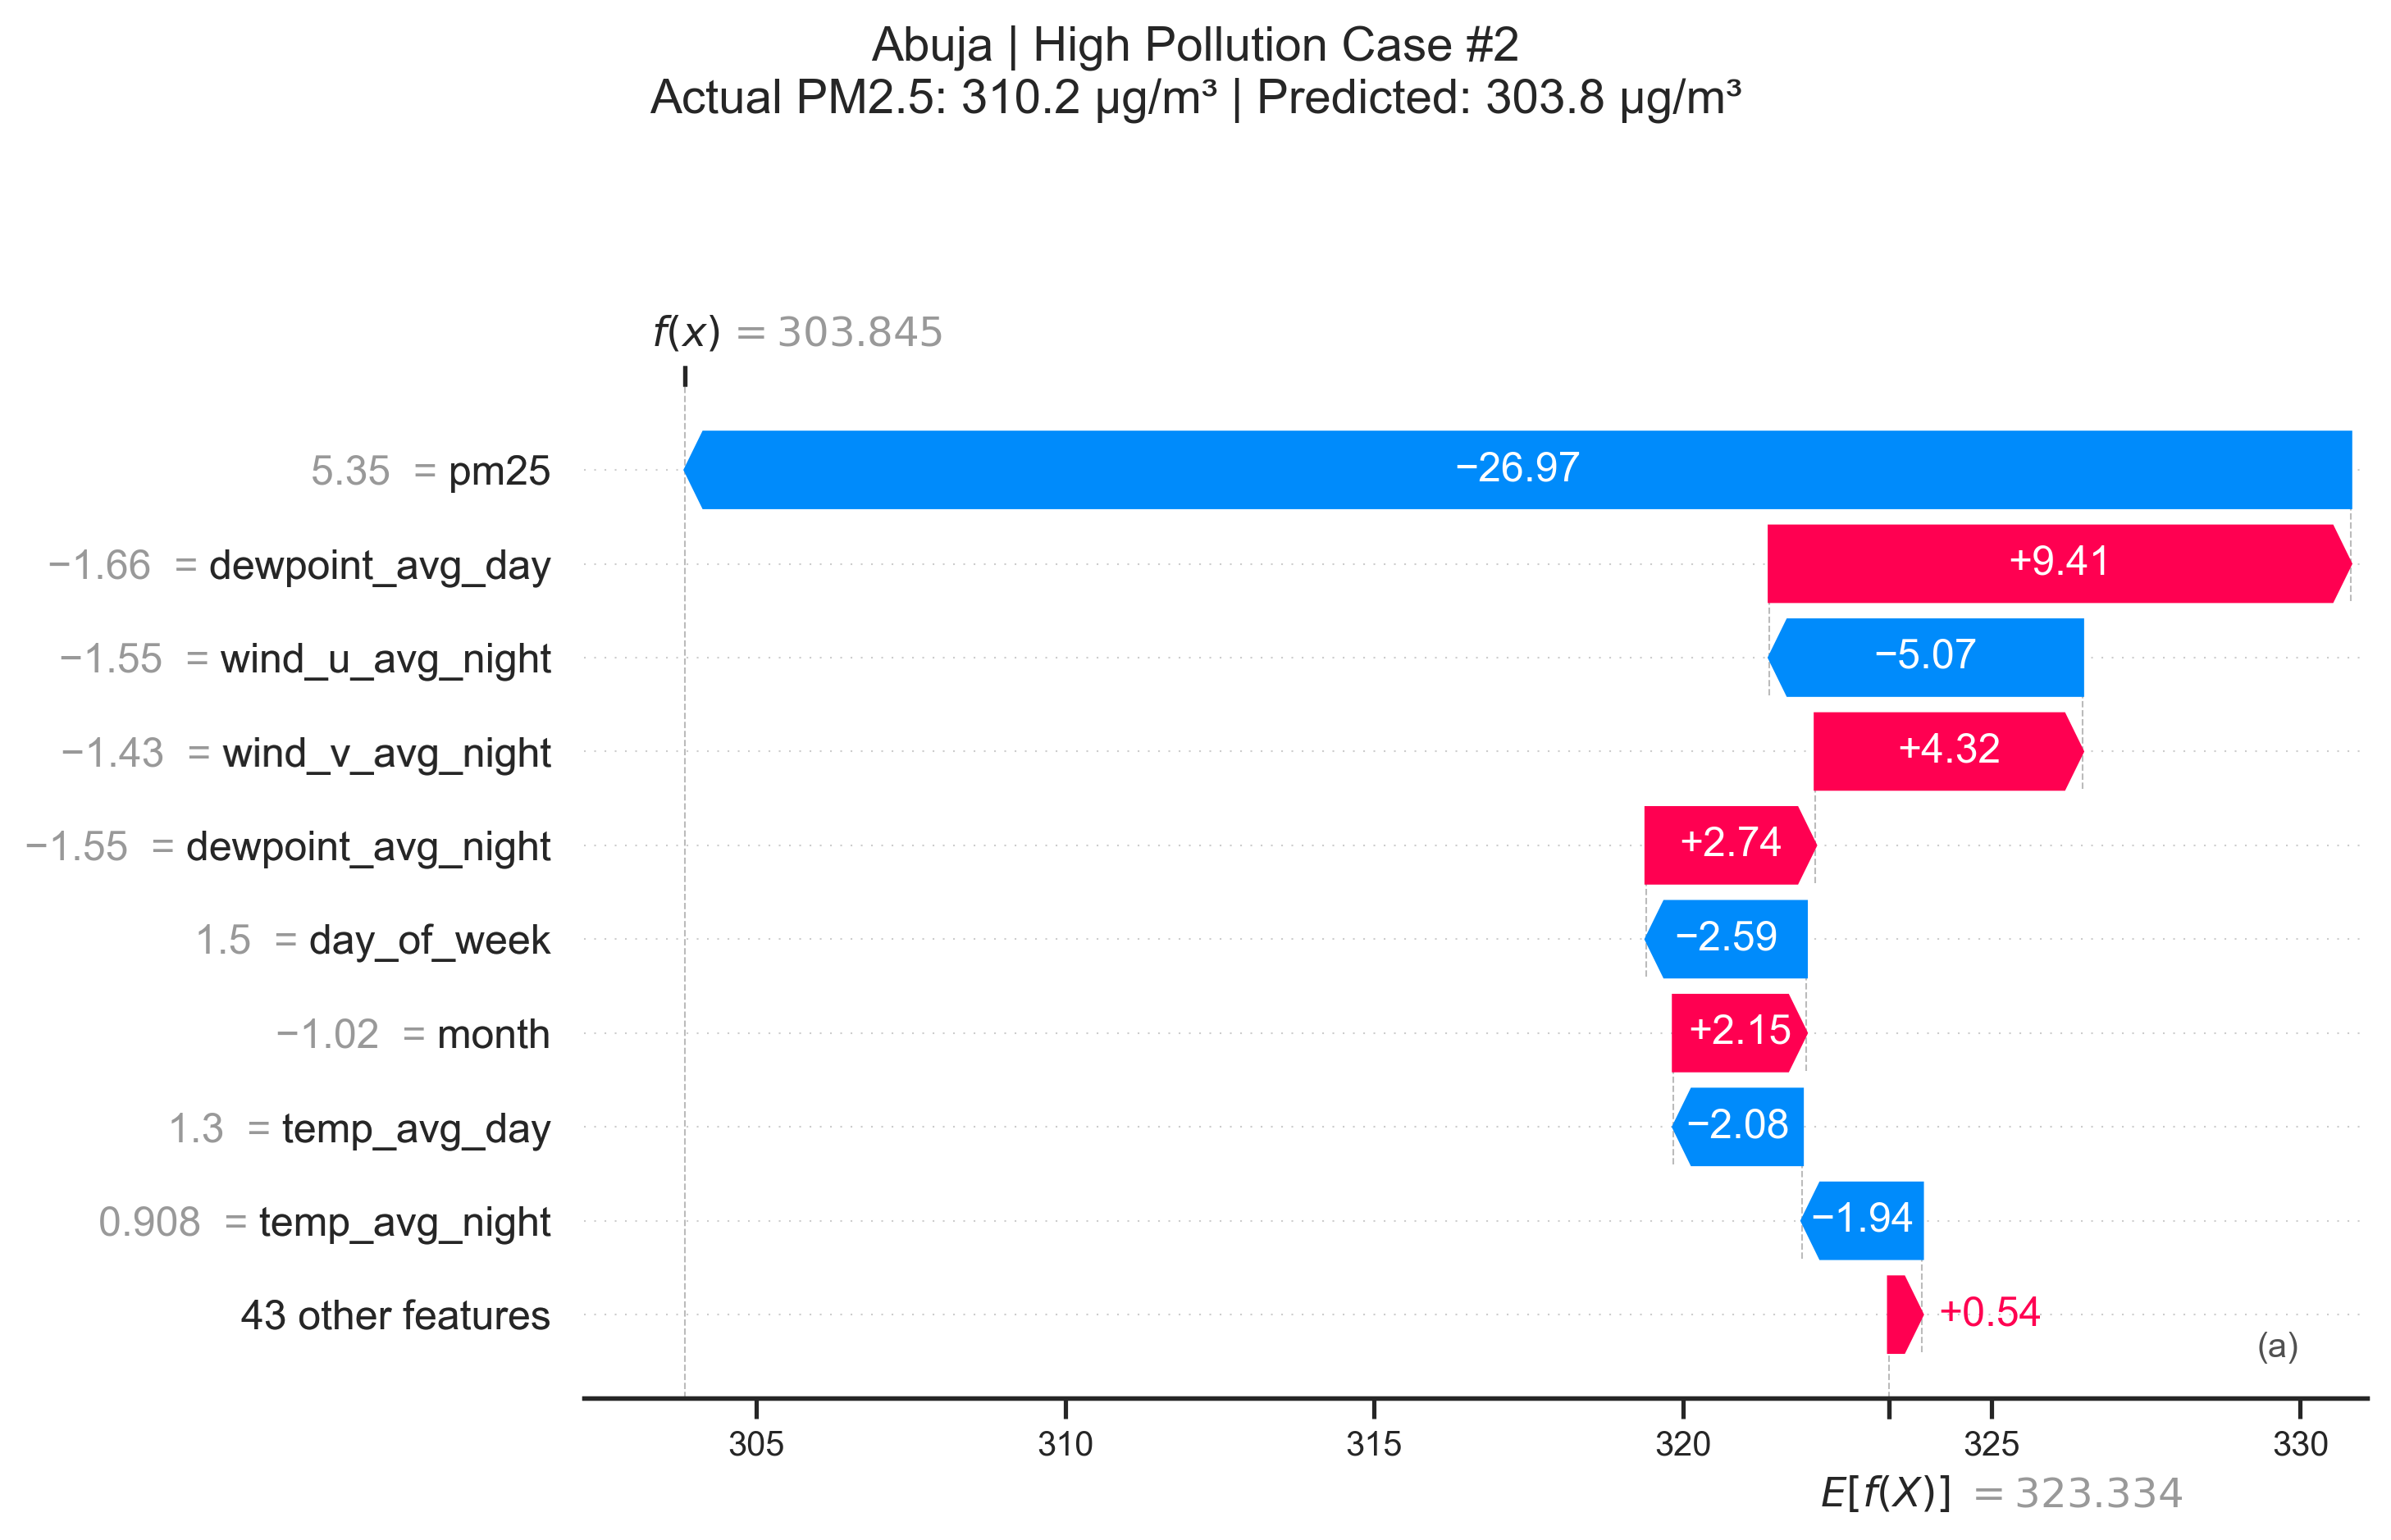

PermutationExplainer explainer: 2it [00:12, 12.28s/it]               
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favou

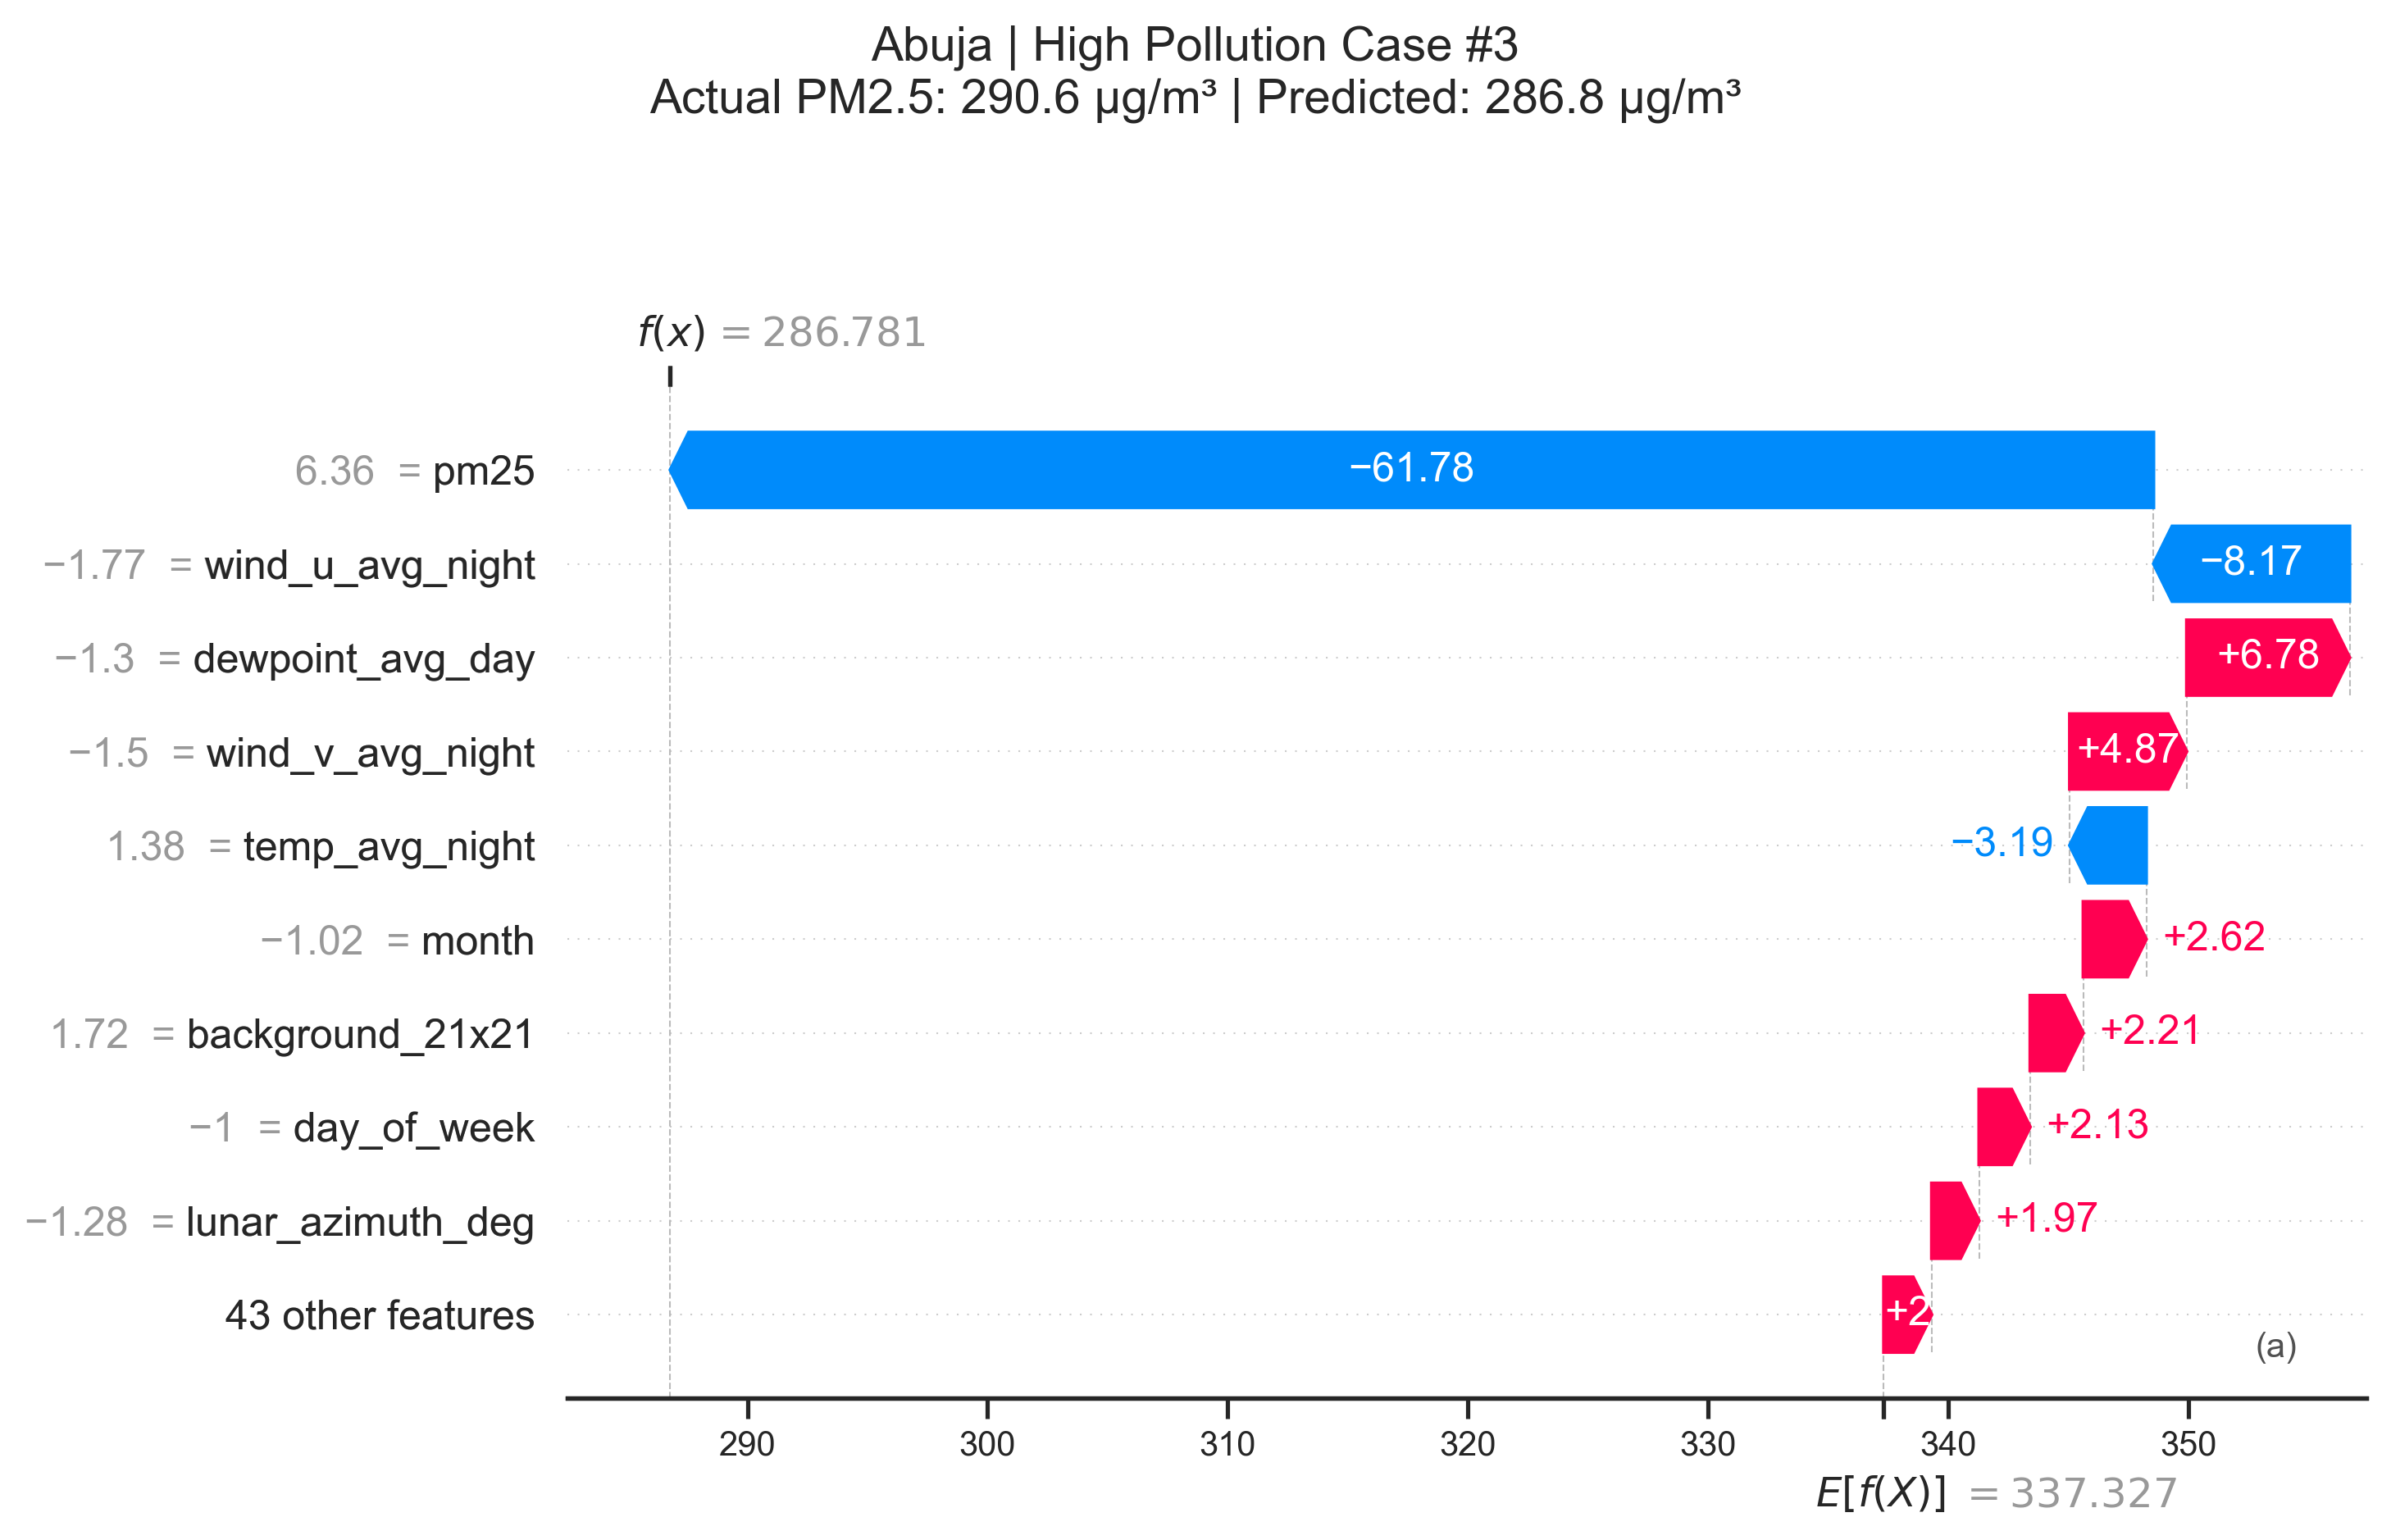

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

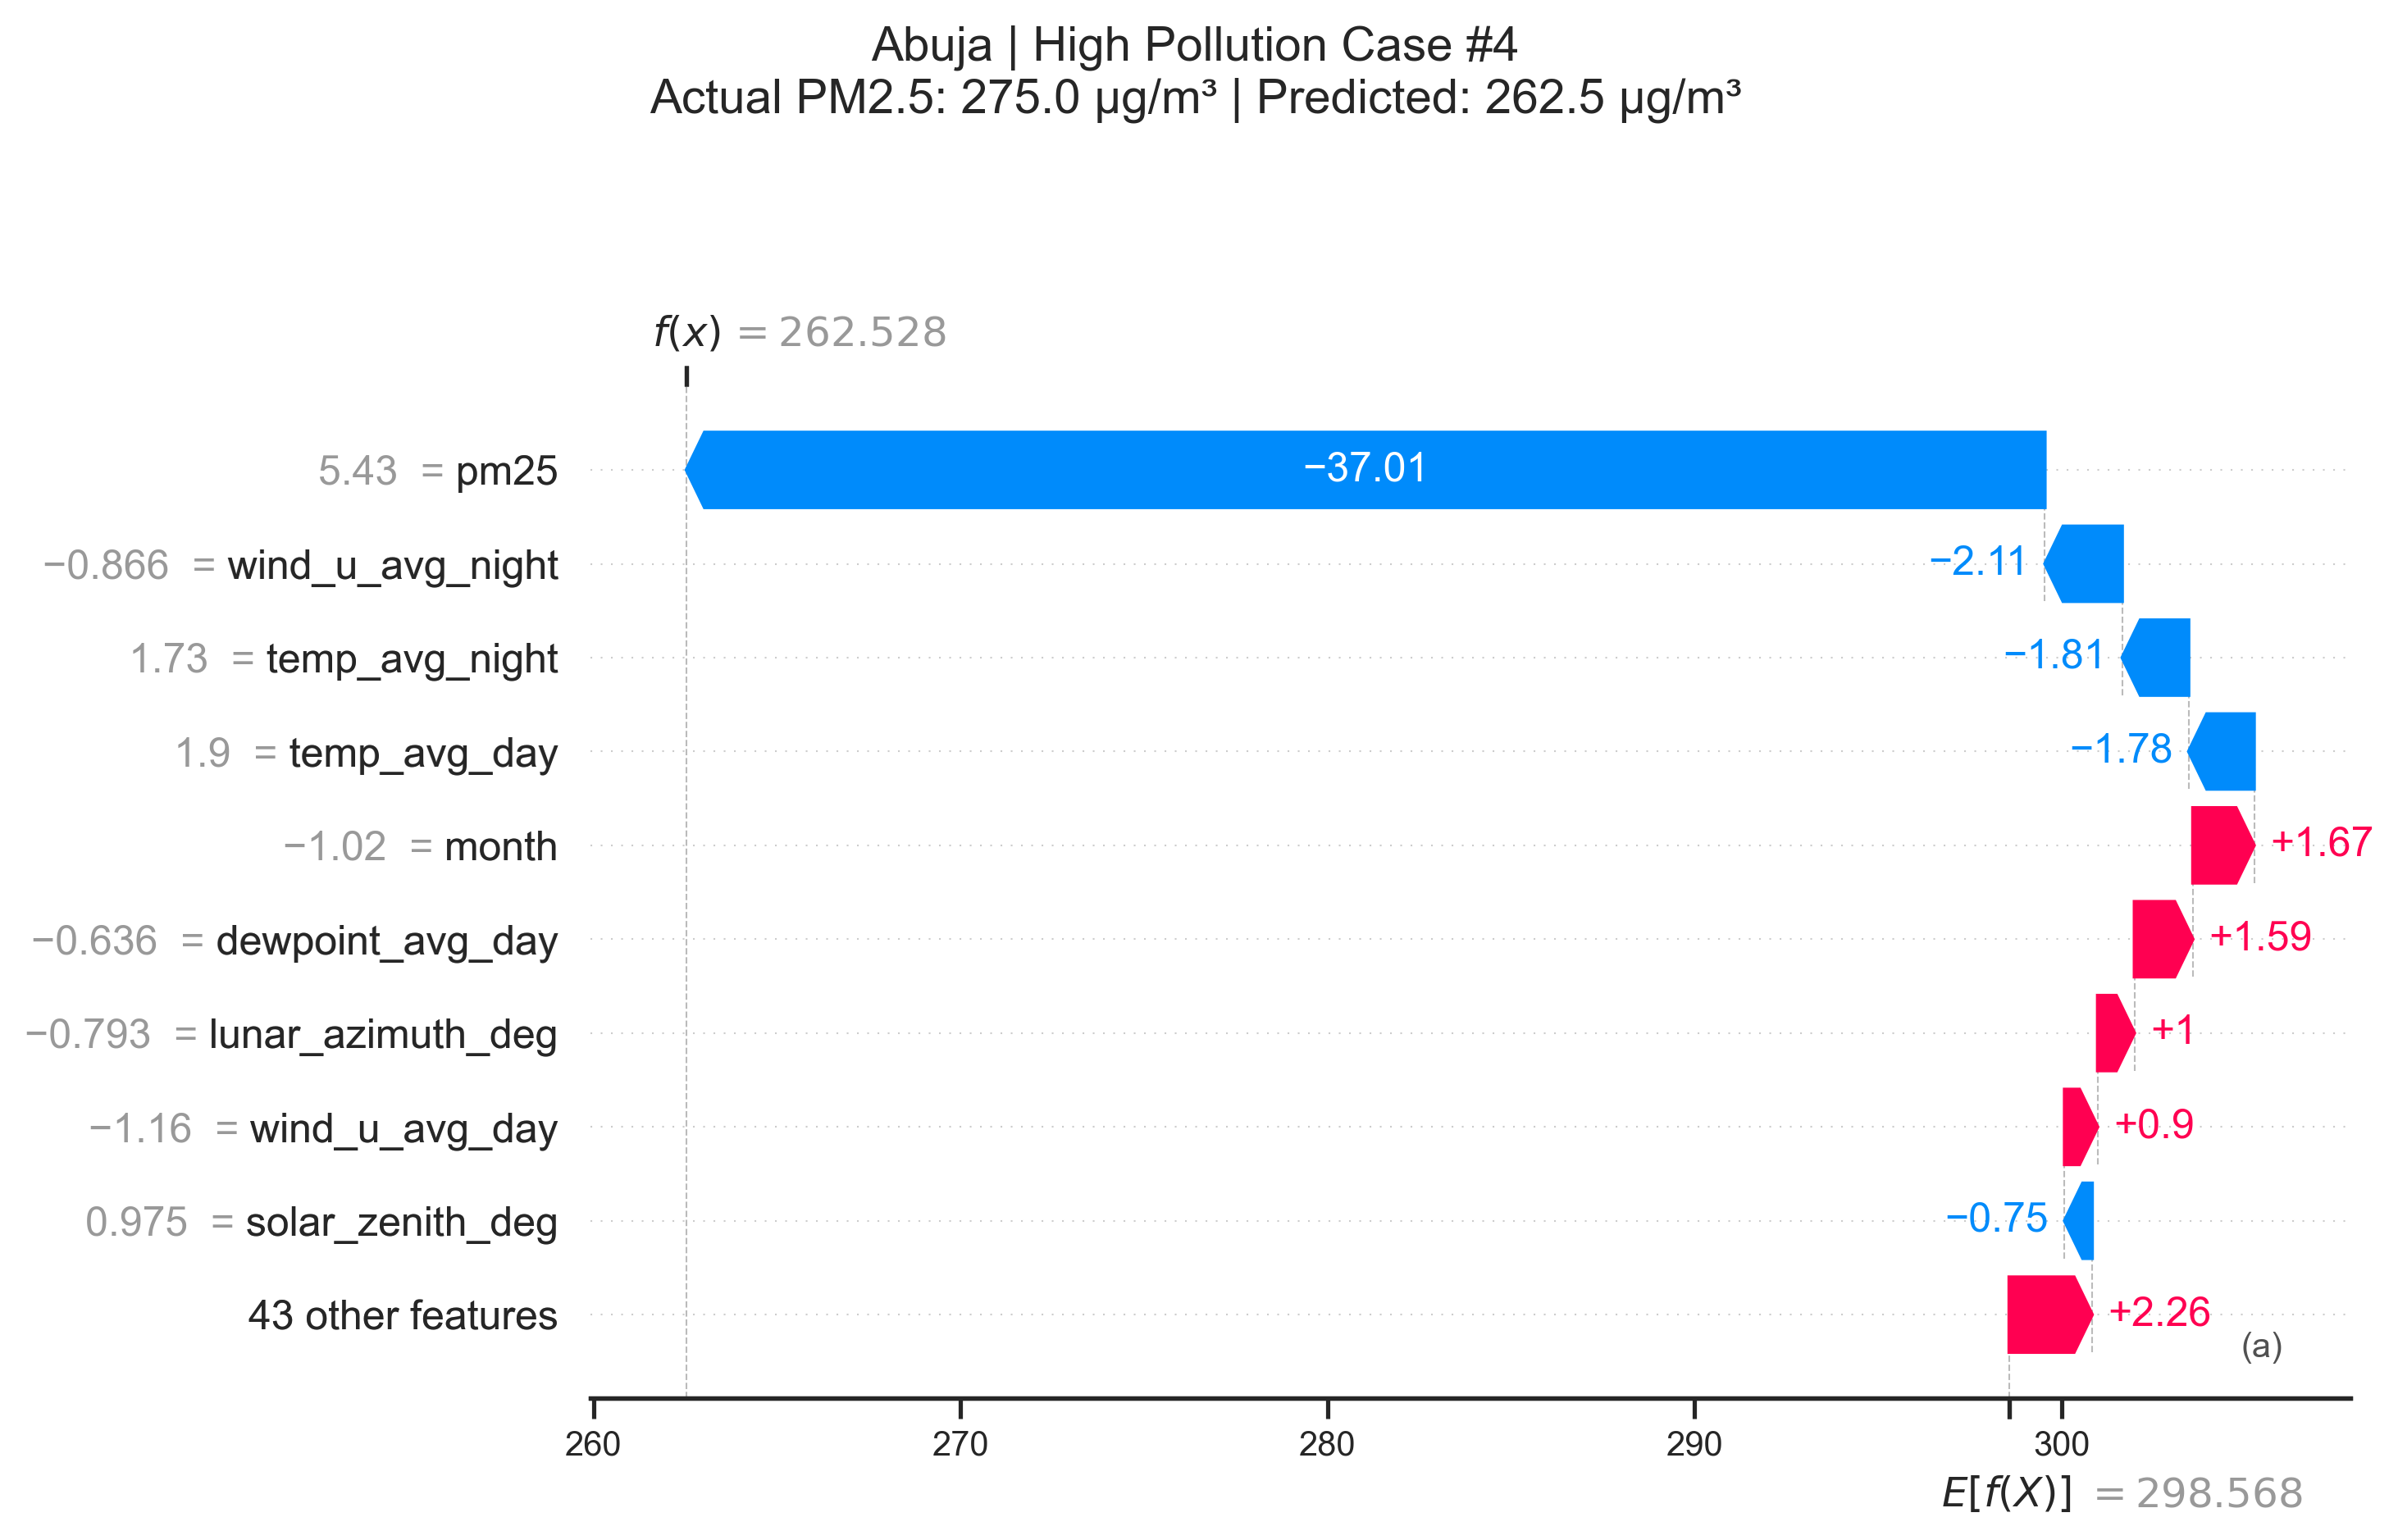

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

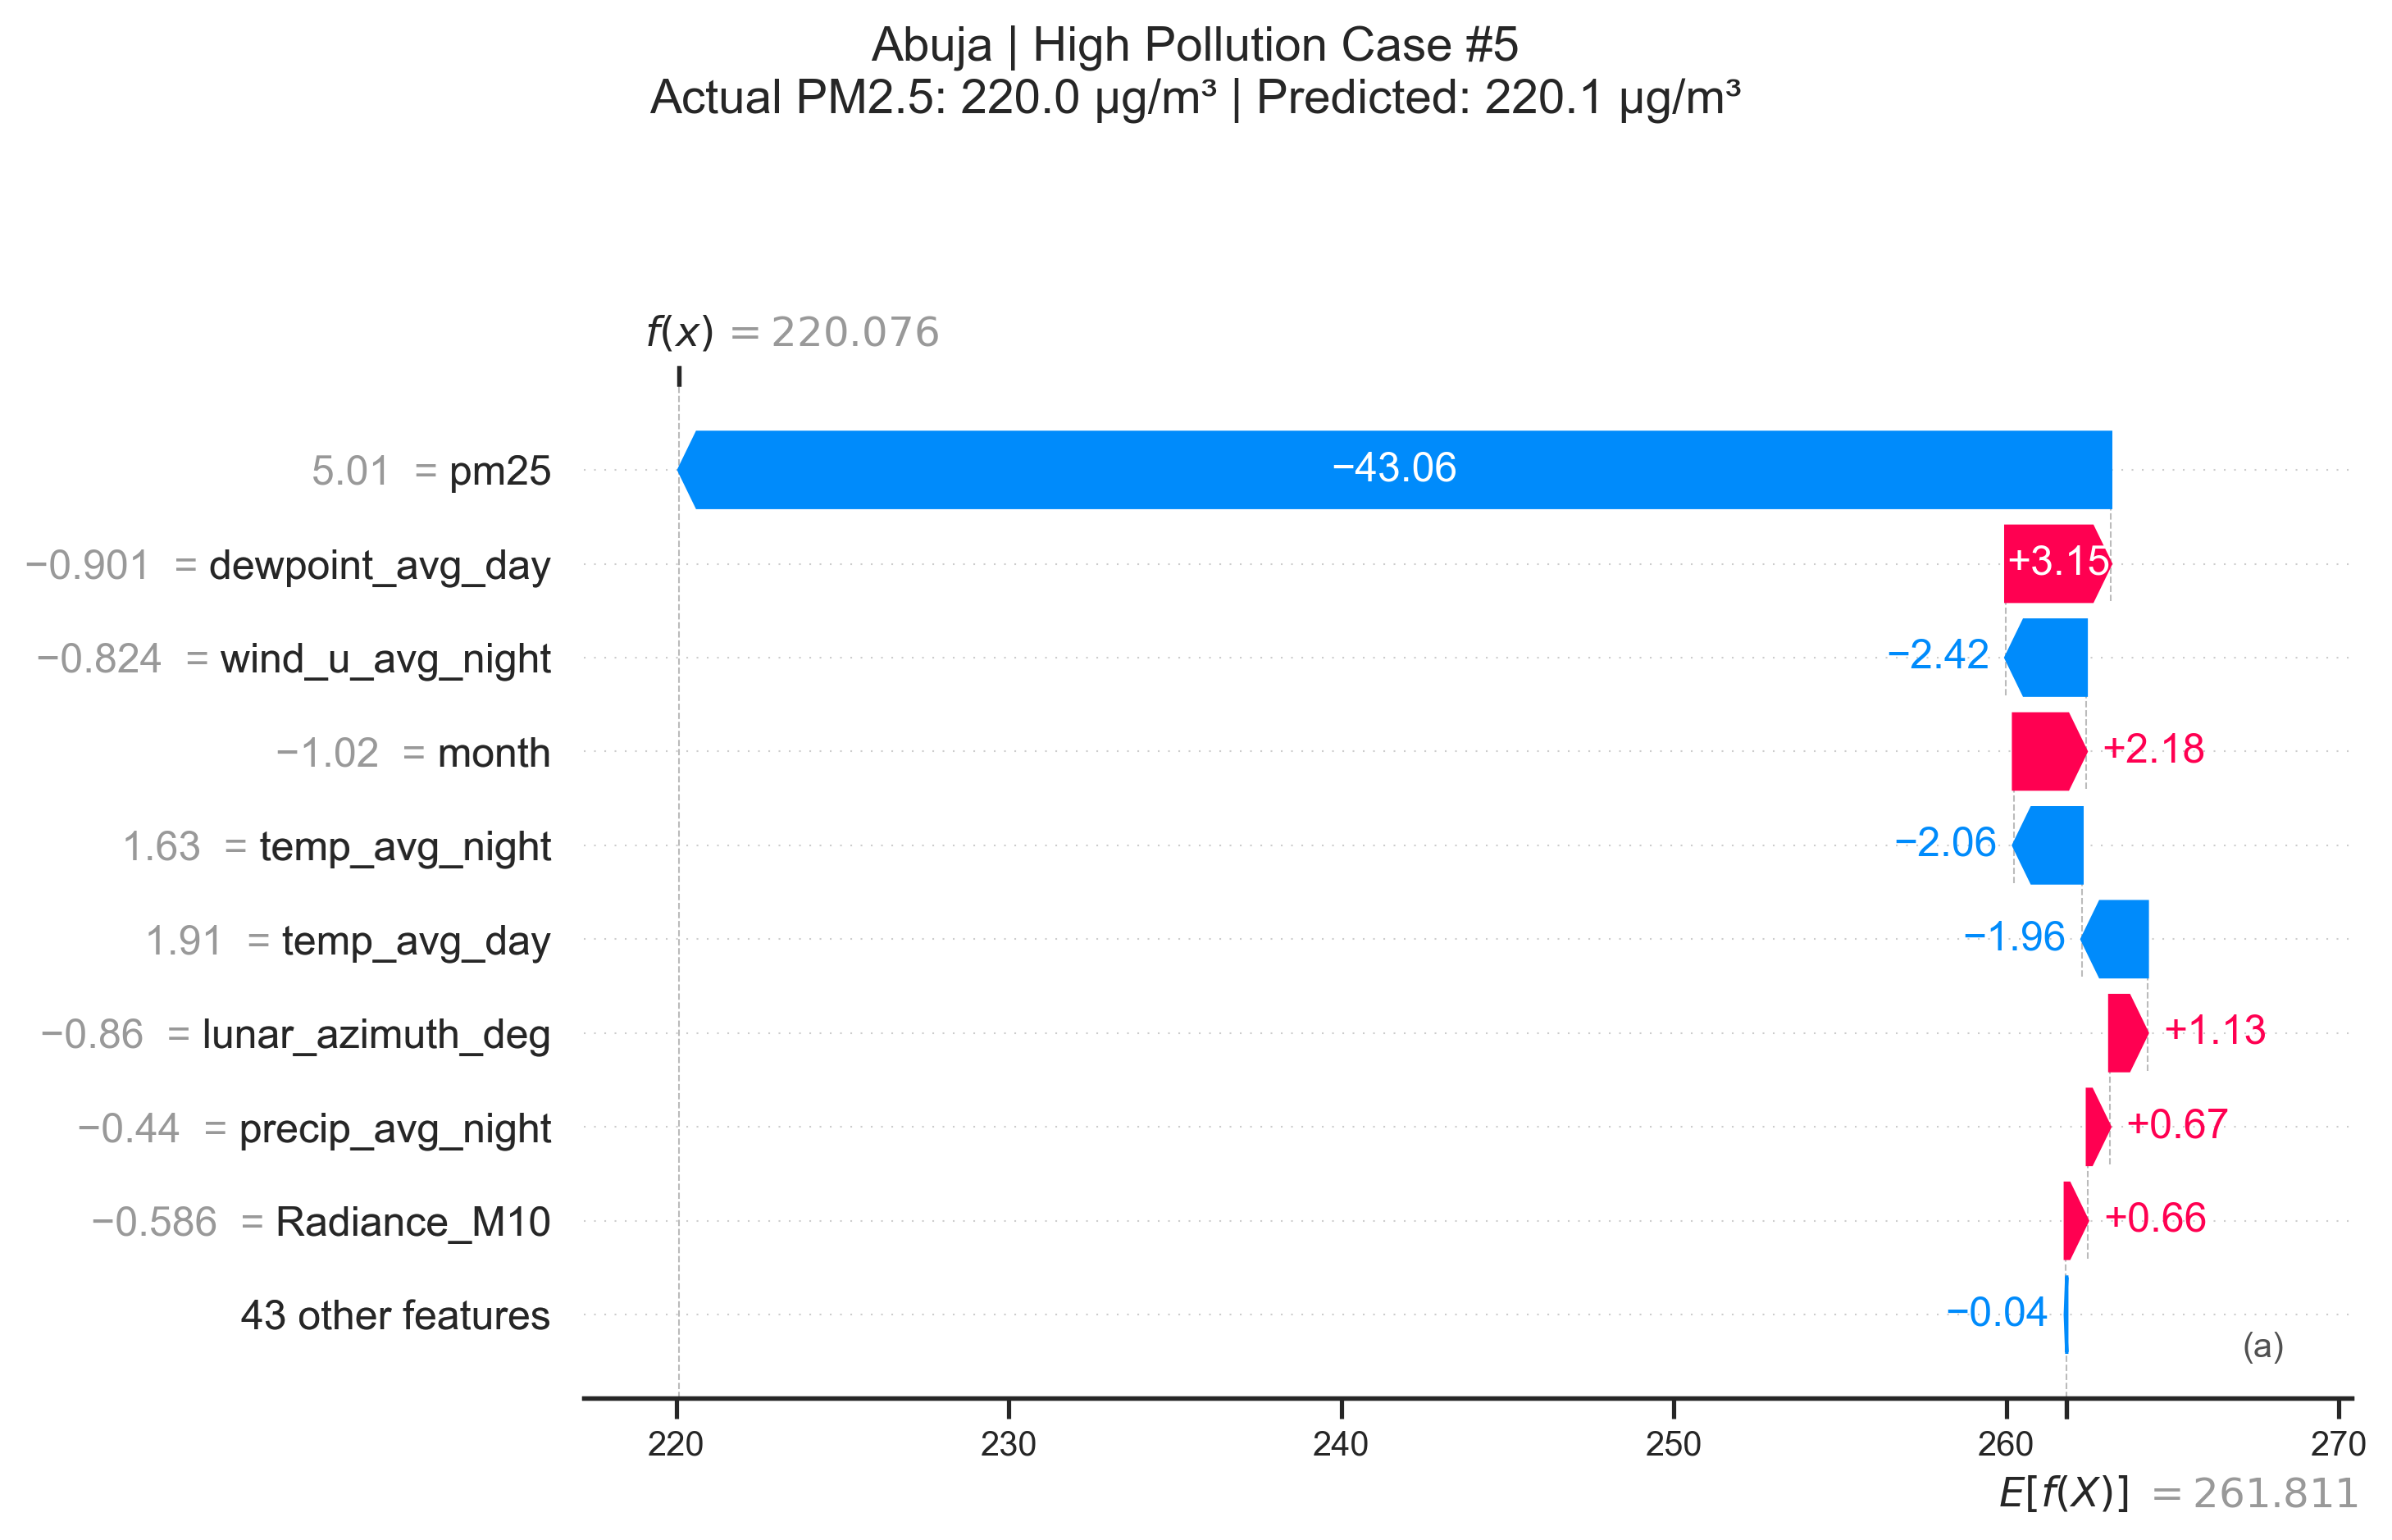

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

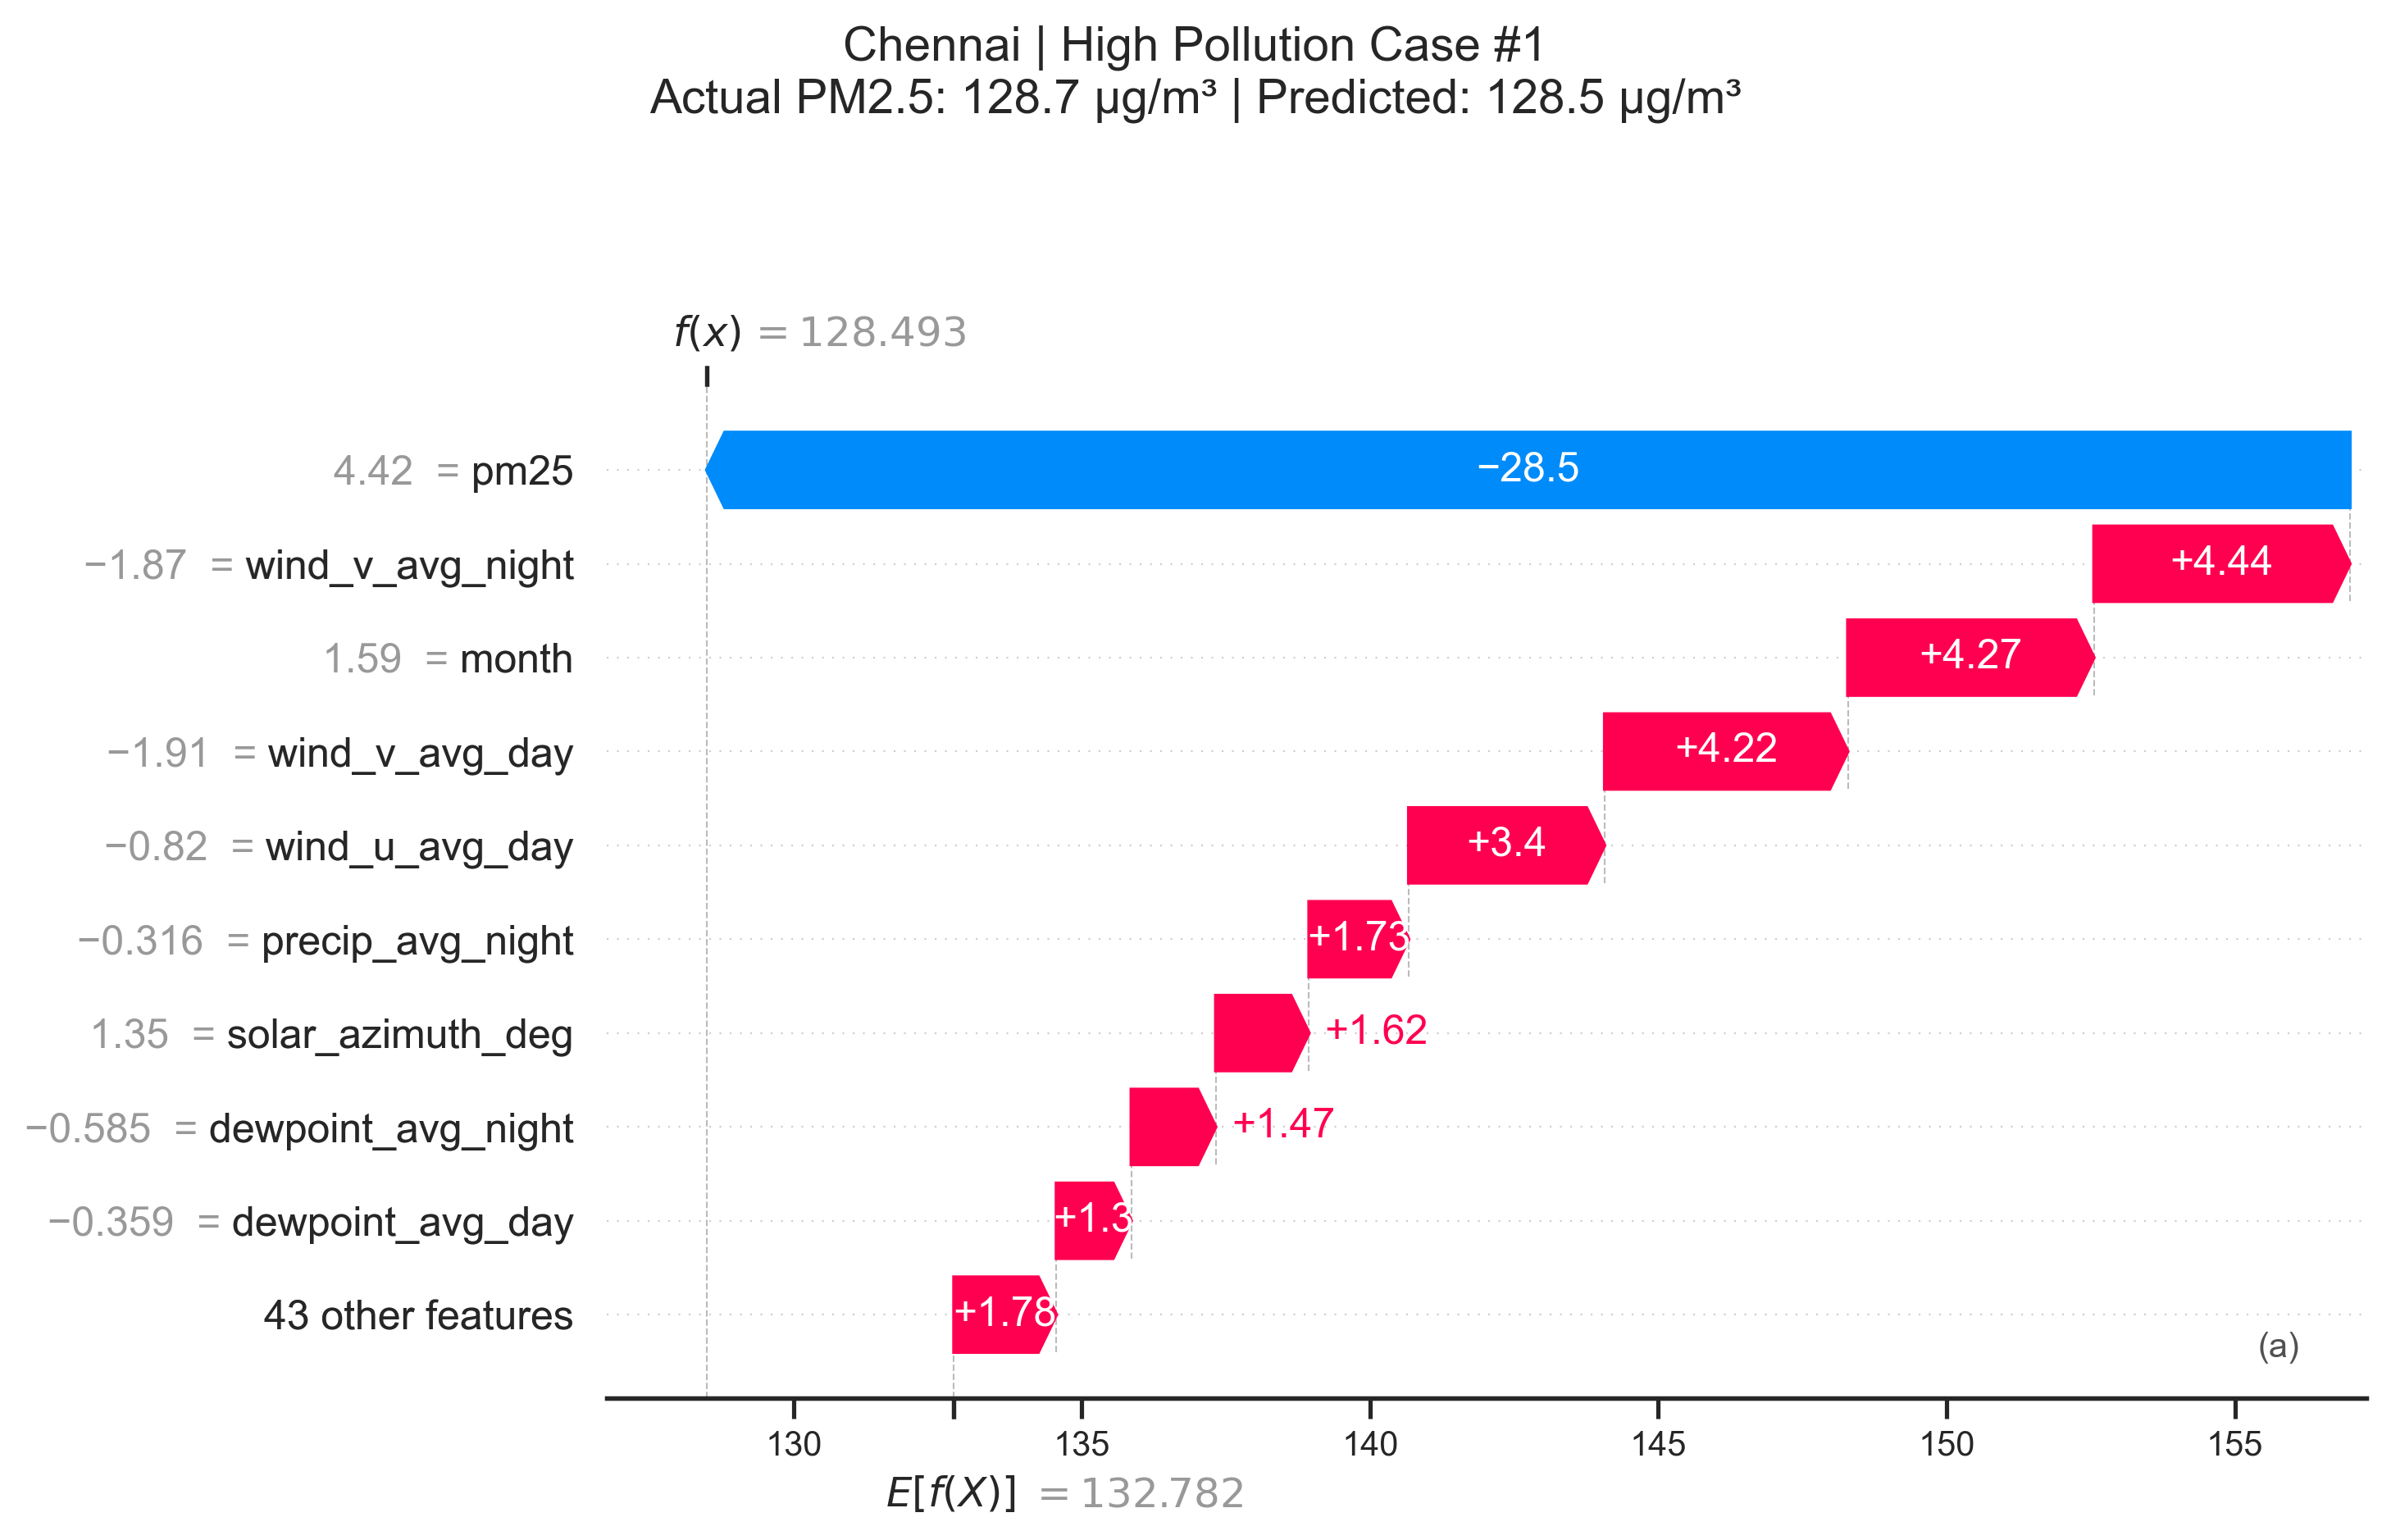

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

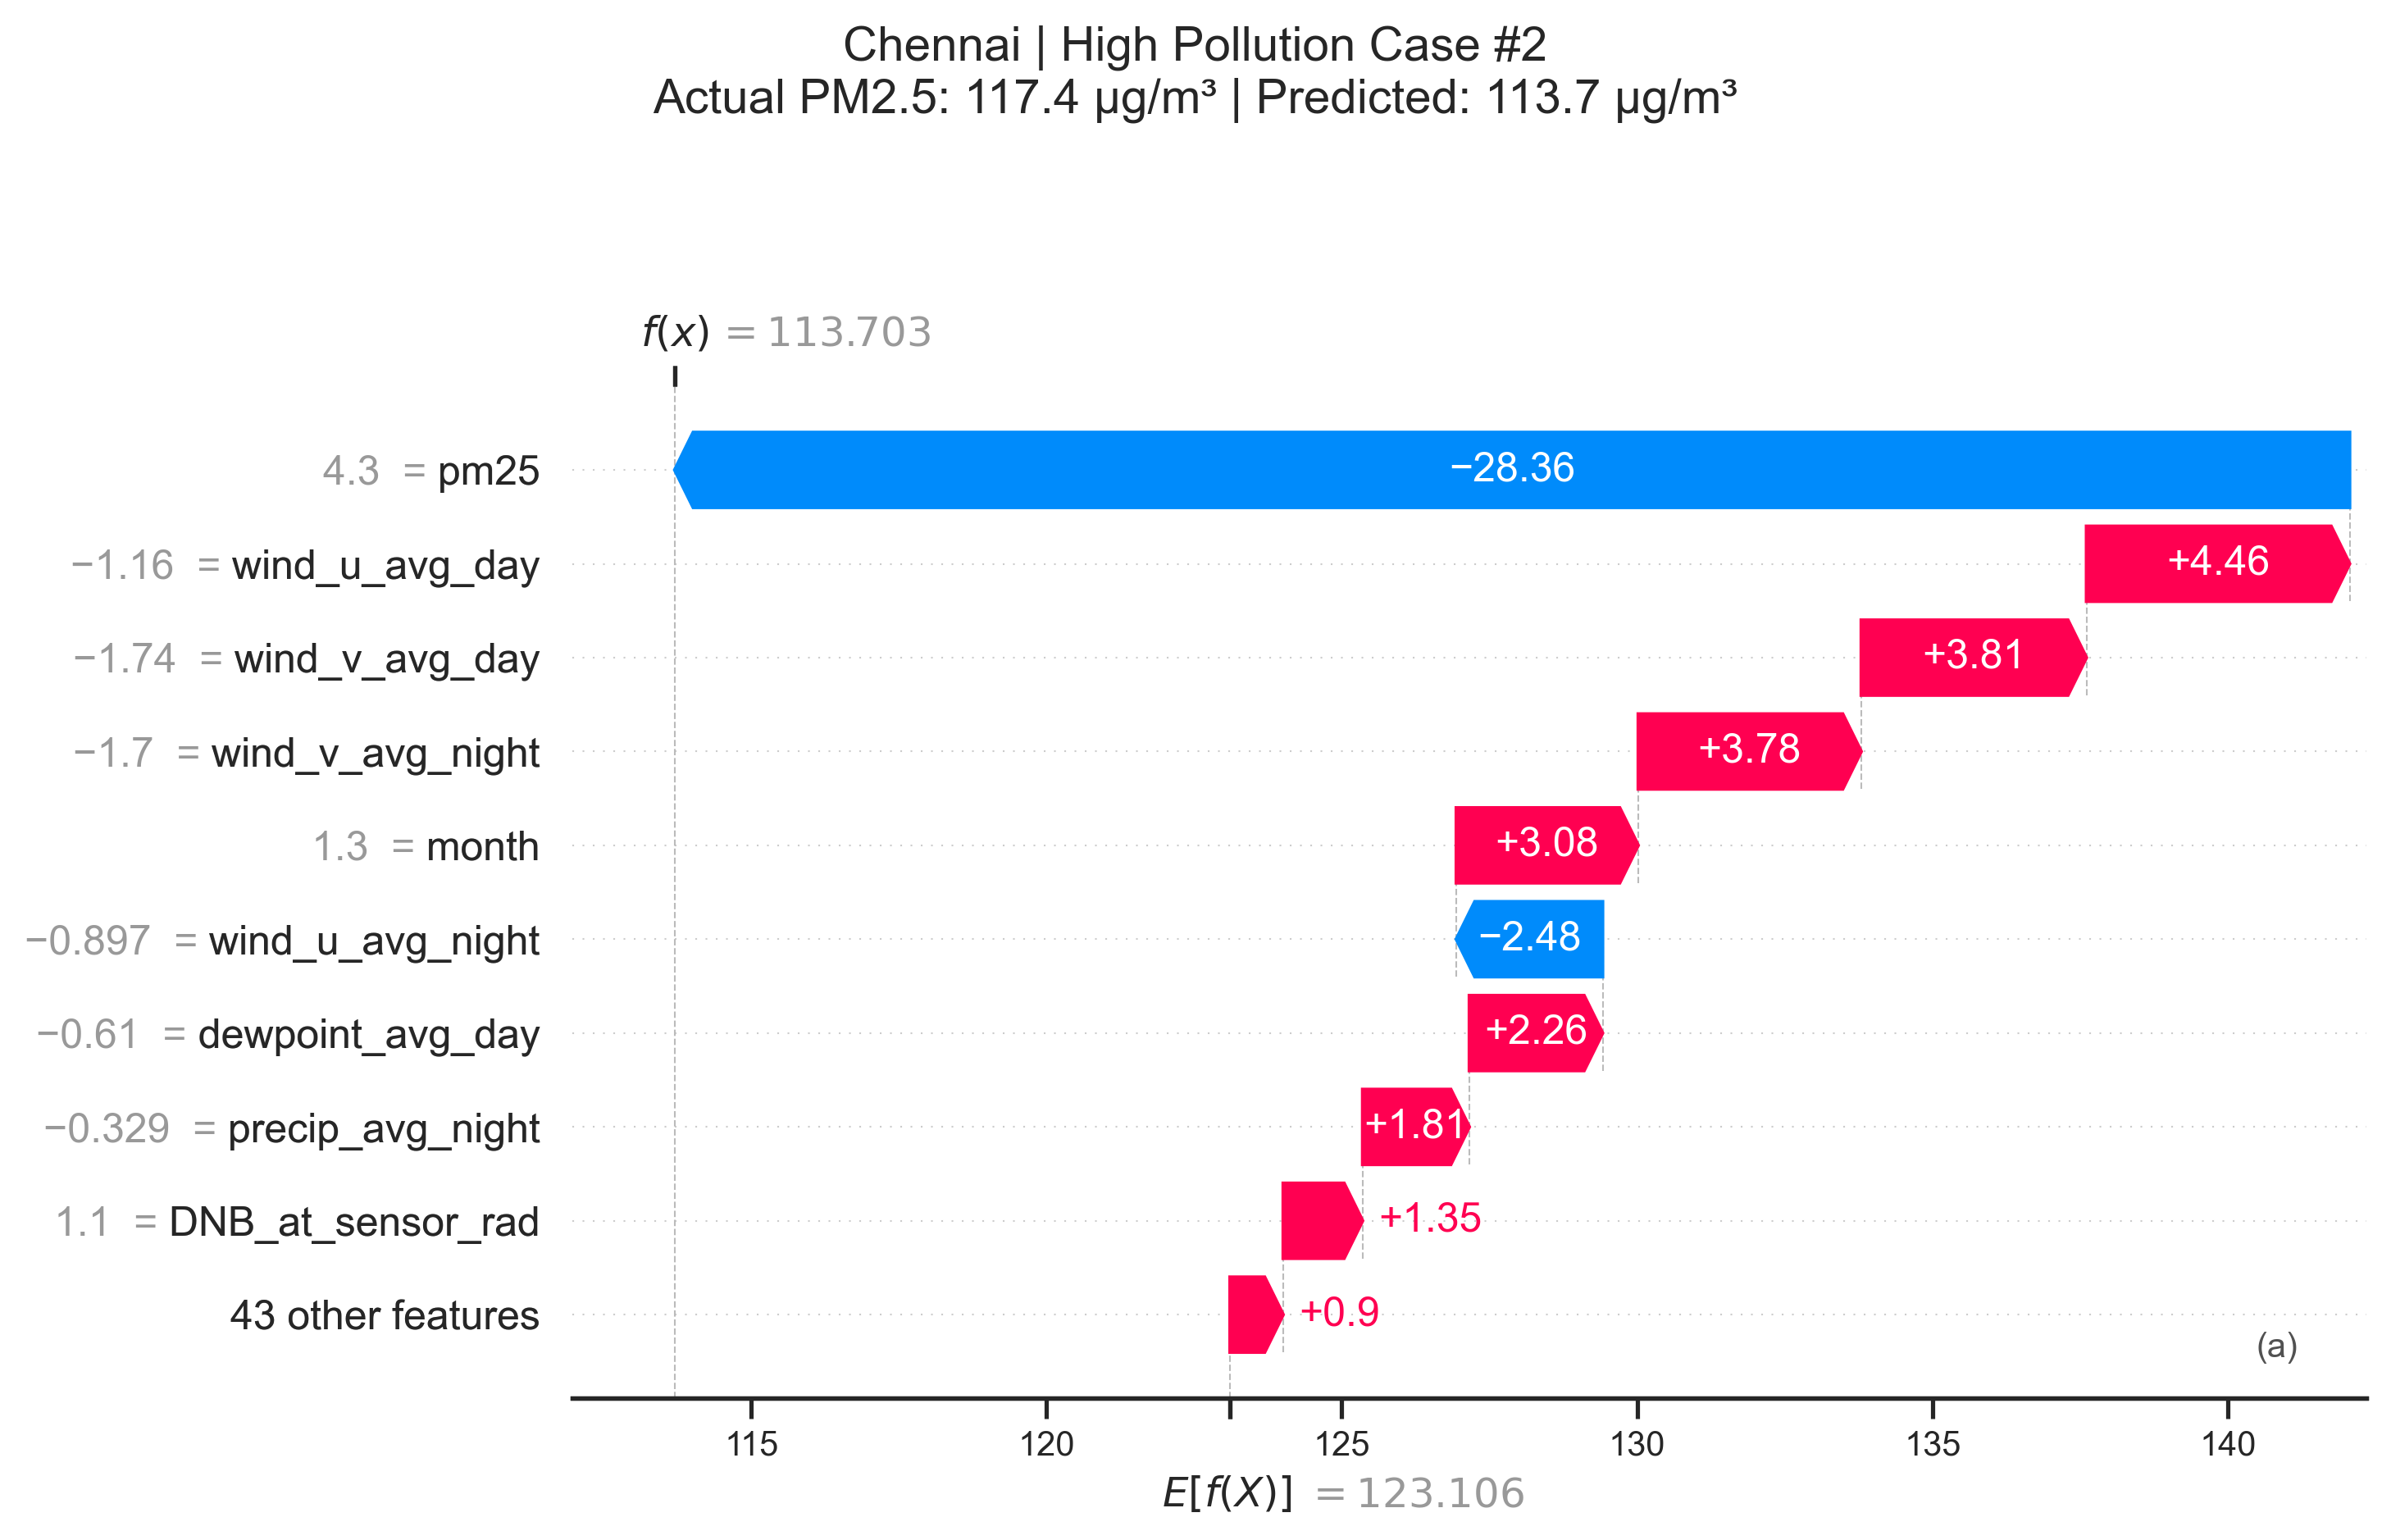

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

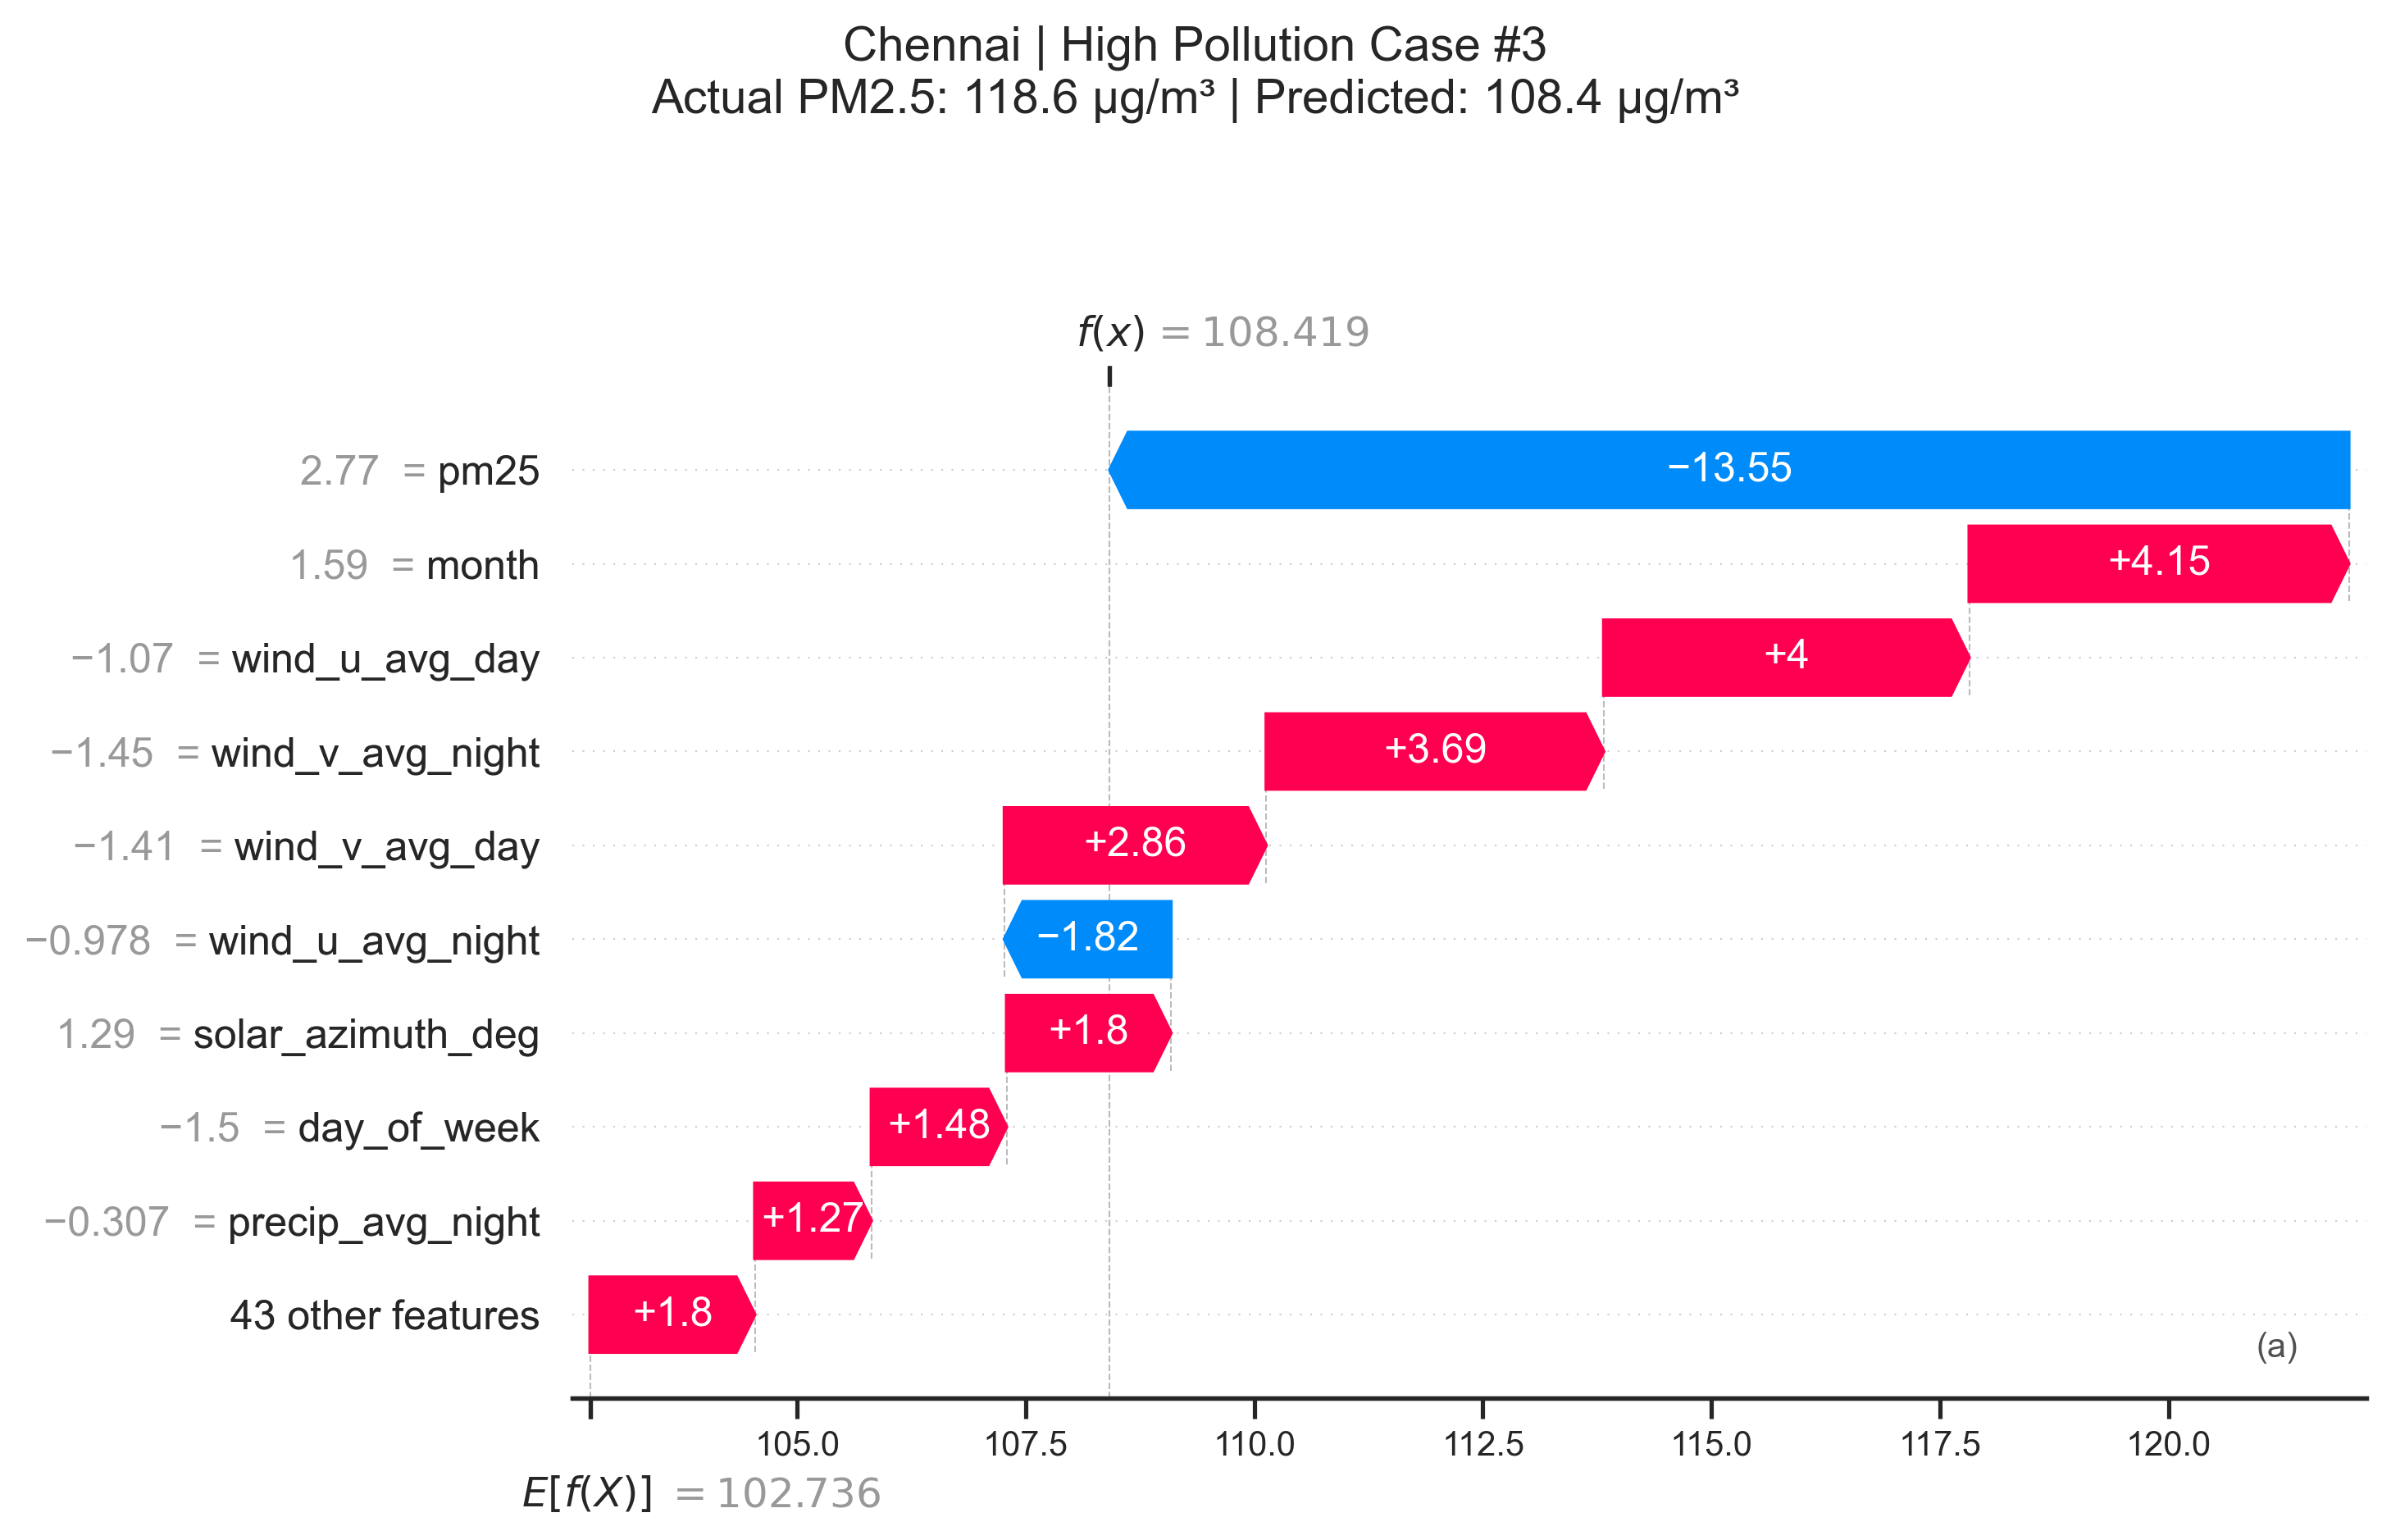

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

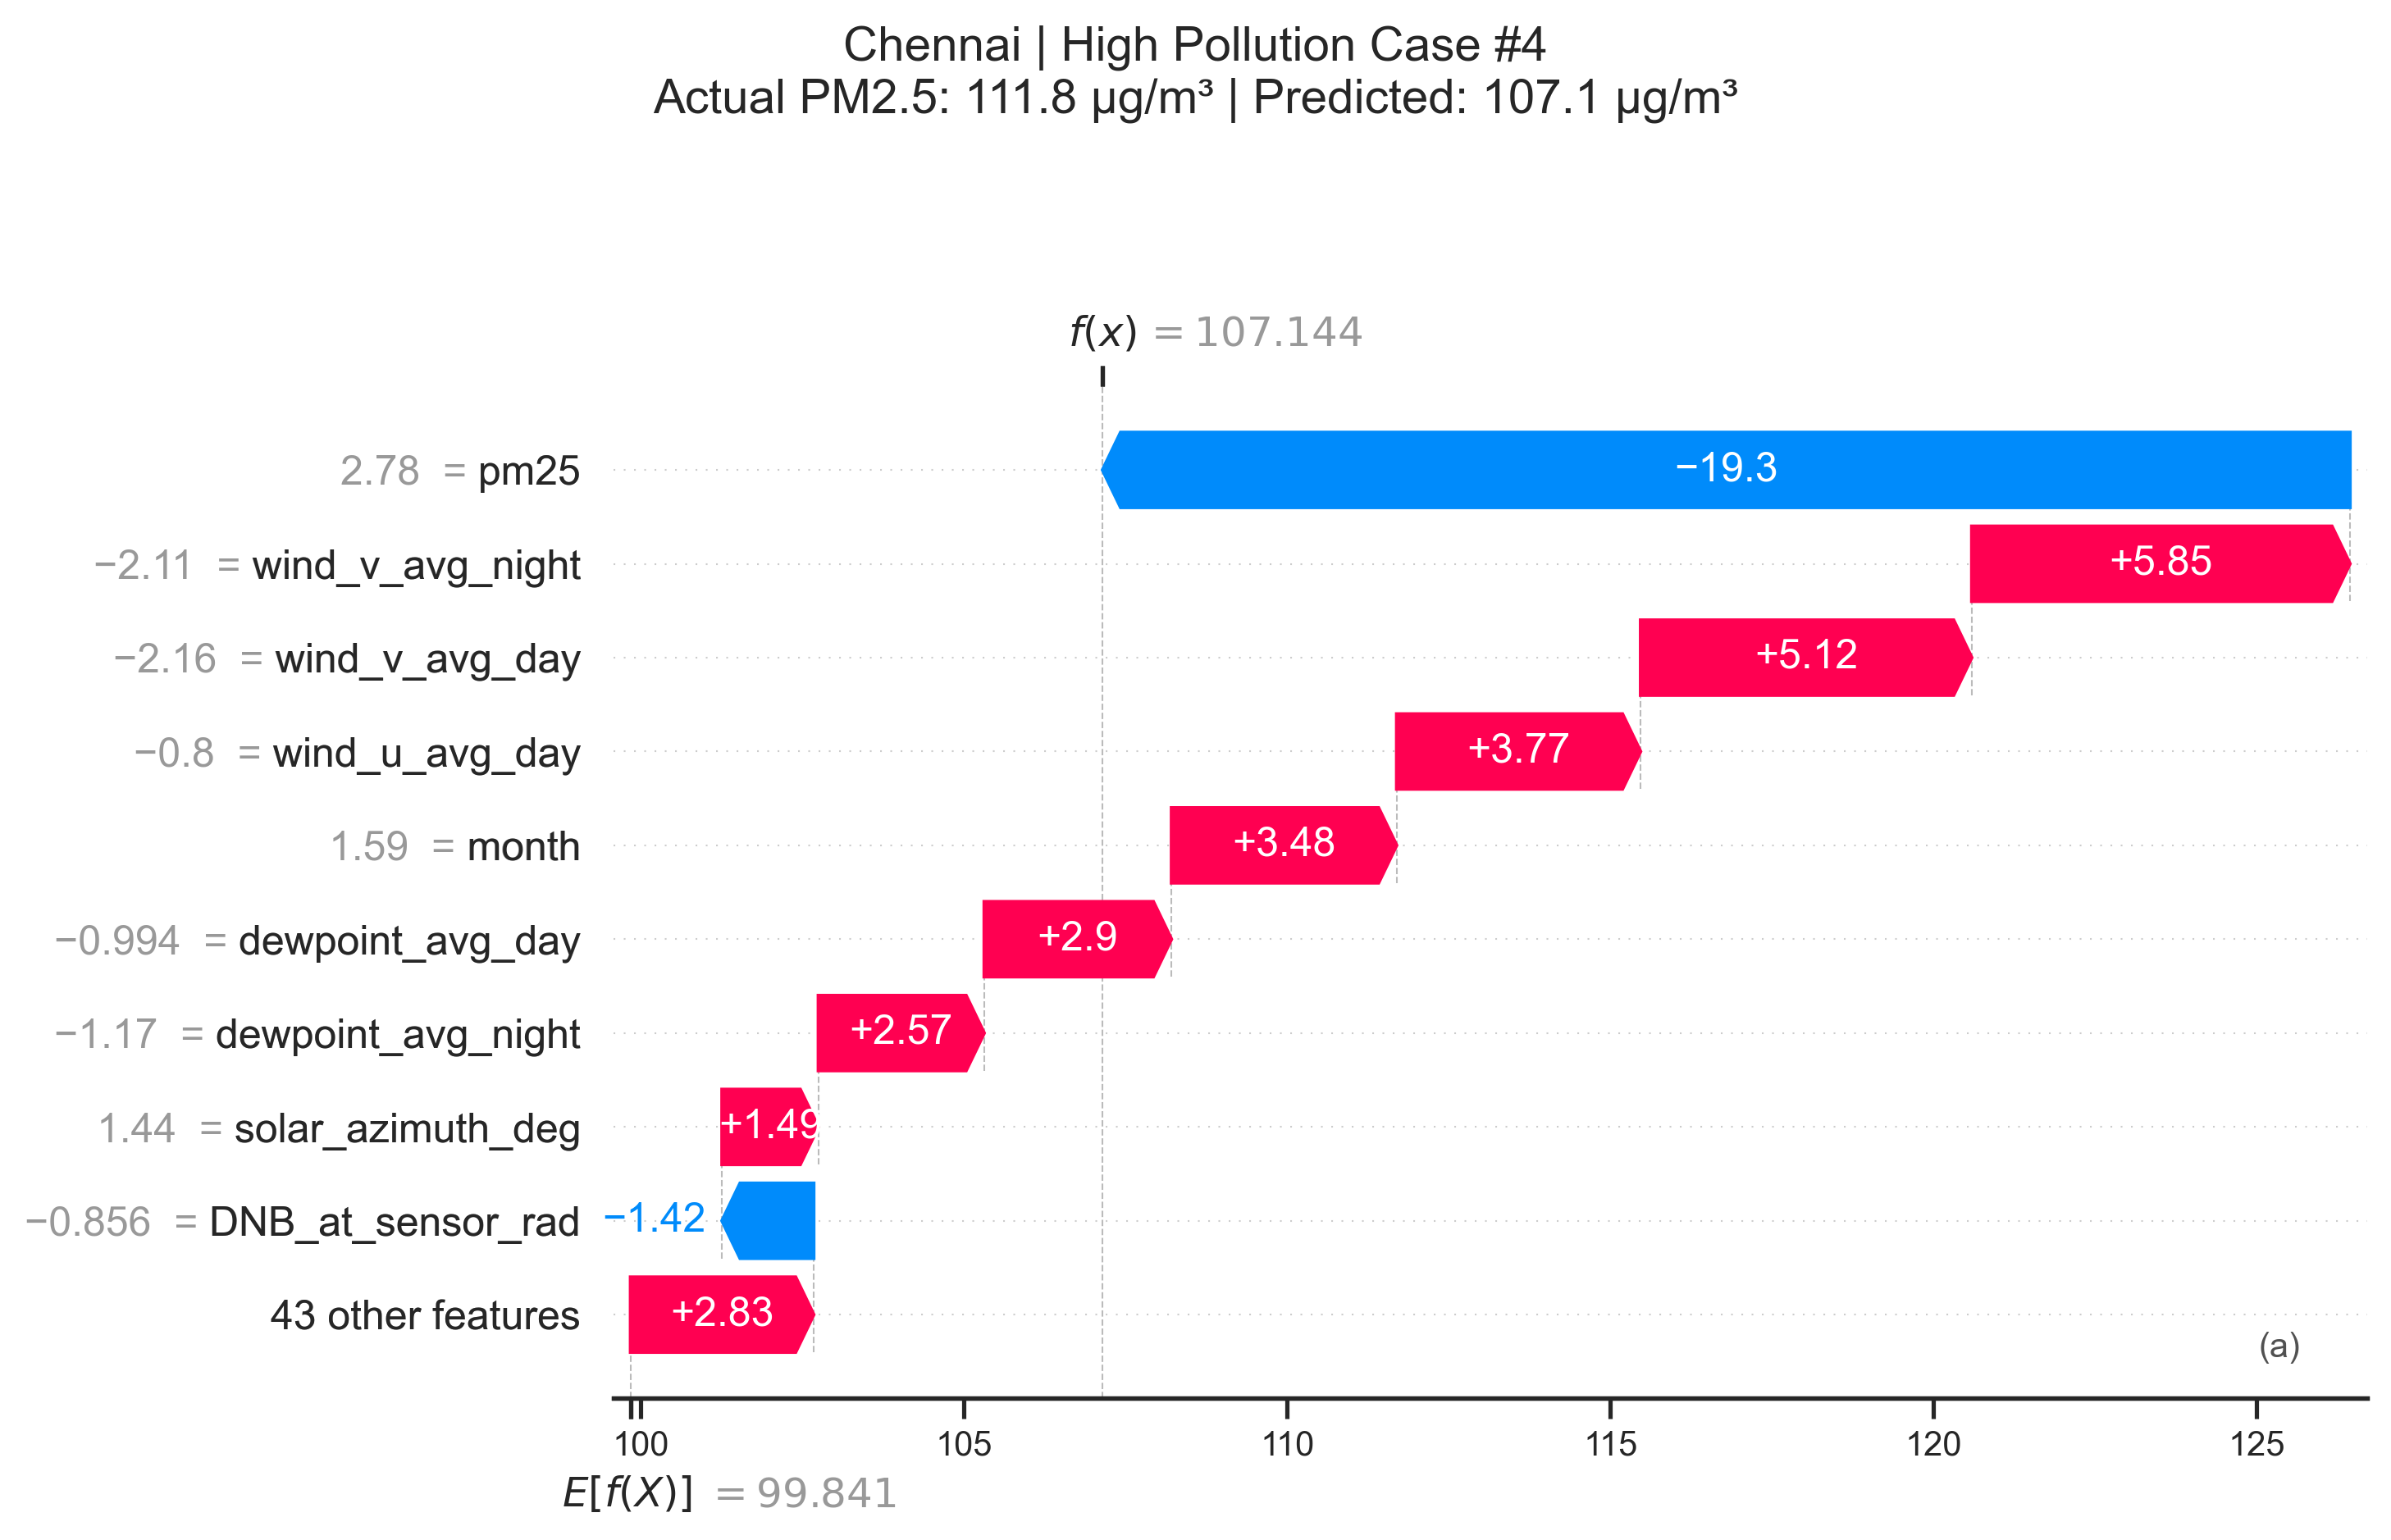

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

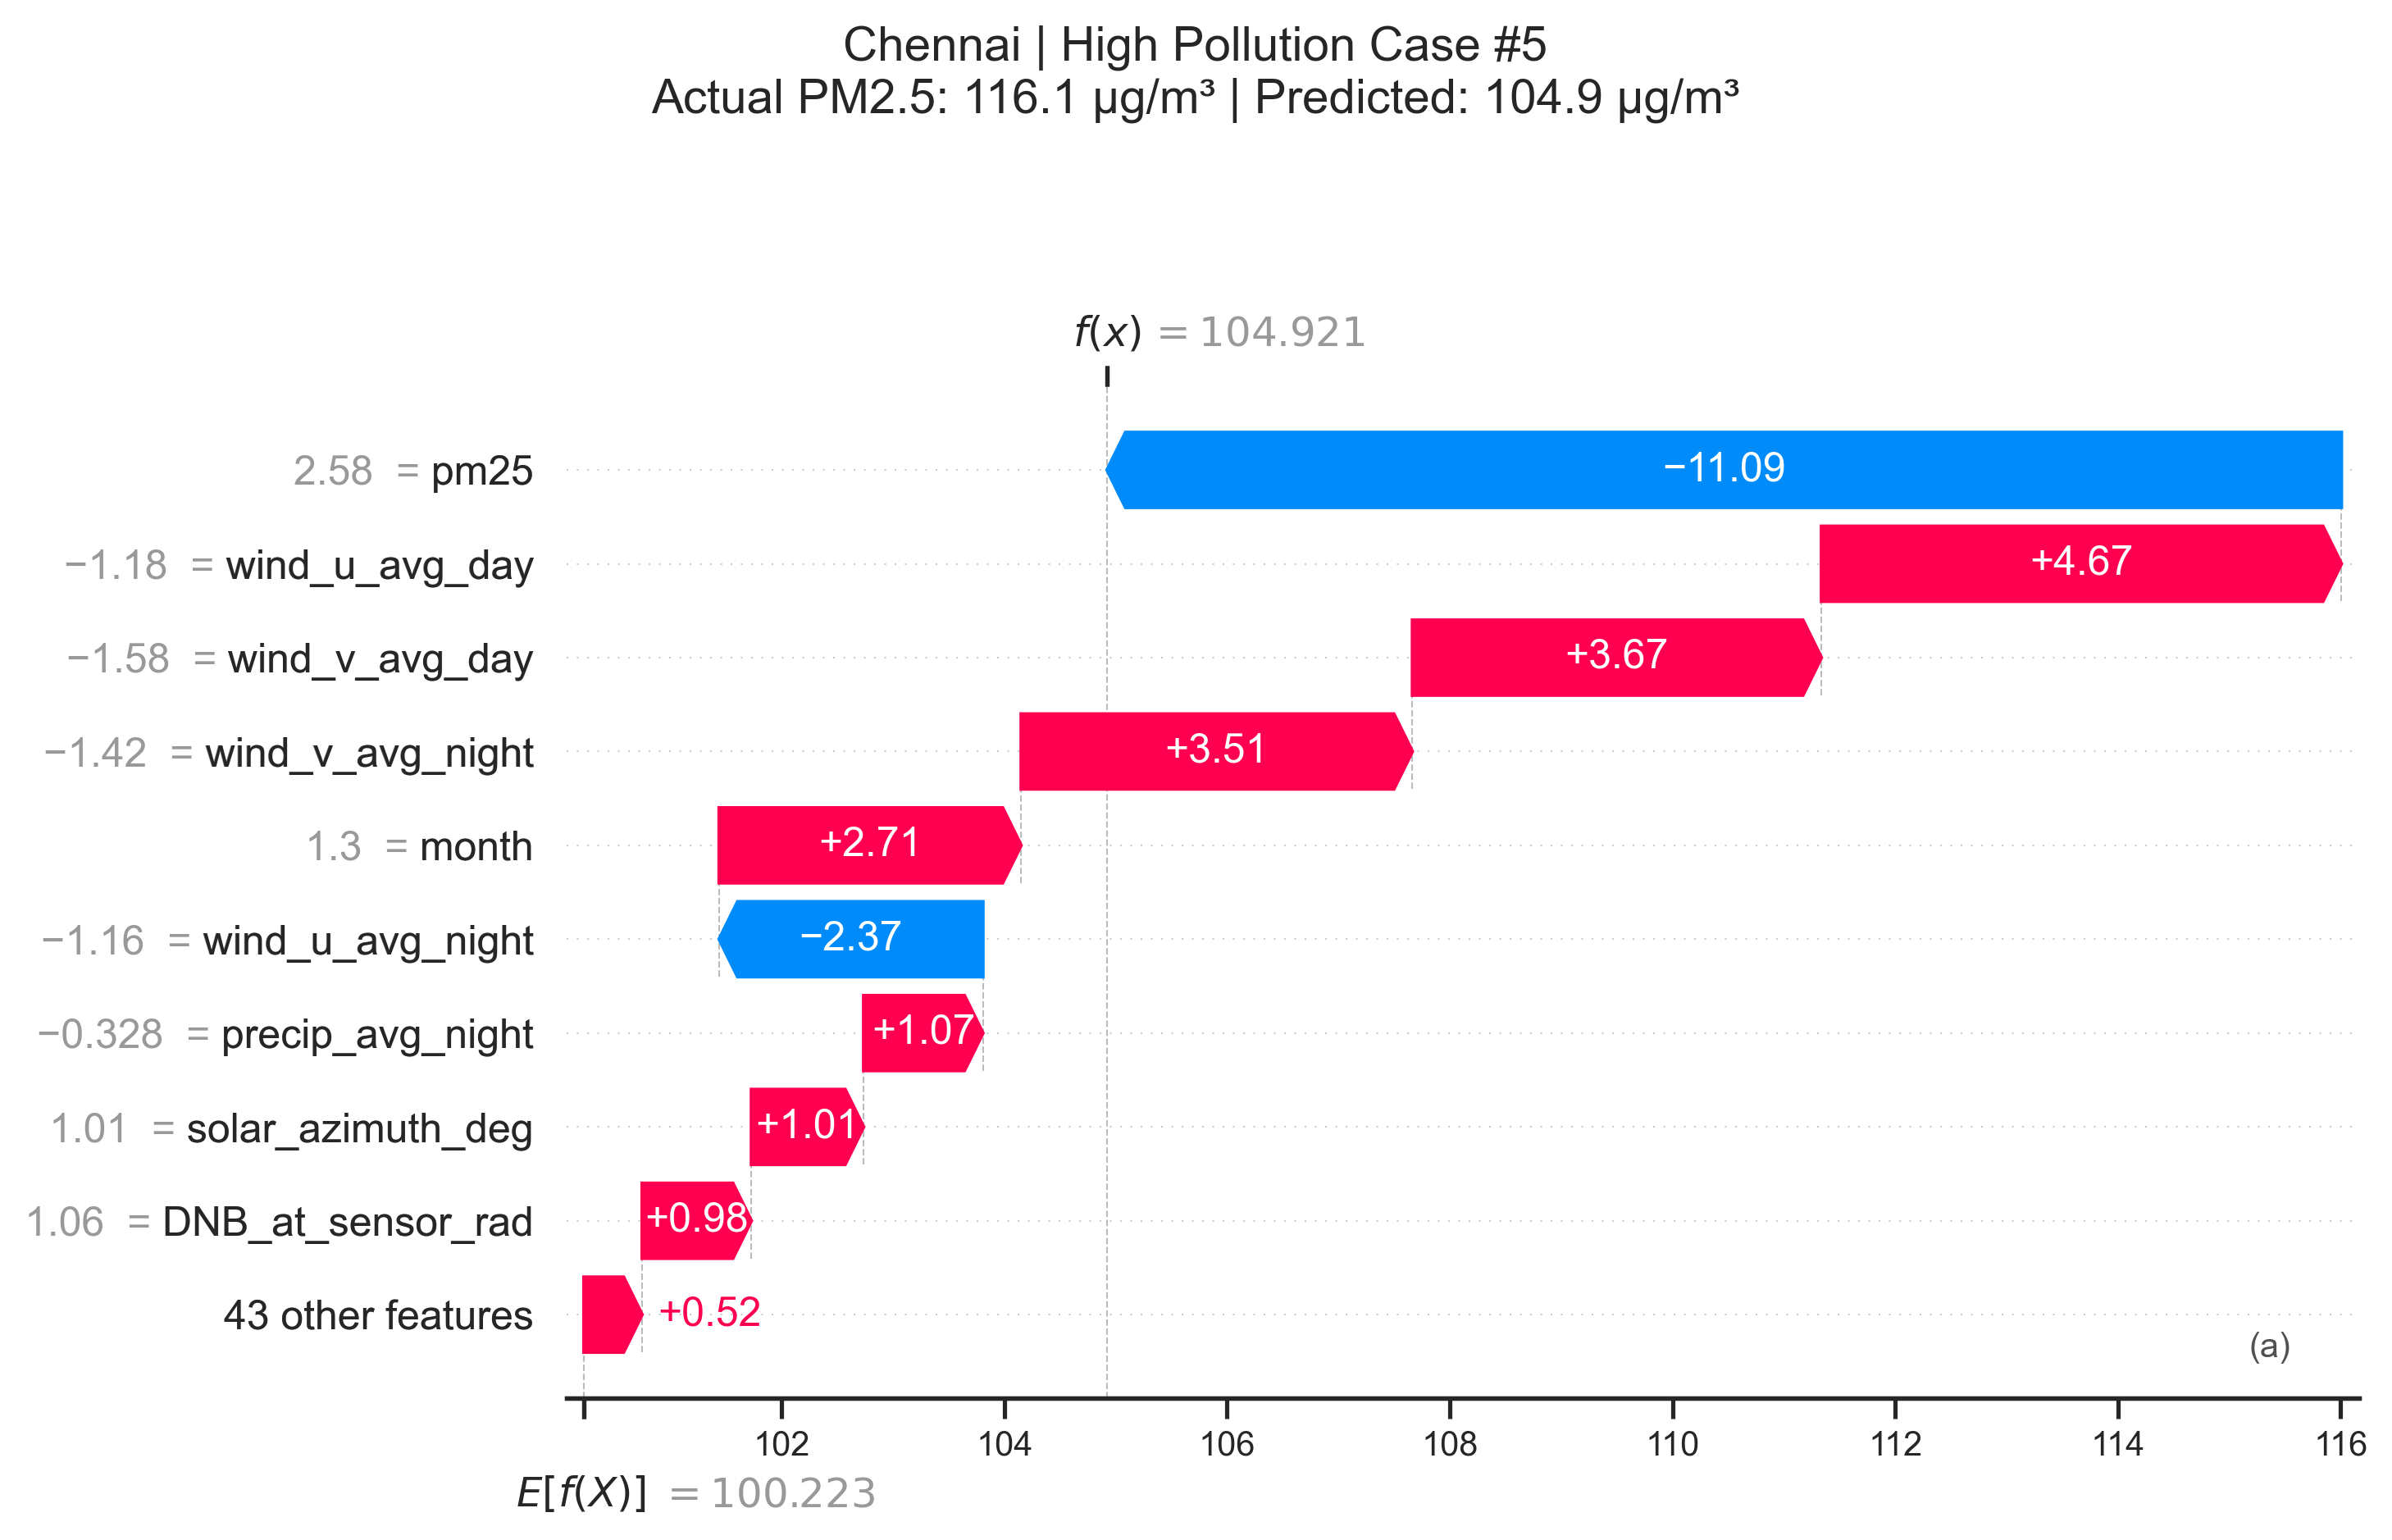

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

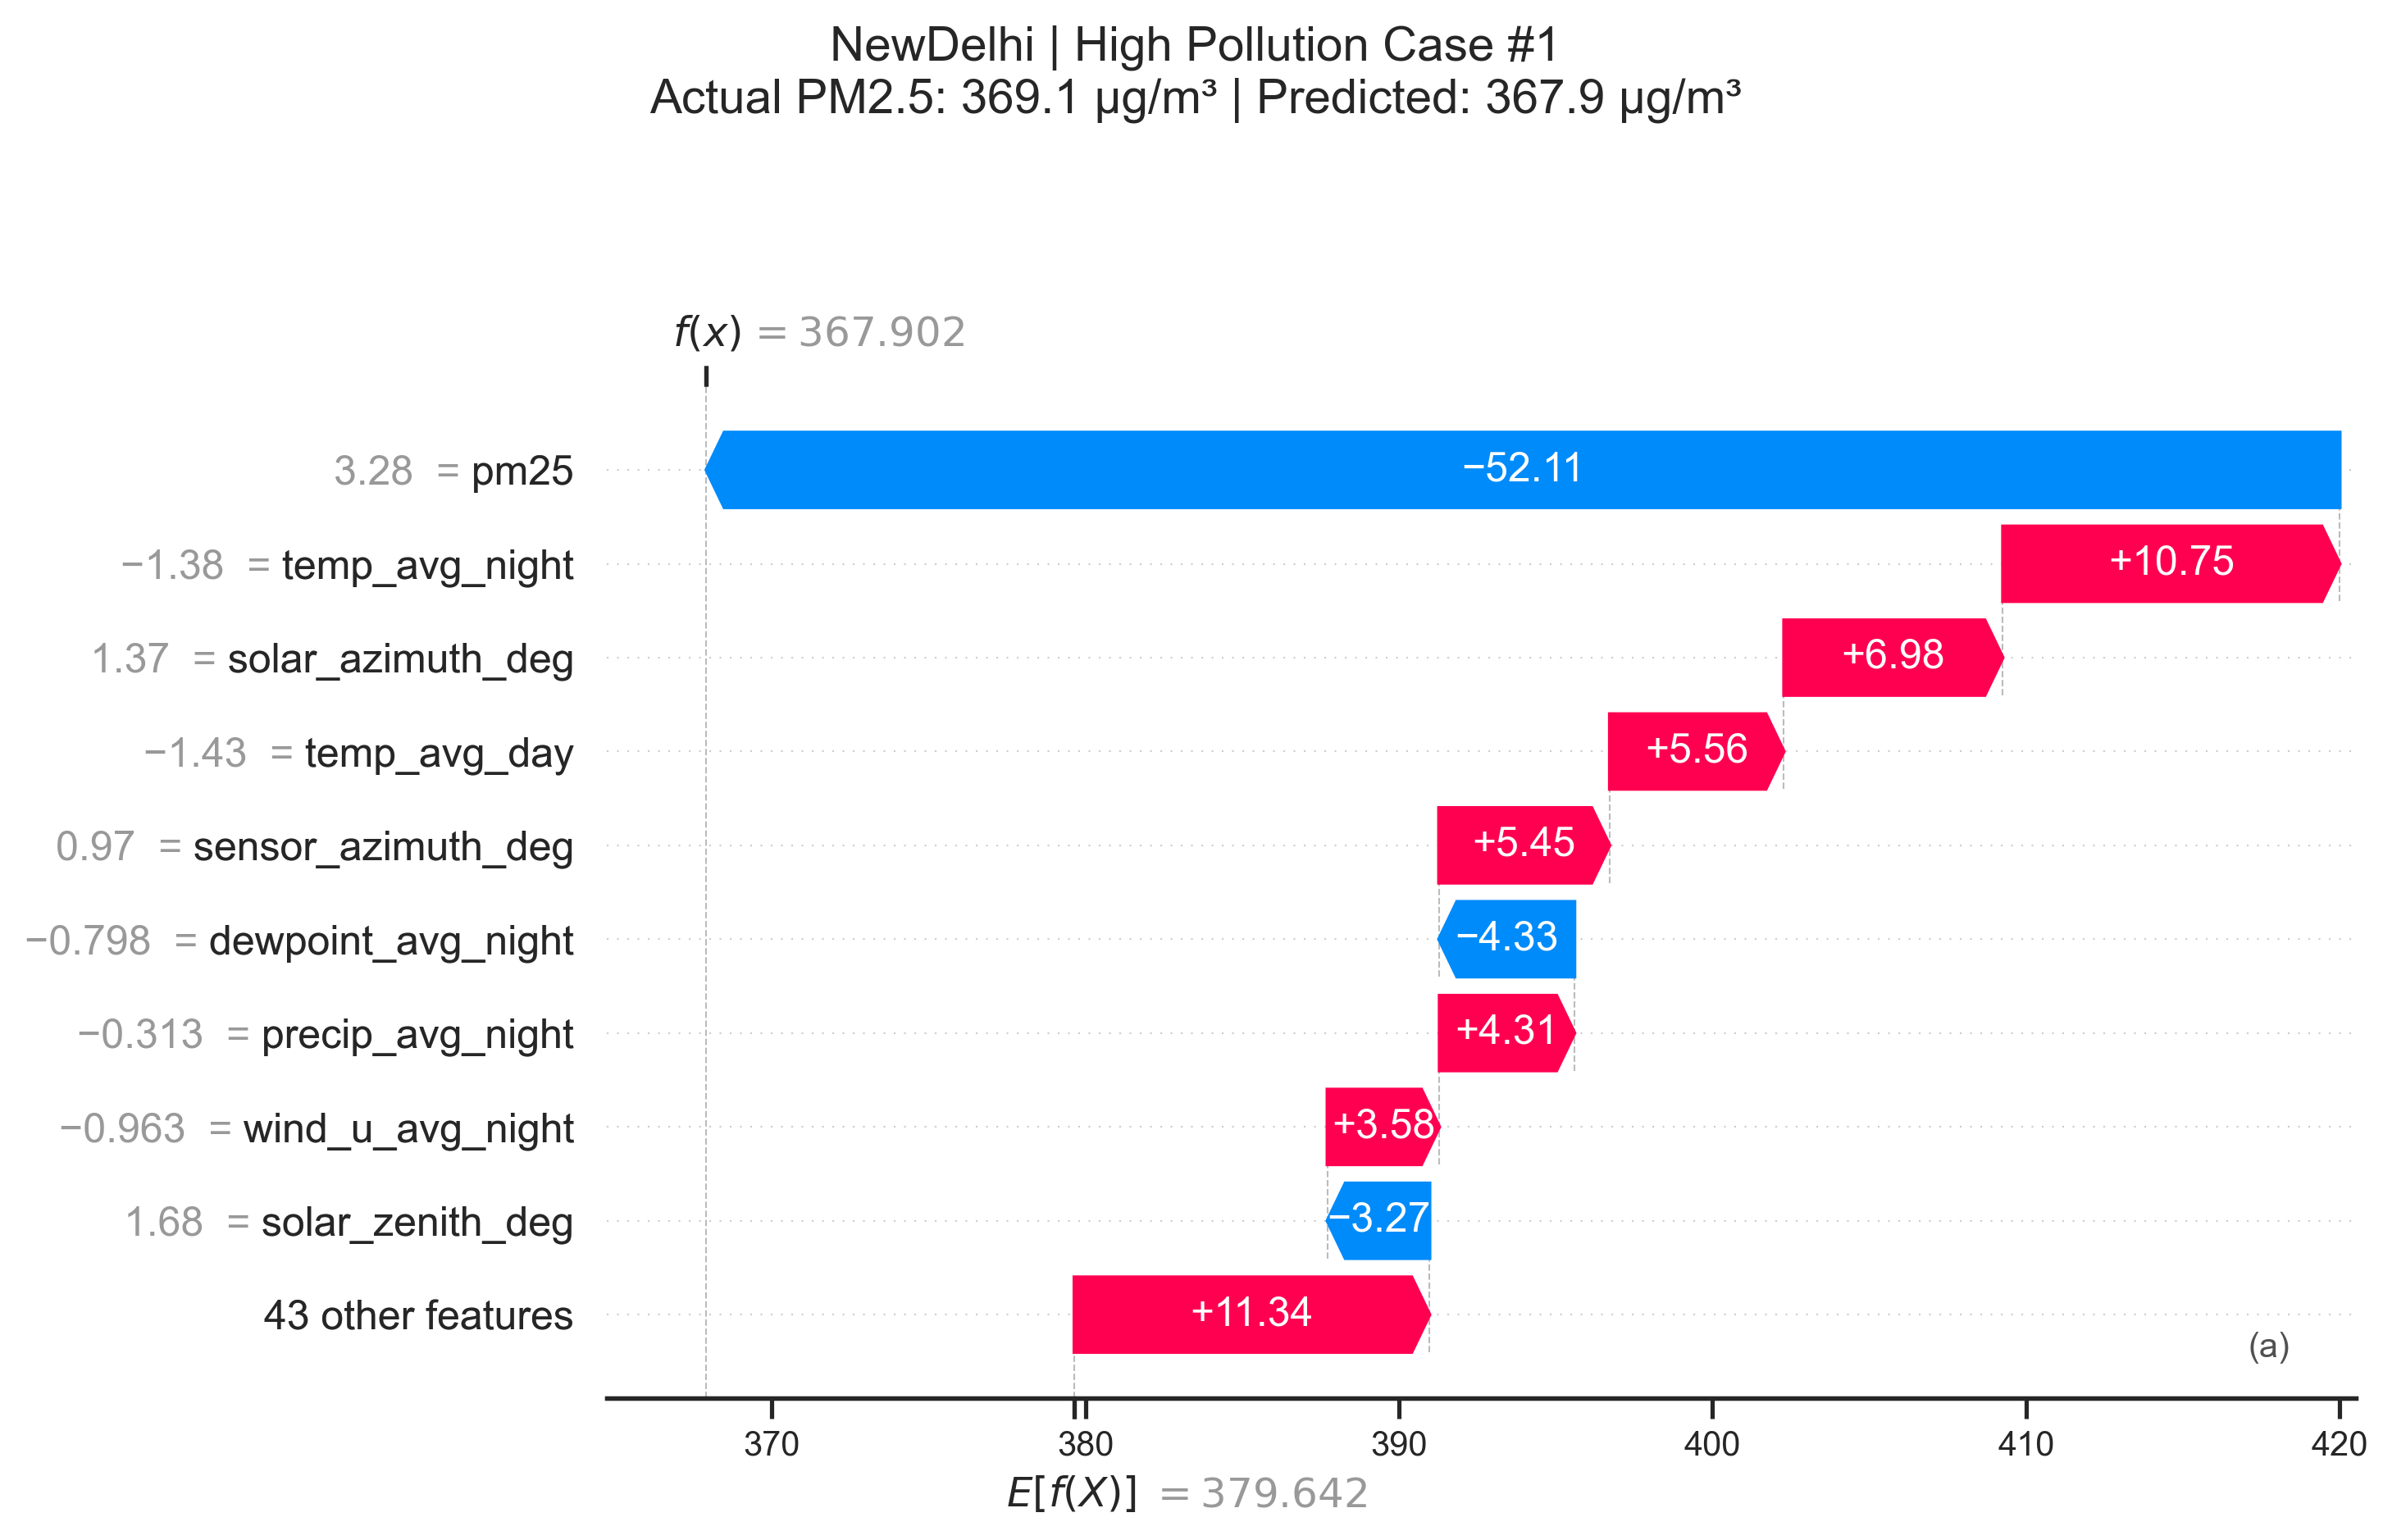

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

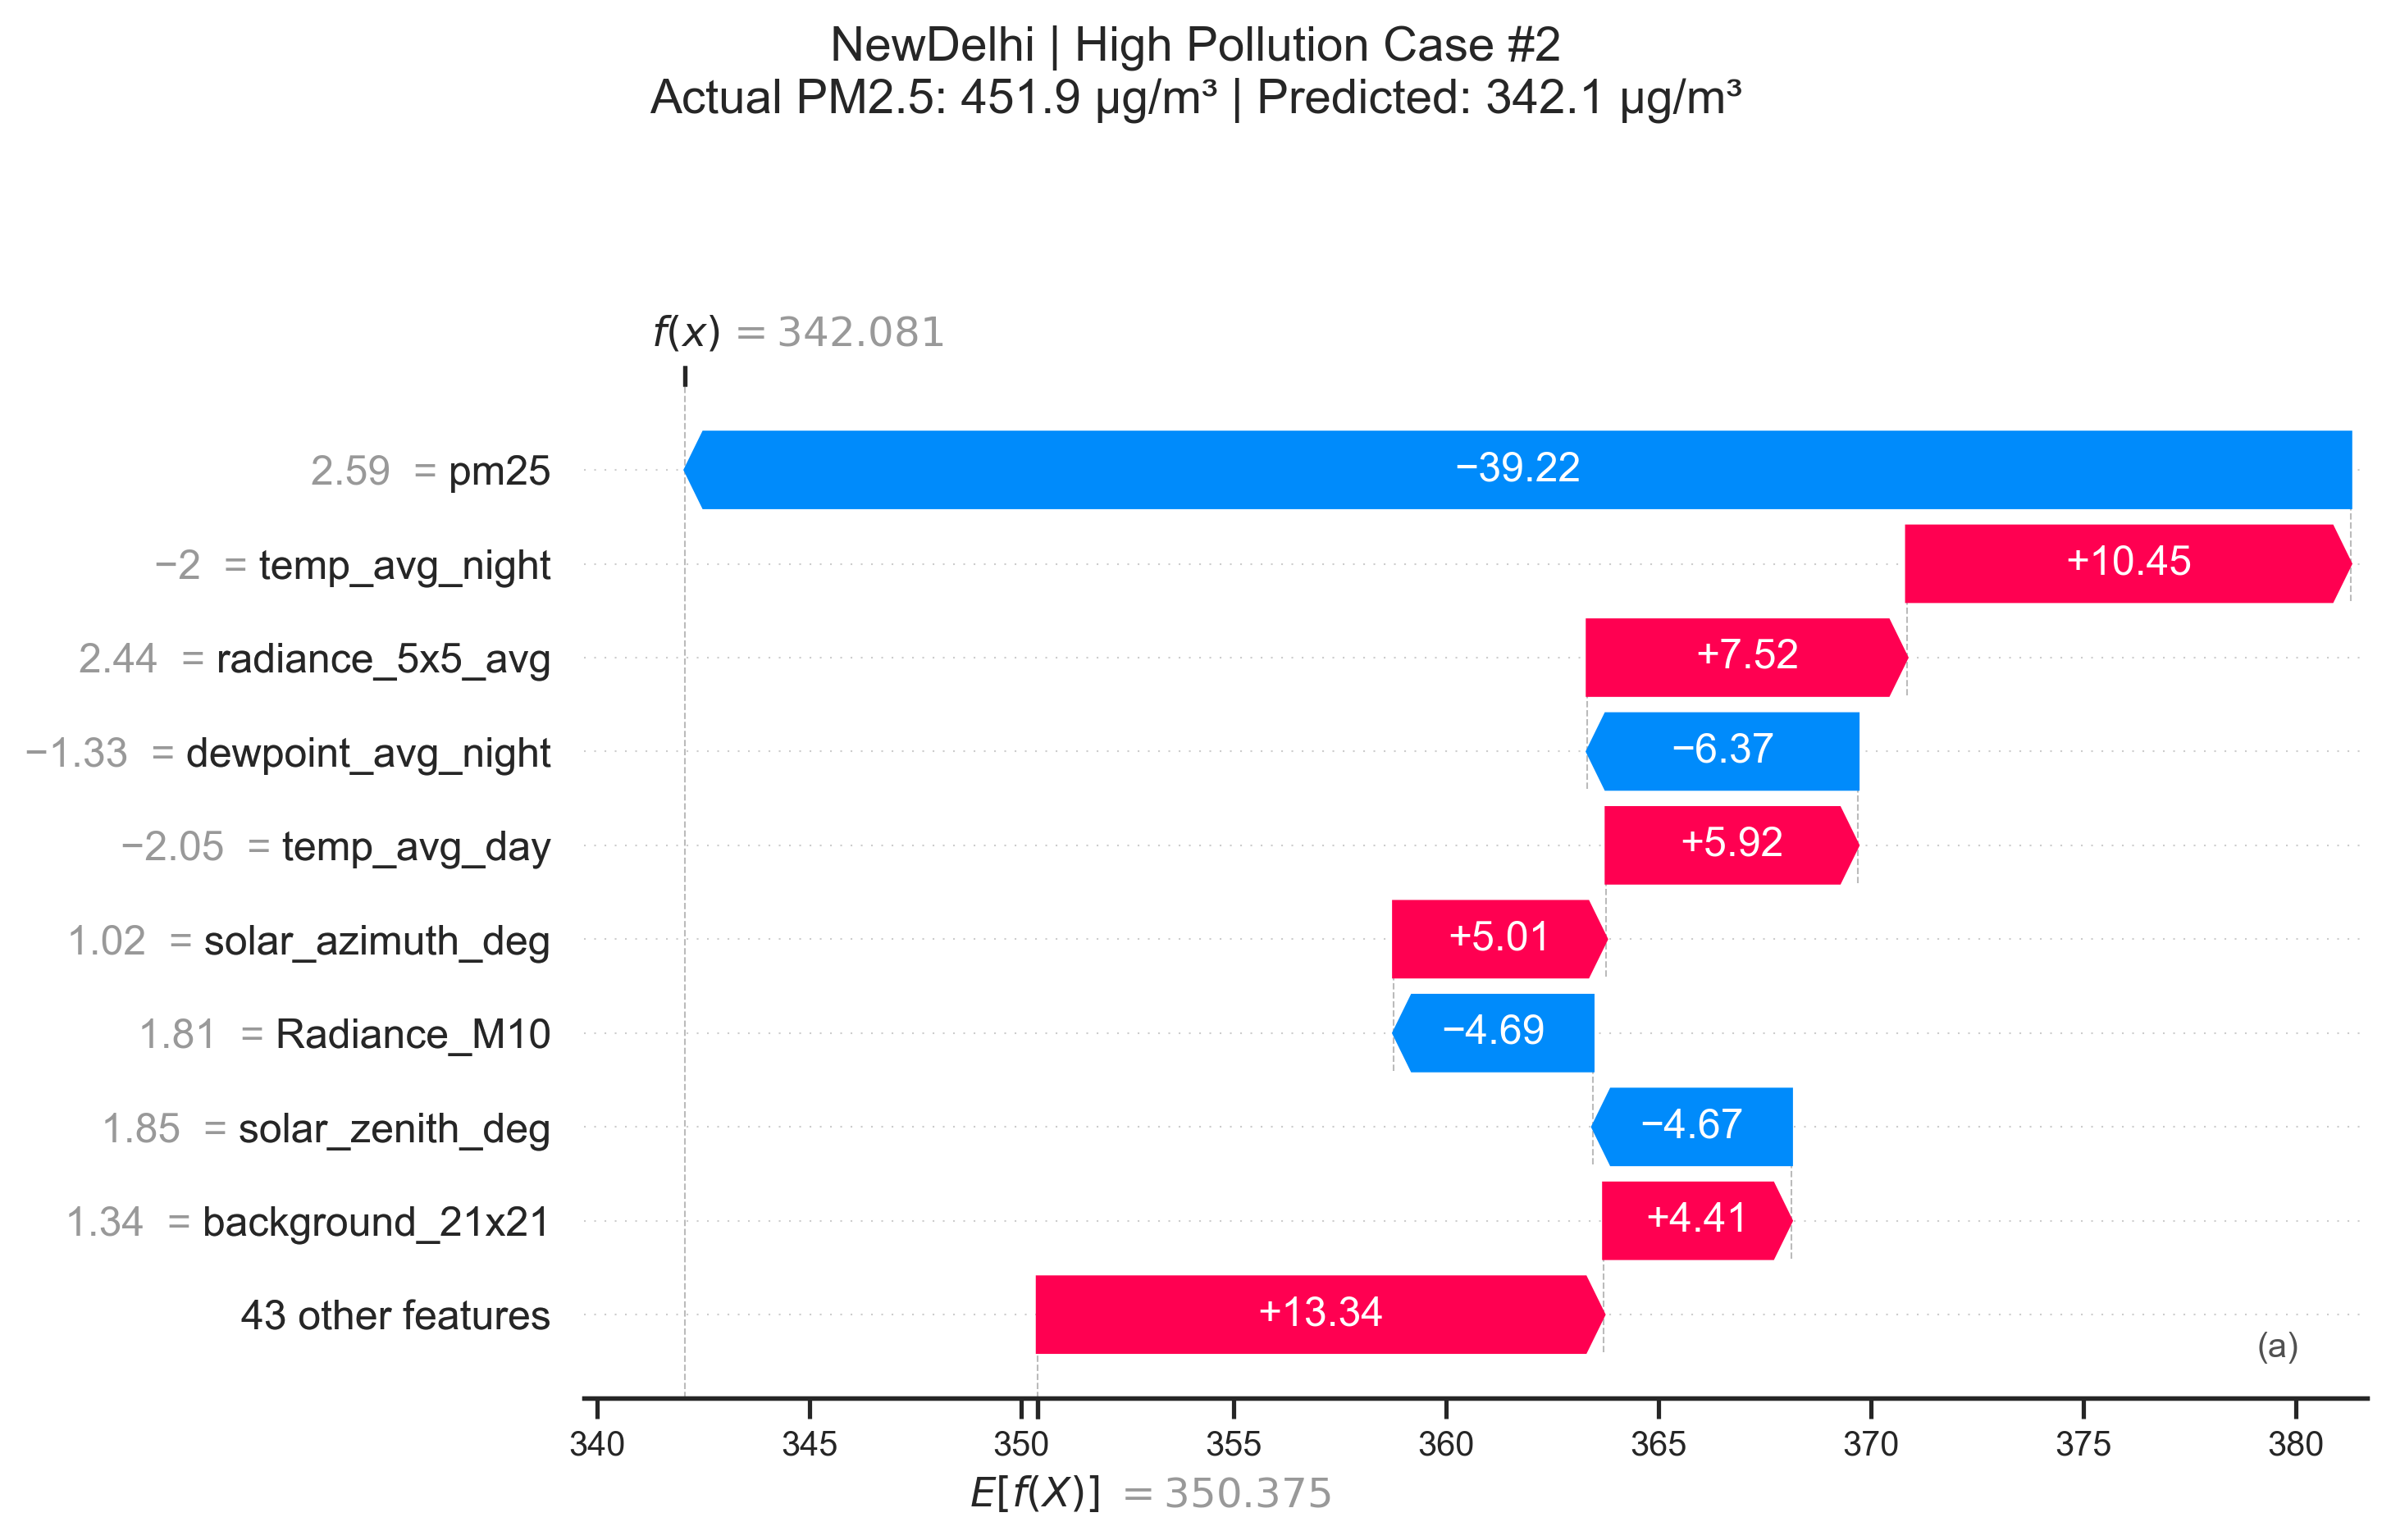

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

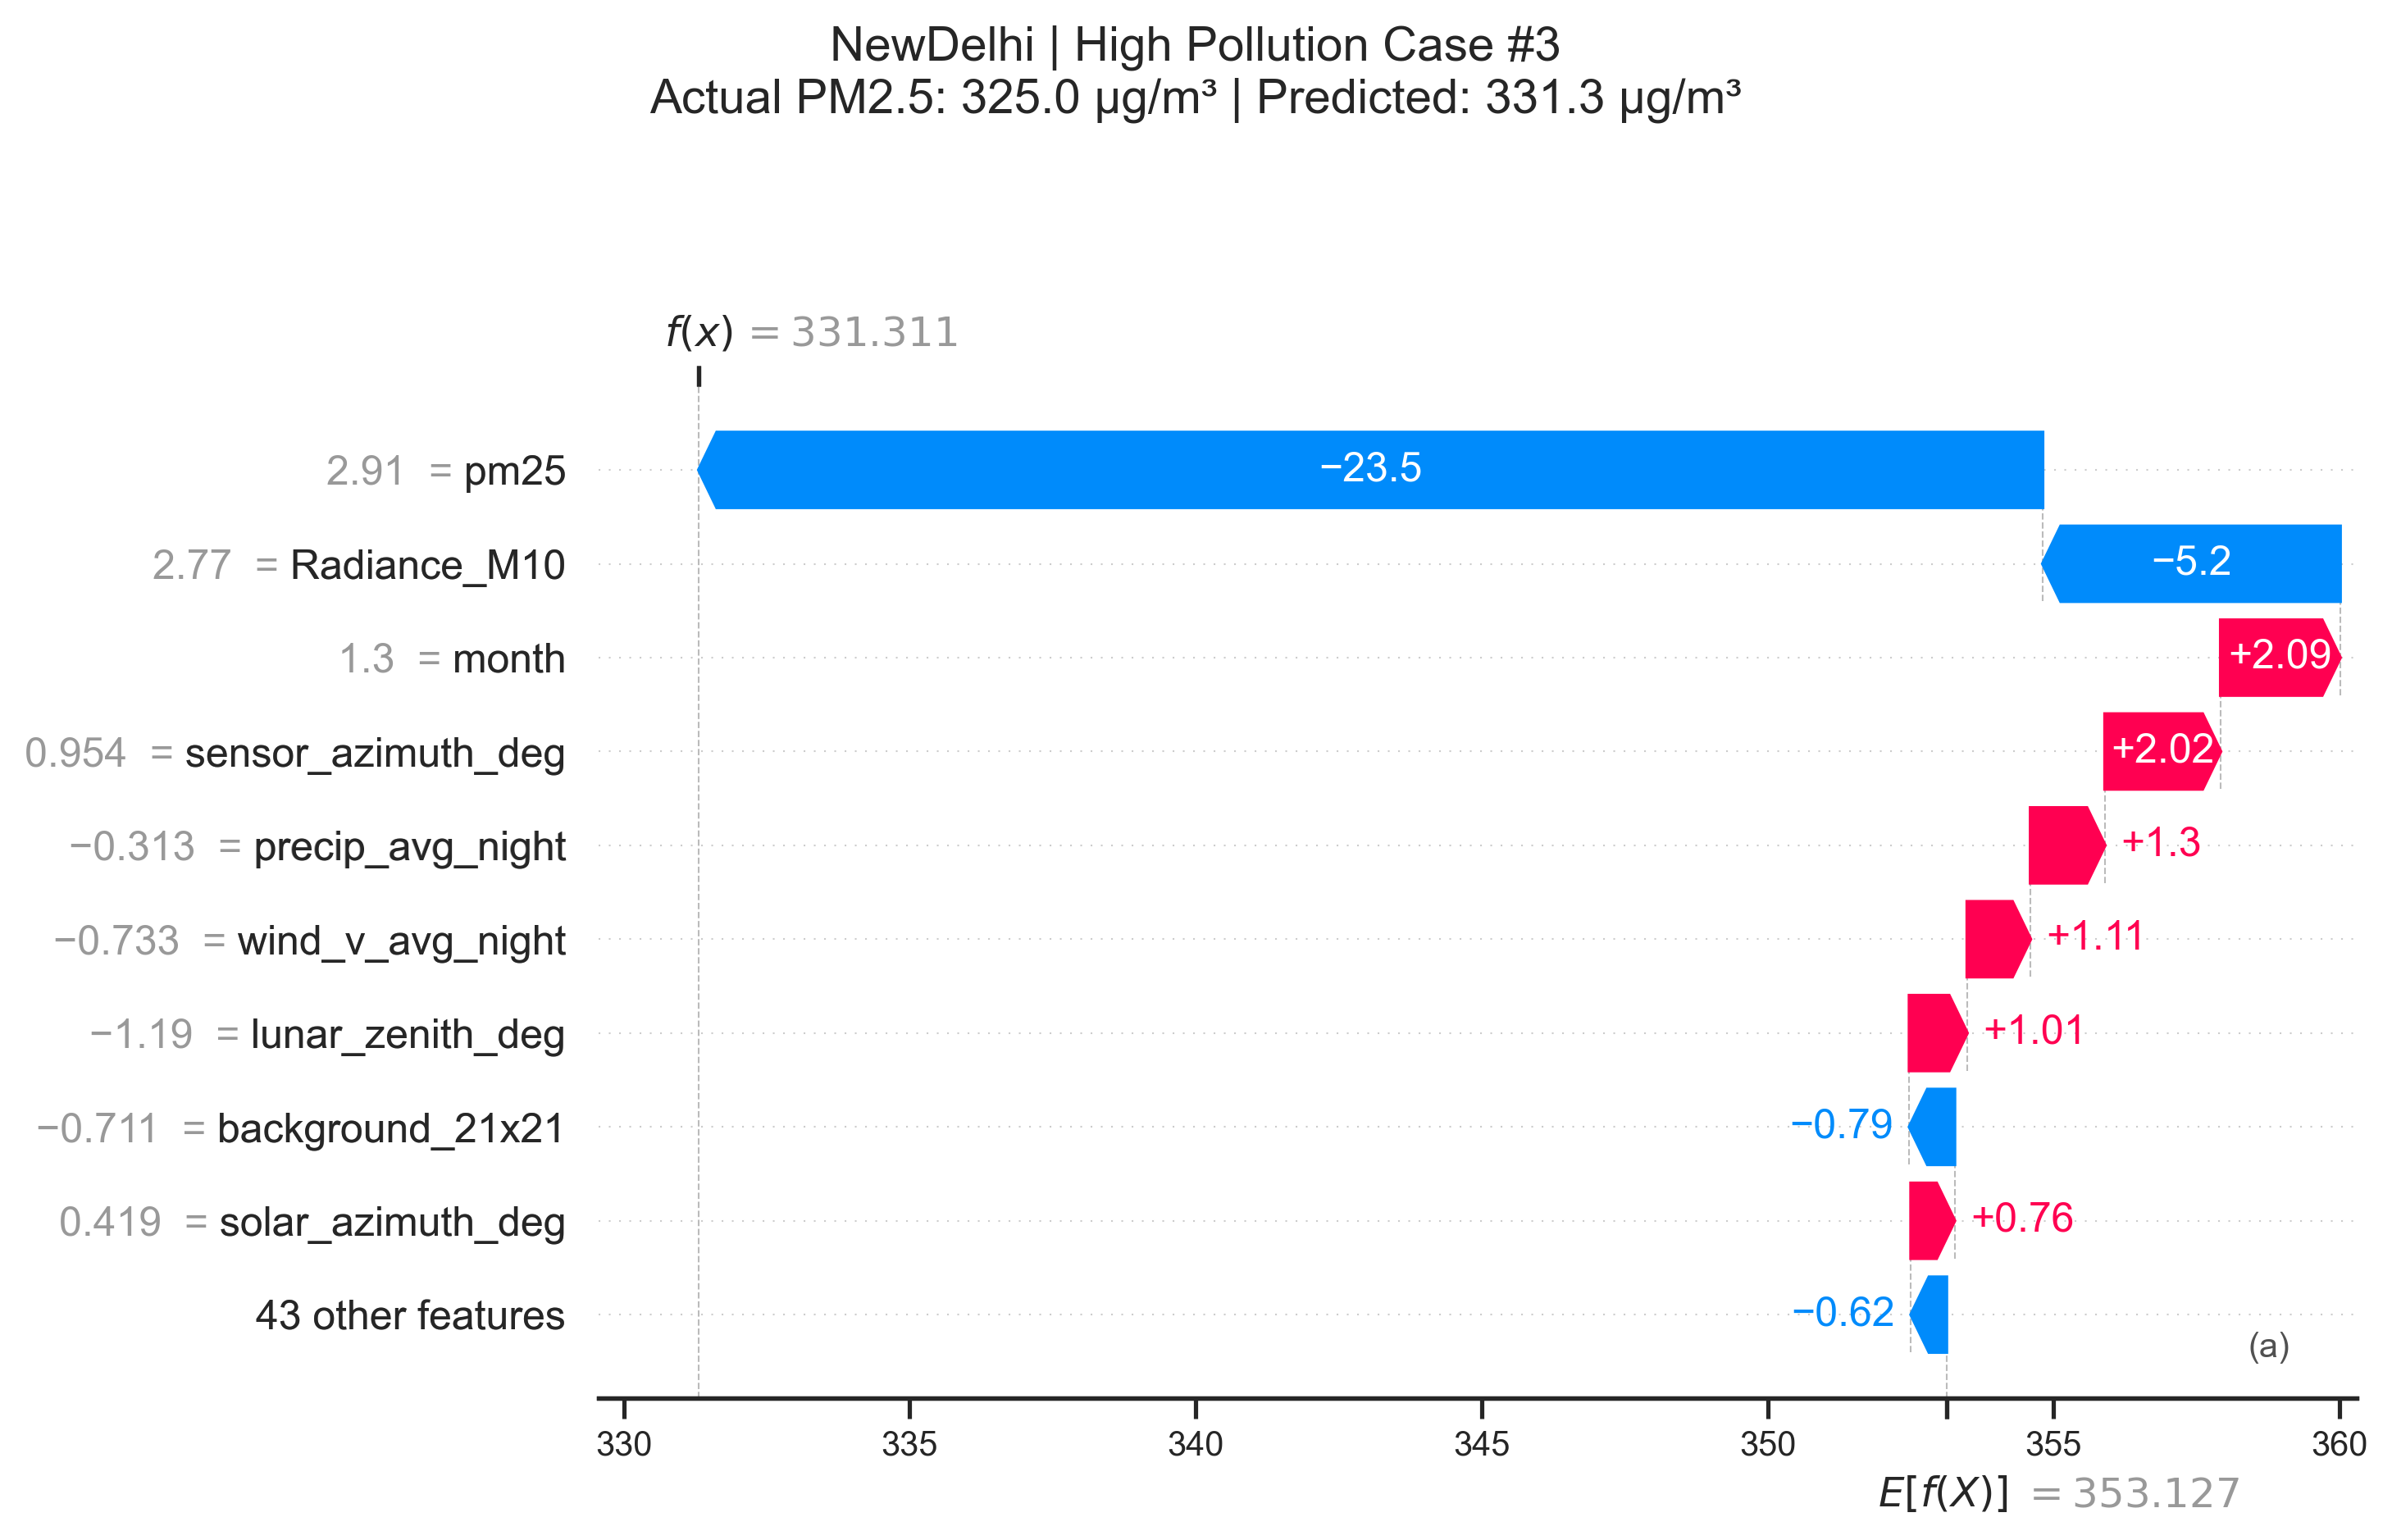

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

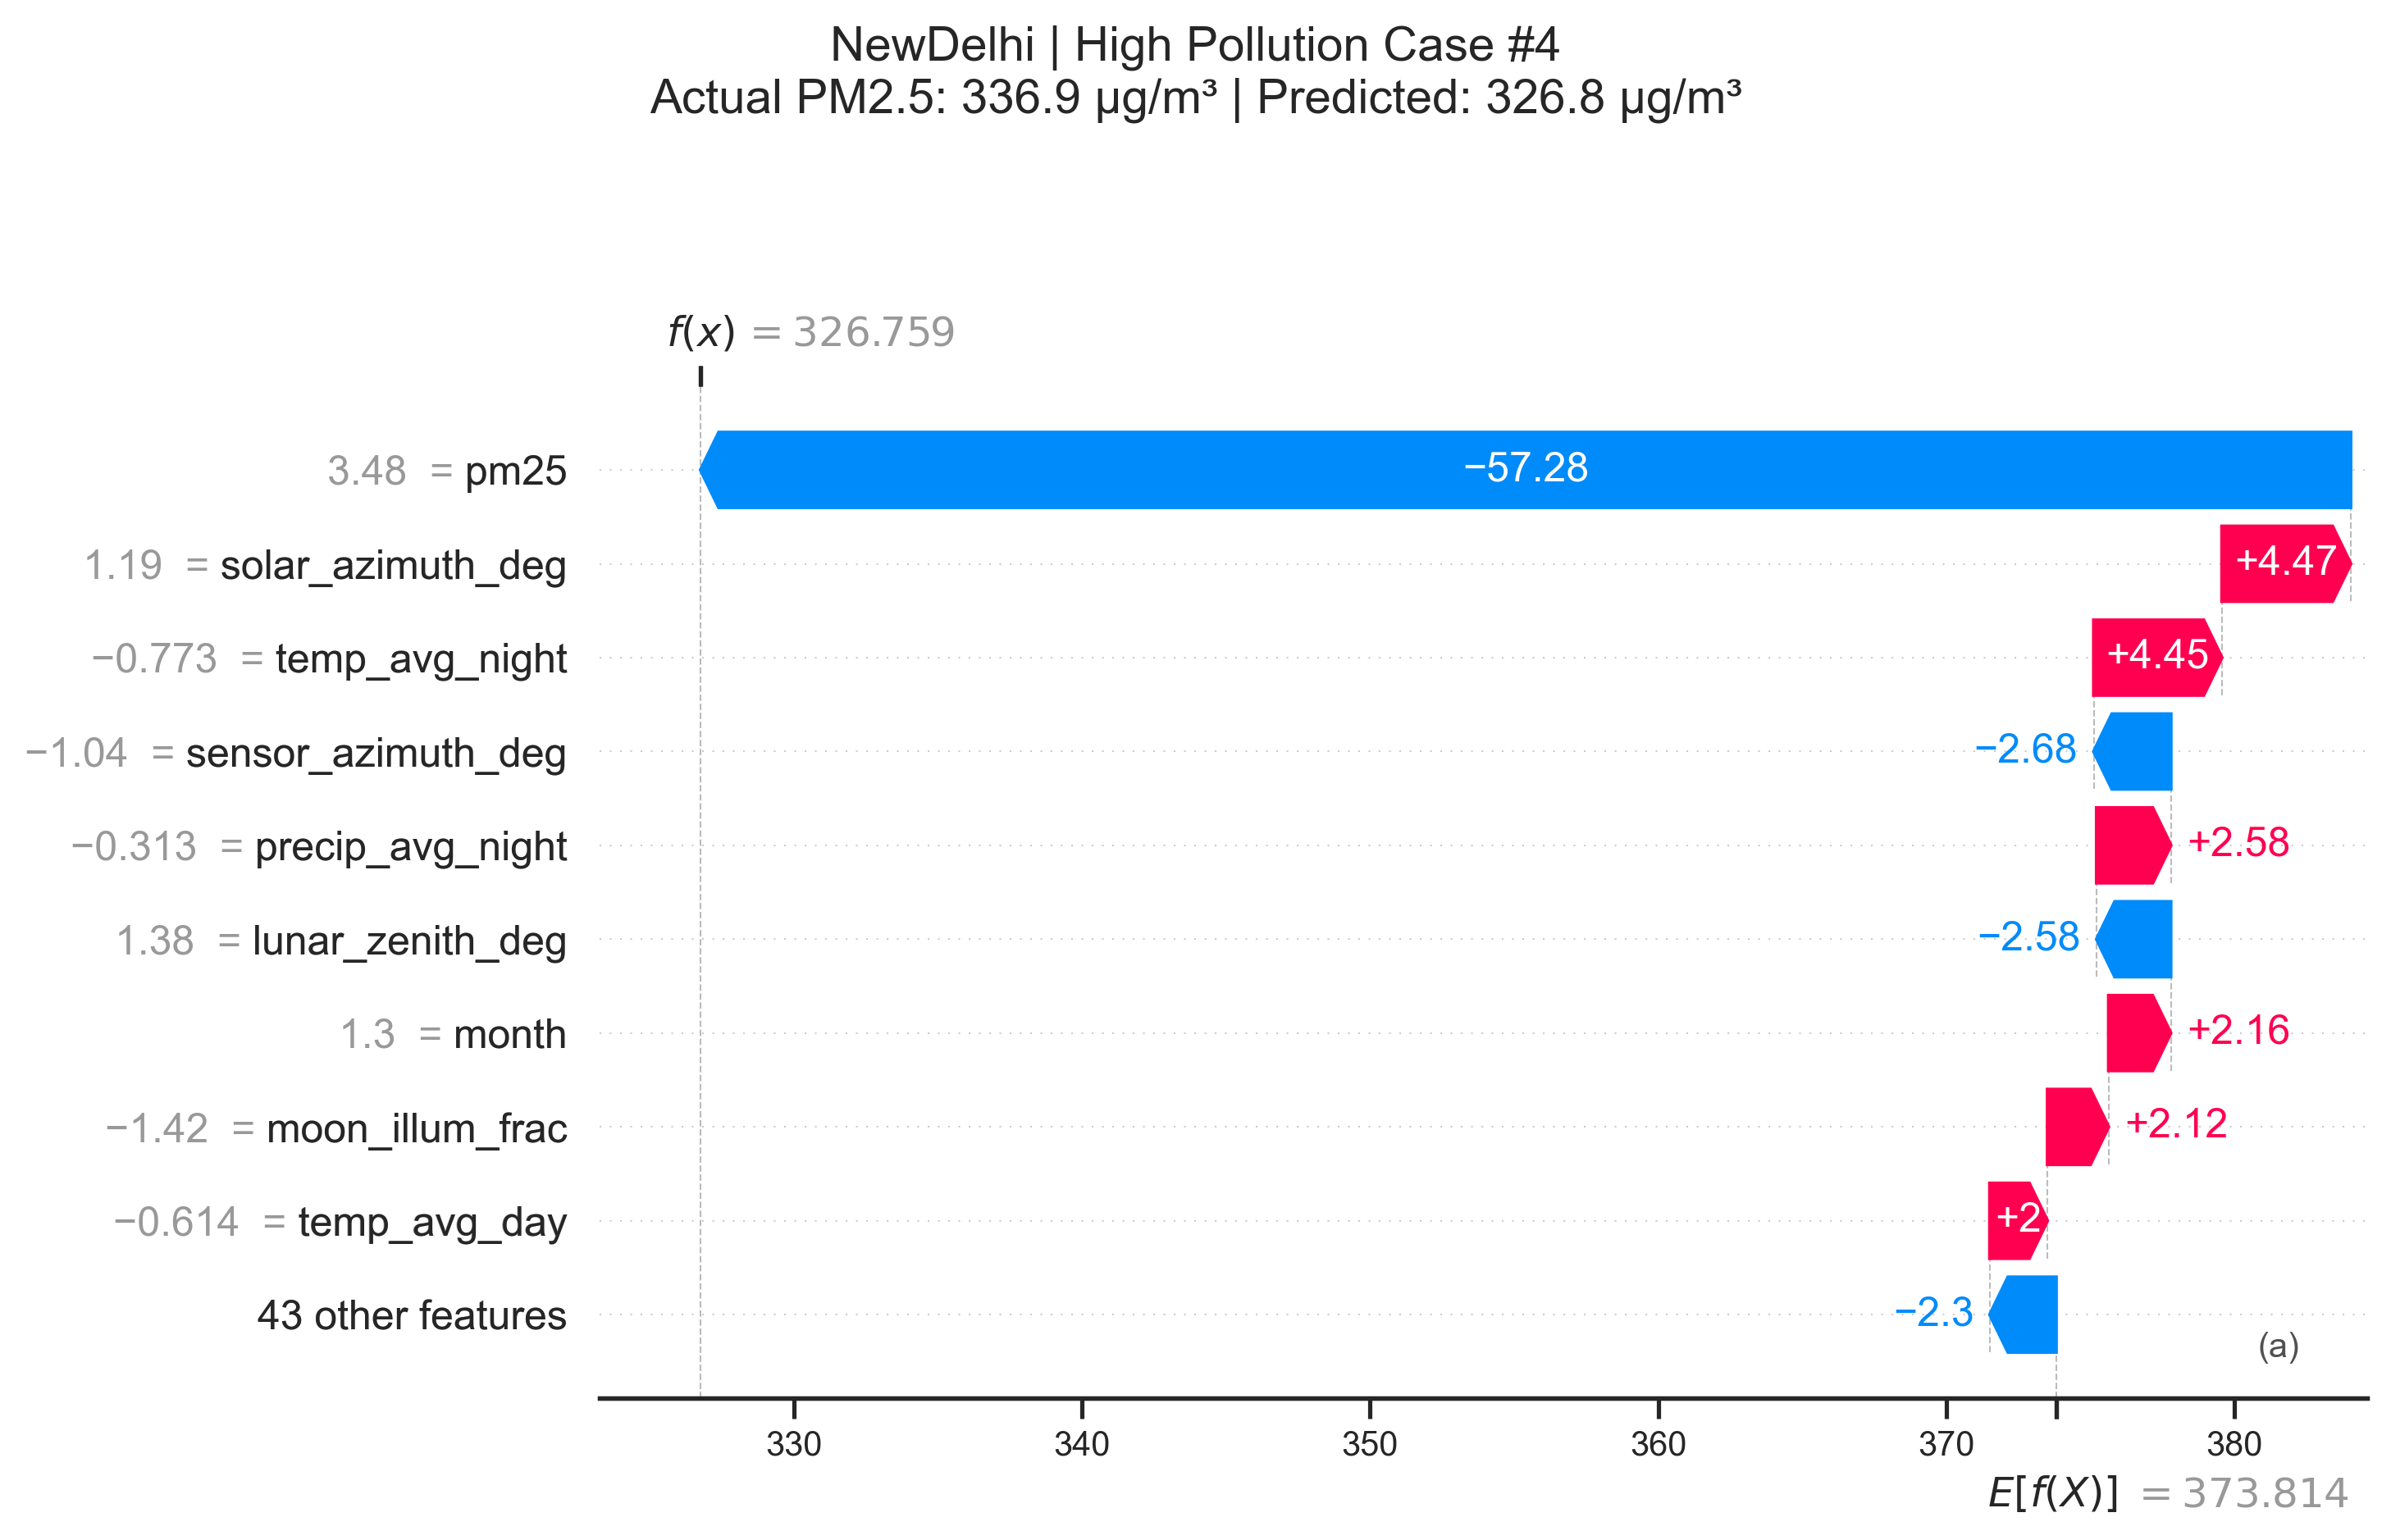

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

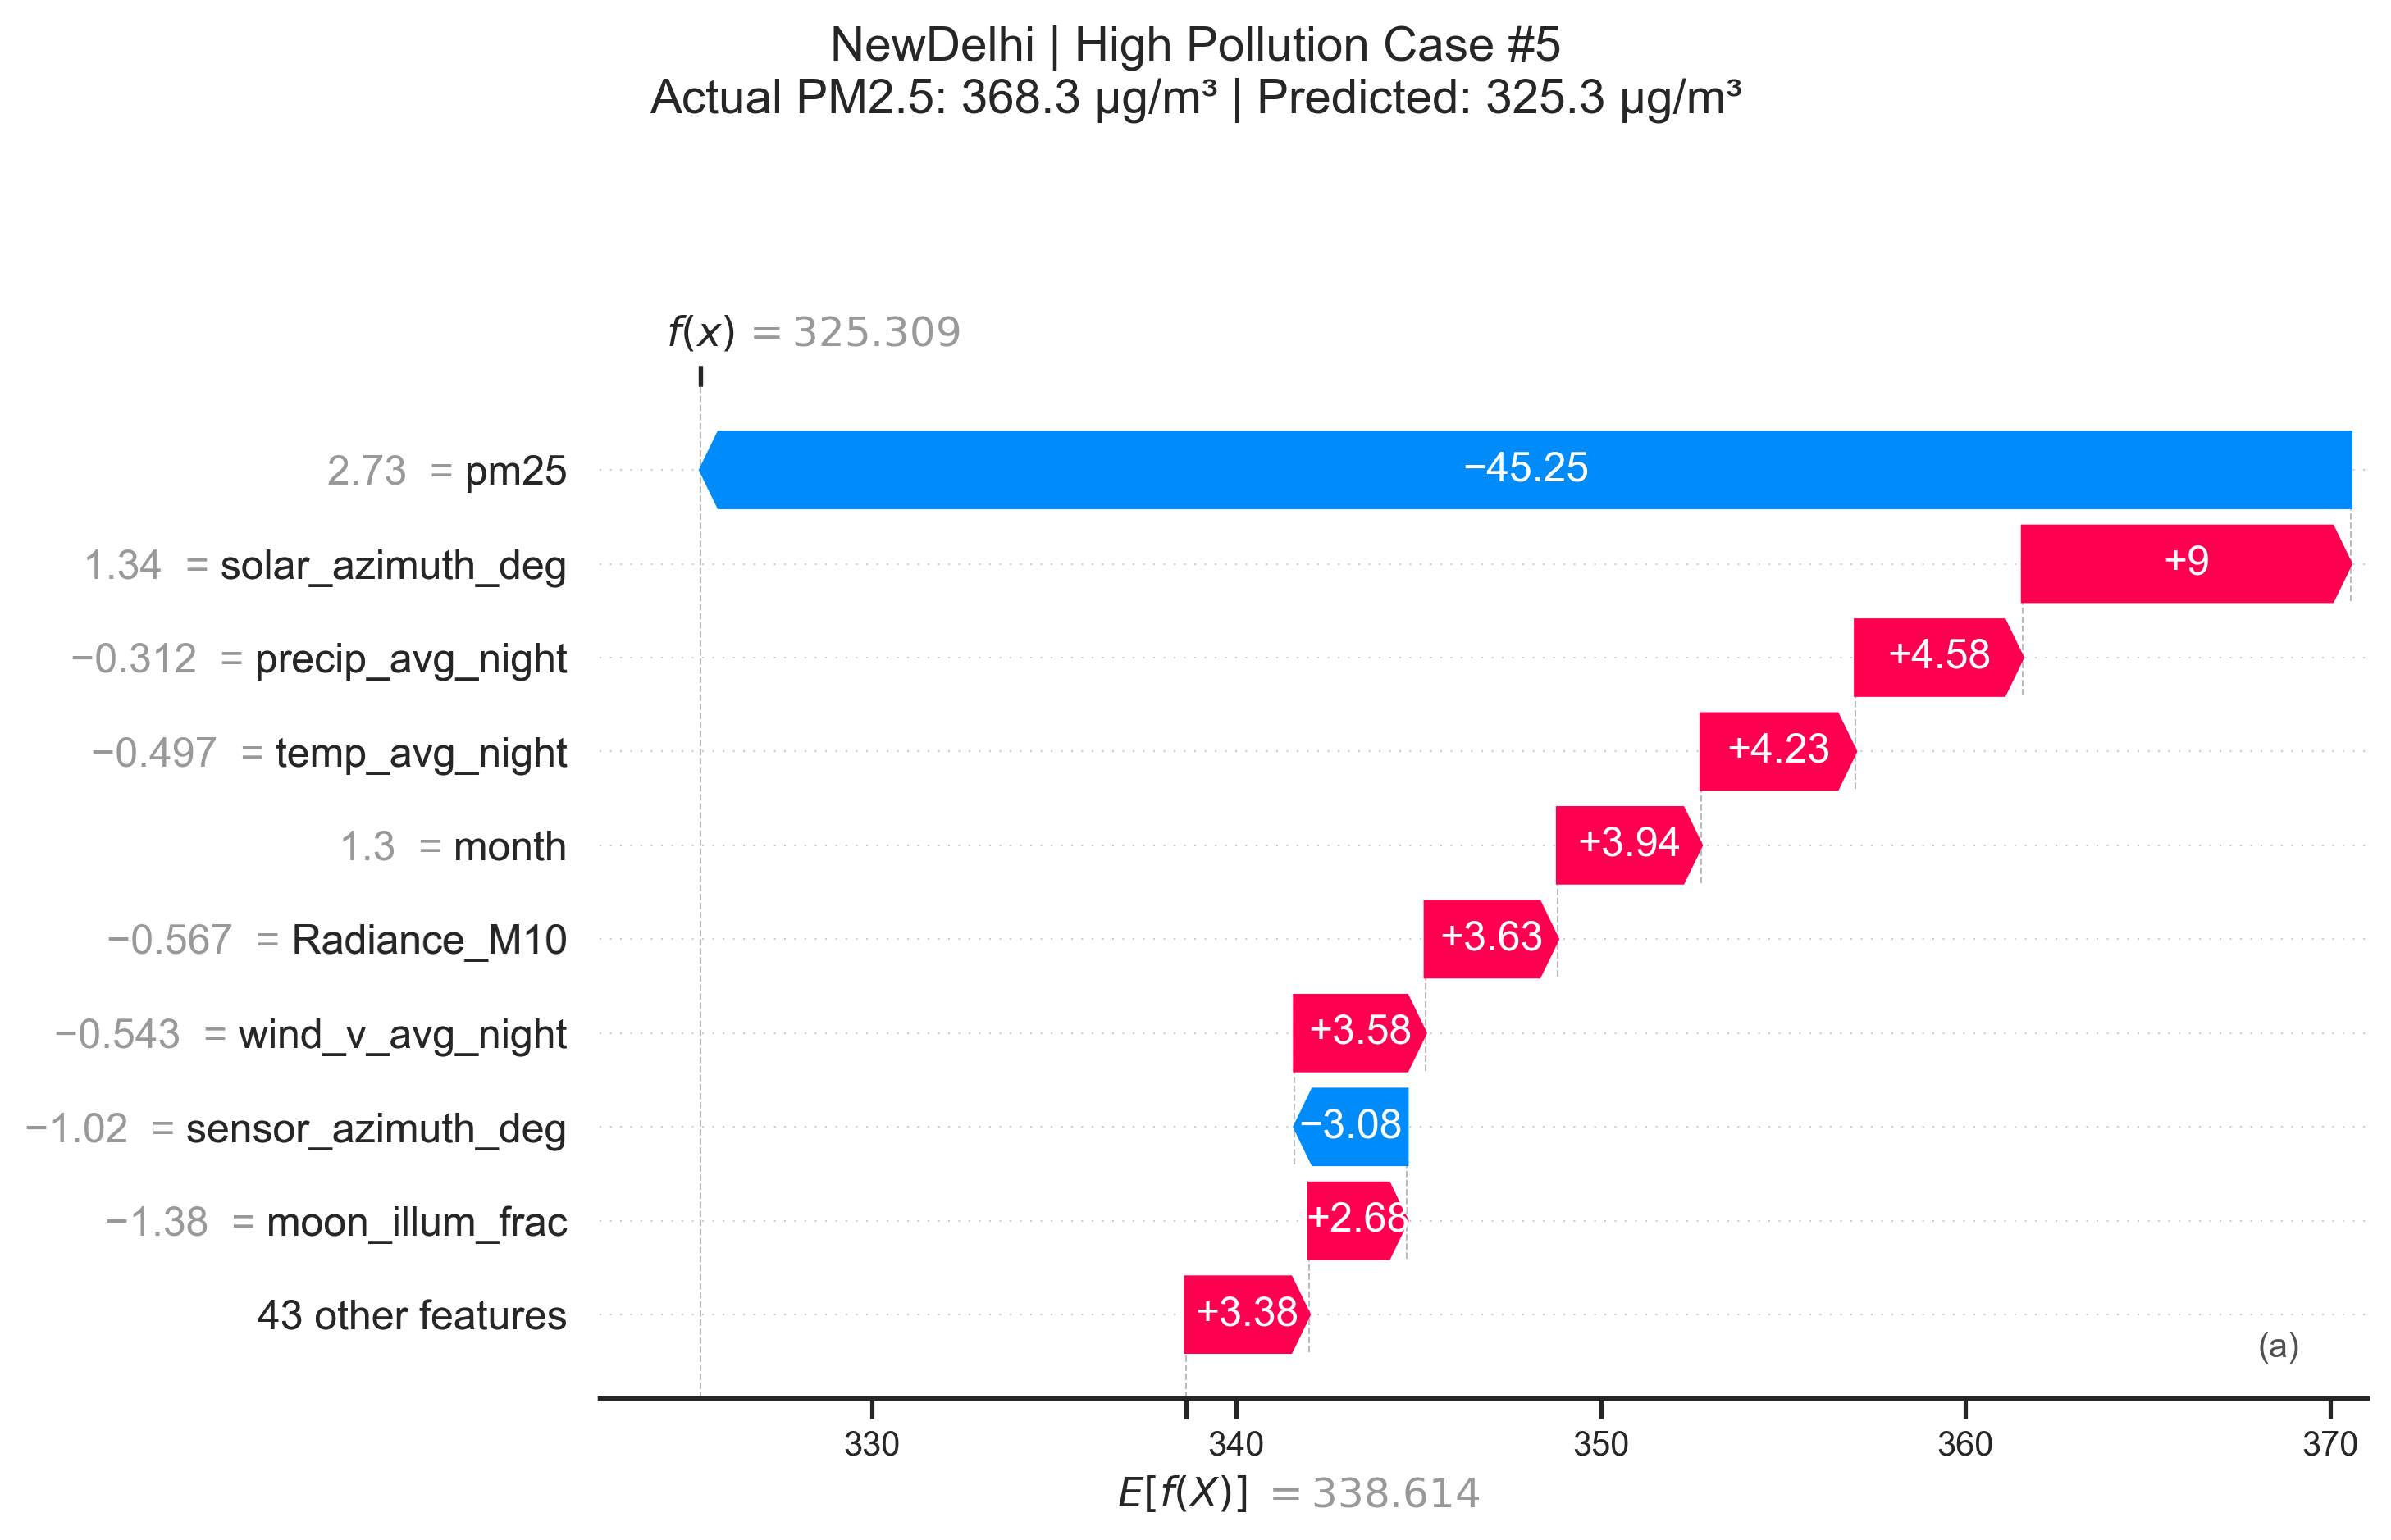

In [29]:
# ========== SHAP local explanations on high-pollution TRAIN cases (TCN; one-case-at-a-time) ==========
import numpy as np, pandas as pd, shap, xarray as xr, matplotlib.pyplot as plt, torch
import skexplain

pm_threshold = 15.0   # WHO guideline (µg/m³)

def _get_high_pollution_indices(X_df: pd.DataFrame, y_true: pd.Series, model_predict, num_cases=5):
    """
    Use the TCN adapter's .predict on FULL TRAIN rows to get predictions (1:1 with windows),
    then pick indices of top 'num_cases' among those exceeding the threshold.
    """
    preds = model_predict(X_df)  # length == number of TRAIN windows
    is_high = preds > pm_threshold
    if not np.any(is_high):
        return None, None, None, None
    idx_all = np.where(is_high)[0]
    top_rel = np.argsort(-preds[is_high])[:num_cases]
    top_idx = idx_all[top_rel]
    return top_idx, preds[top_idx], X_df.iloc[top_idx], y_true.iloc[top_idx]

class _SingleCaseTCNEstimator:
    """
    Sklearn-like wrapper for SHAP on ONE TRAIN row (case) at a time.

    Given:
      - base_window: (1, L, D) tensor for the chosen case
      - prev_scalar: float (previous-day PM2.5 for that case)

    .predict(X) accepts (M, D) masked rows from SHAP and returns preds of length M:
      pred = prev_scalar + model( repeated base_window with last step replaced by each row of X )
    """
    def __init__(self, torch_model, base_window_1LD: torch.Tensor, prev_scalar: float):
        self.model        = torch_model.eval()
        self.base_window  = base_window_1LD.clone()                   # (1, L, D)
        self.prev_scalar  = float(prev_scalar)
        self.D            = int(self.base_window.size(-1))

    @torch.no_grad()
    def predict(self, X):
        X_np = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
        if X_np.shape[1] != self.D:
            raise ValueError(f"Expected D={self.D} features, got {X_np.shape[1]}.")
        M = int(X_np.shape[0])
        Xw = self.base_window.repeat(M, 1, 1).clone()    # (M, L, D)
        Xw[:, -1, :] = torch.from_numpy(X_np)
        r_hat = self.model(Xw).cpu().numpy().reshape(M)
        return self.prev_scalar + r_hat

def analyze_city_pollution_tcn(city_name, num_cases=5):
    """
    Mirrors your XGB routine but uses ONE-CASE estimators for SHAP.
    """
    pack = final_models_tcn_pc[city_name]
    X_tr = city_data_tcn_pc[city_name]["X_train_2d"]
    y_tr = city_data_tcn_pc[city_name]["y_train_seq"]
    adapter_train = pack["adapter_train"]  # has .predict over FULL TRAIN set

    # 1) find top high-pollution TRAIN cases
    top_idx, top_preds, highX, highY = _get_high_pollution_indices(
        X_df=X_tr, y_true=y_tr, model_predict=adapter_train.predict, num_cases=num_cases
    )
    if top_idx is None:
        print(f"{city_name}: No TRAIN rows exceed {pm_threshold} µg/m³.")
        return

    # 2) Loop per case so SHAP can pass arbitrary M masked rows; build a one-case estimator each time
    shap_background = X_tr  # reasonable background for the masker
    for rank, case_row_idx in enumerate(top_idx, start=1):
        # Build estimator tied to this single case
        base_window = adapter_train.x_windows[case_row_idx:case_row_idx+1]  # (1, L, D)
        # adapter_train.prev_vec may be a tensor; ensure float
        prev_scalar = float(adapter_train.prev_vec[case_row_idx].item()) if hasattr(adapter_train.prev_vec, "ndim") else float(adapter_train.prev_vec[case_row_idx])
        est = _SingleCaseTCNEstimator(adapter_train.model, base_window, prev_scalar)

        # SHAP config (Permutation with correlation partition background)
        shap_config = {
            "masker": shap.maskers.Partition(
                shap_background,
                max_samples=100,
                clustering="correlation"
            ),
            "algorithm": "auto"
        }

        est_name = f"{city_name}_tcn_case{rank}"
        # Single-row dataset for this explanation
        X_case = highX.iloc[[rank-1]]
        y_case = highY.iloc[[rank-1]]

        explainer = skexplain.ExplainToolkit(
            estimators=[(est_name, est)],
            X=X_case,
            y=y_case,
            feature_names=list(X_tr.columns)
        )

        explanation = explainer.local_attributions(method=["shap"], shap_kws=shap_config)

        shap_values_key = f"shap_values__{est_name}"
        baseline_key    = f"shap_bias__{est_name}"

        # Build a per-case xarray for plotting
        fig_ds = xr.Dataset(
            {
                shap_values_key: (["cases", "features"], [explanation[shap_values_key][0].values]),
                baseline_key:    (["cases"],             [explanation[baseline_key][0].item()]),
                "X":             (["cases", "features"], [X_case.iloc[0].values])
            },
            coords={"cases":[0], "features": list(X_tr.columns)},
            attrs=explanation.attrs
        )

        fig, _ = explainer.plot_contributions(
            contrib=fig_ds,
            estimator_names=est_name,
            features=list(X_tr.columns),
            show_baseline=True,
            figsize=(10, 6)
        )
        plt.suptitle(
            f"{city_name} | High Pollution Case #{rank}\n"
            f"Actual PM2.5: {float(y_case.iloc[0]):.1f} µg/m³ | "
            f"Predicted: {float(top_preds[rank-1]):.1f} µg/m³",
            y=1.05, fontsize=14
        )
        plt.tight_layout(); plt.show()

def analyze_all_cities_tcn(num_cases=5):
    for city in final_models_tcn_pc.keys():
        analyze_city_pollution_tcn(city, num_cases=num_cases)

# ---- Run it ----
analyze_all_cities_tcn(num_cases=5)


zero days

Abuja: No TRAIN rows with predicted PM2.5 == 0 (tol=0.0).
Chennai: No TRAIN rows with predicted PM2.5 == 0 (tol=0.0).
NewDelhi: No TRAIN rows with predicted PM2.5 == 0 (tol=0.0).
Abuja: Found 2 actual-zero TRAIN rows (showing 2).


C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

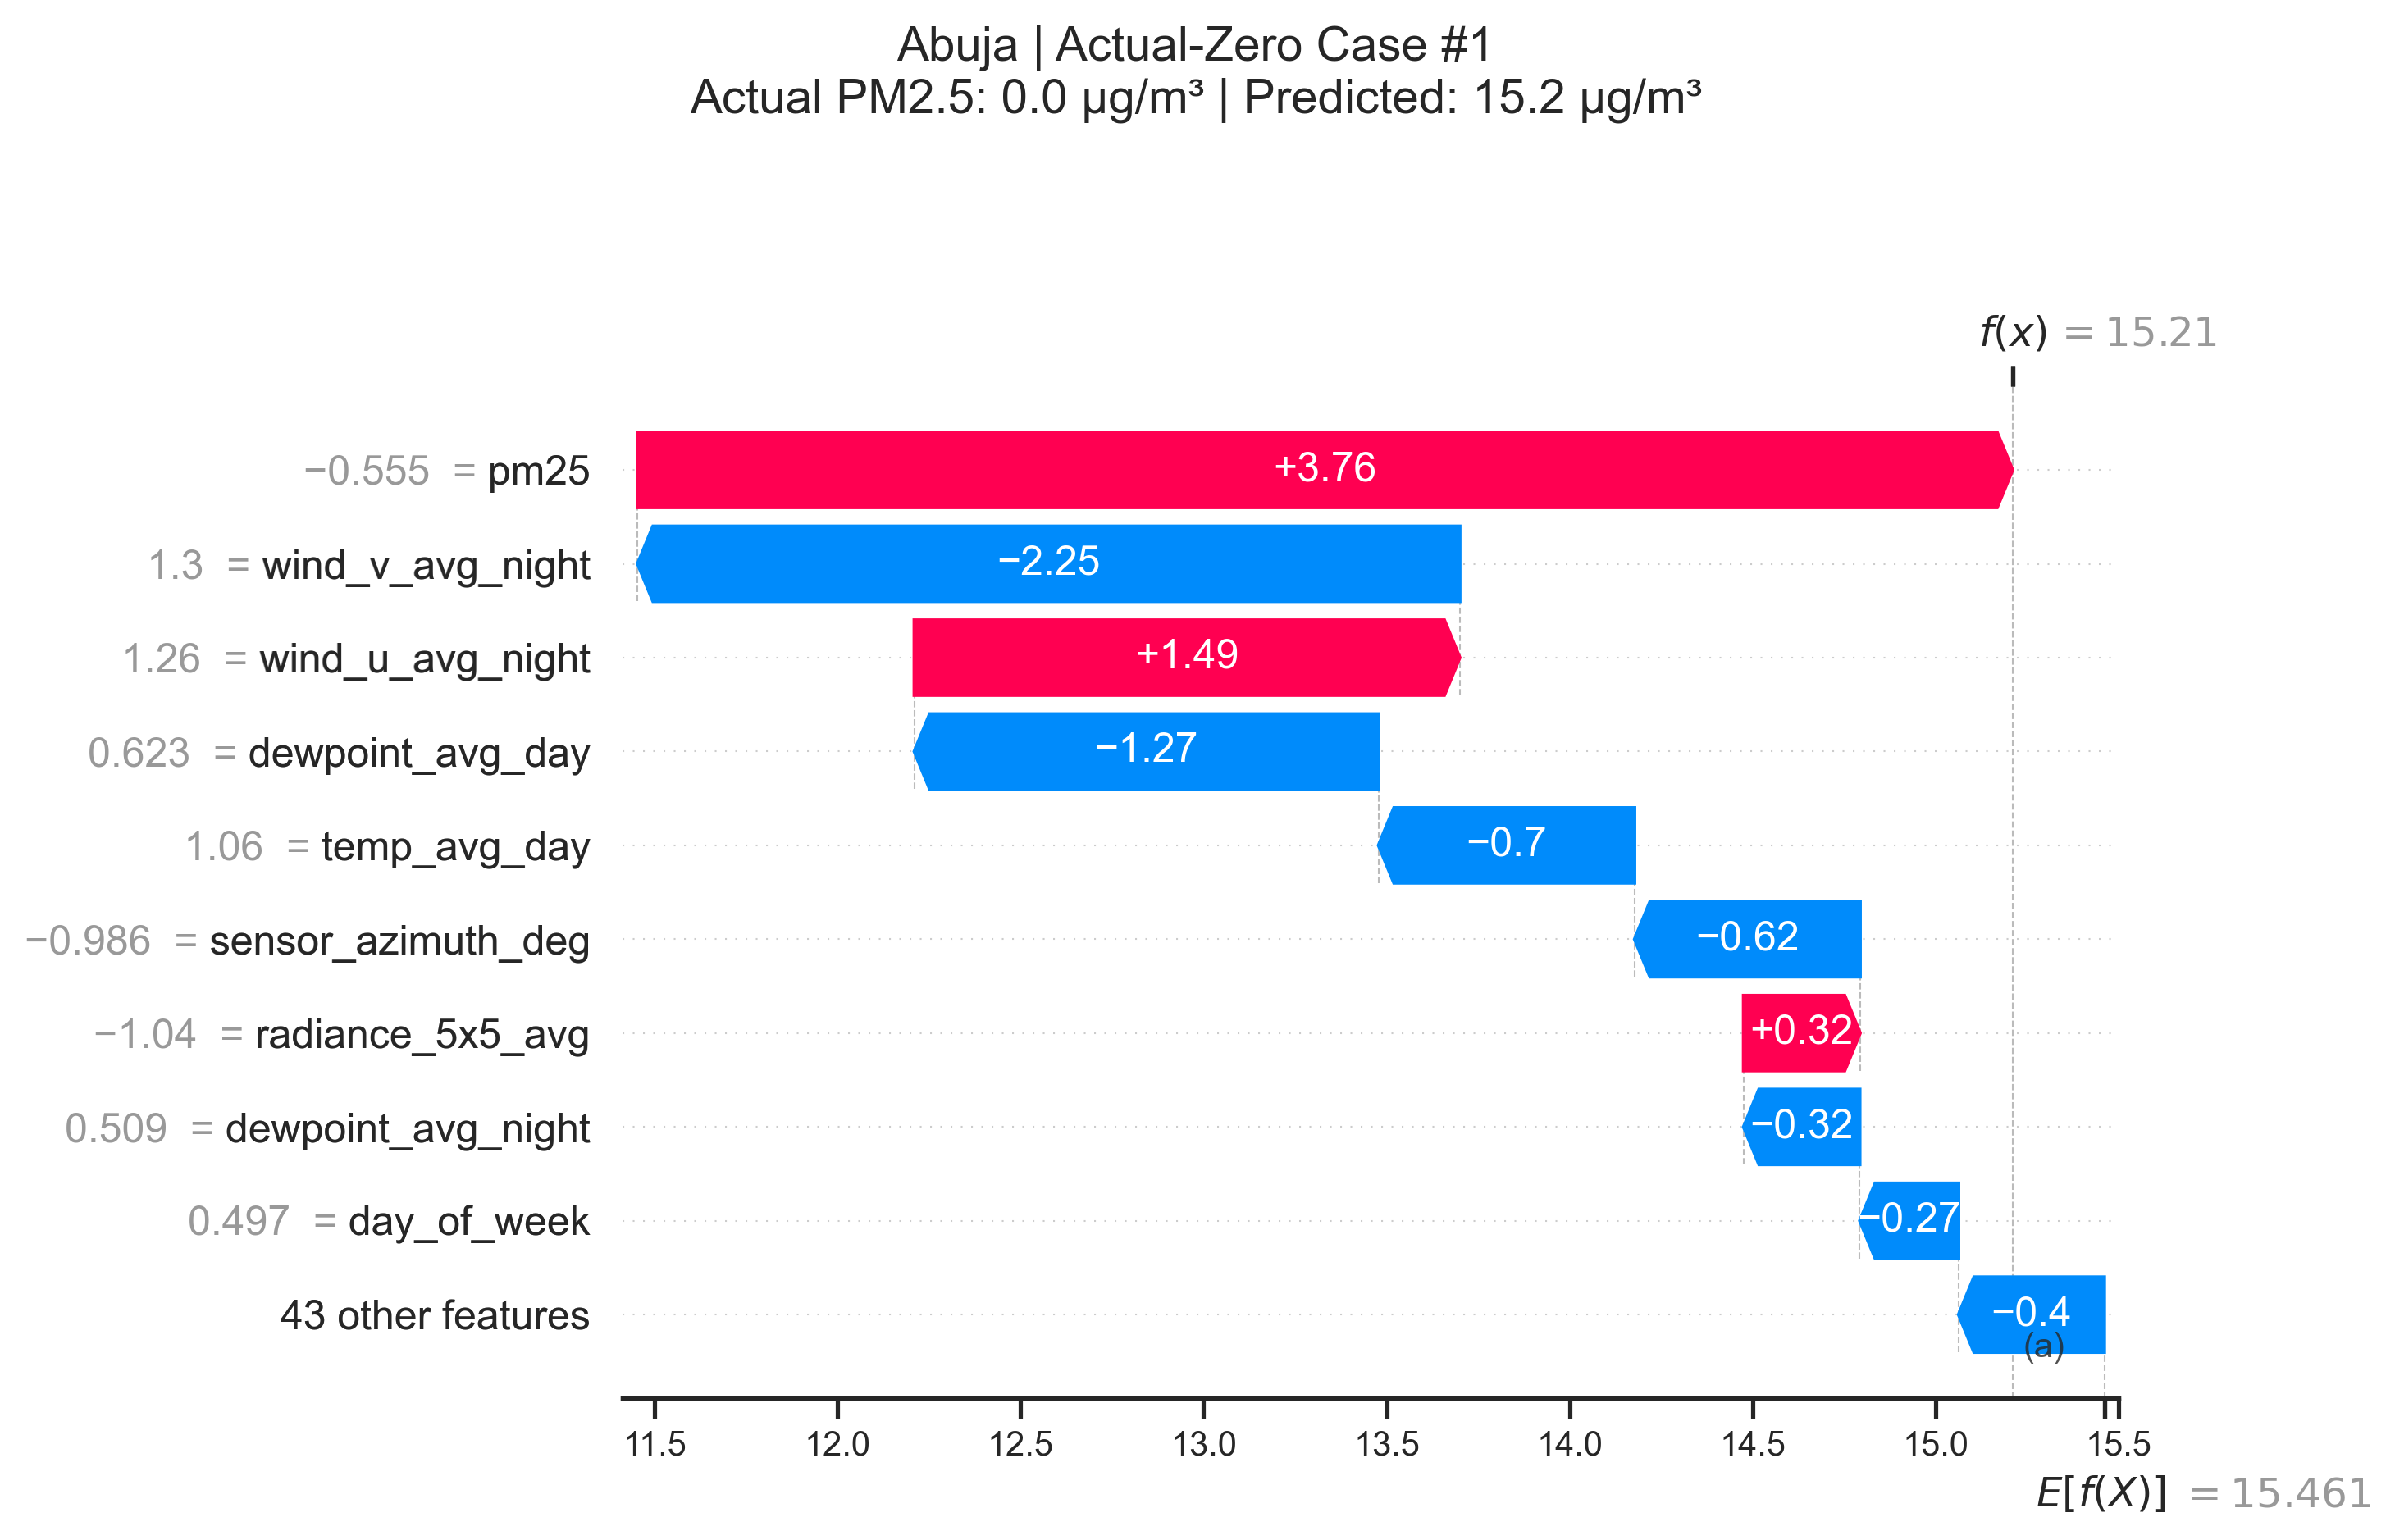

C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skexplain\plot\plot_feature_contributions.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(features[order[i]]) < 1:
C:\Users\Favour Sukat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qb

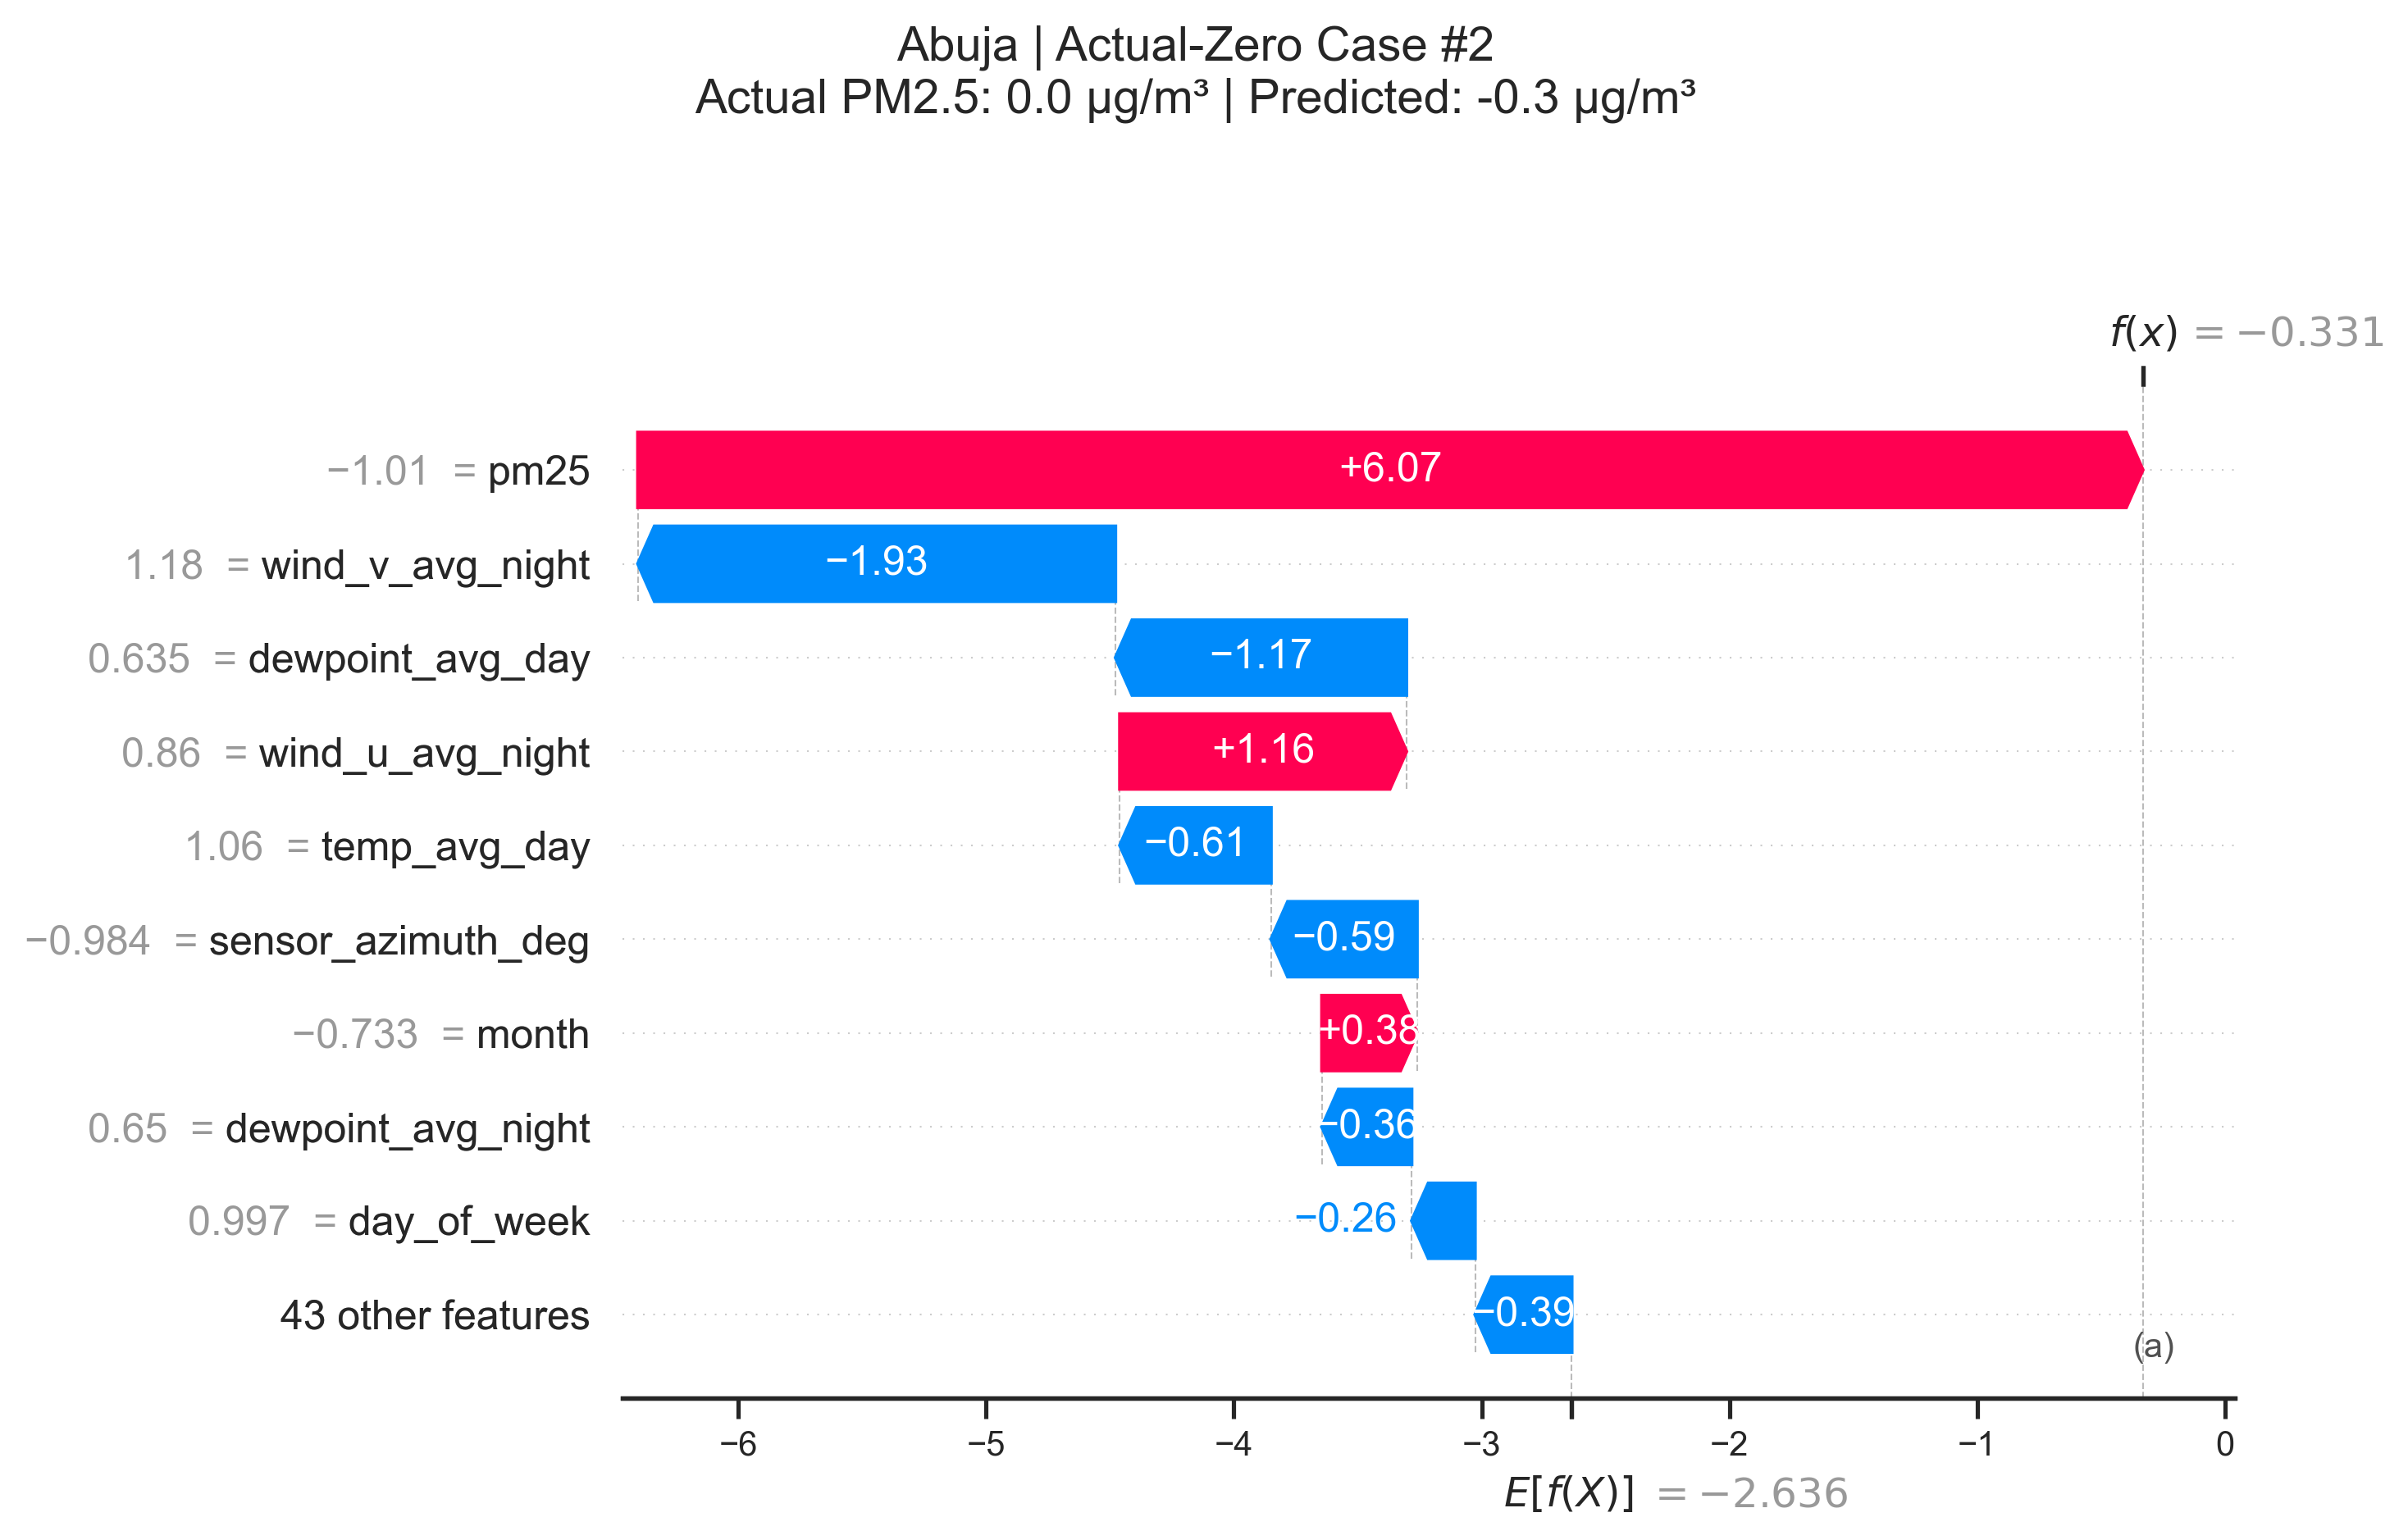

Chennai: No TRAIN rows with actual PM2.5 == 0.
NewDelhi: No TRAIN rows with actual PM2.5 == 0.


In [30]:
# ========== SHAP locals for TCN on TRAIN: predicted-zero & actual-zero cases ==========

import numpy as np, pandas as pd, shap, xarray as xr, matplotlib.pyplot as plt, torch
import skexplain

# ---------- helper: one-case estimator that accepts arbitrary masked batch size ----------
class _SingleCaseTCNEstimator:
    """
    Sklearn-like wrapper for SHAP on ONE TRAIN row (case).

    Given:
      - base_window: (1, L, D) tensor for the chosen case
      - prev_scalar: float (previous-day PM2.5 for that case)

    .predict(X) accepts (M, D) masked rows and returns preds of length M:
      pred = prev_scalar + model( repeated base_window with last step replaced by each row of X )
    """
    def __init__(self, torch_model, base_window_1LD: torch.Tensor, prev_scalar: float):
        self.model        = torch_model.eval()
        self.base_window  = base_window_1LD.clone()                   # (1, L, D)
        self.prev_scalar  = float(prev_scalar)
        self.D            = int(self.base_window.size(-1))

    @torch.no_grad()
    def predict(self, X):
        X_np = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
        if X_np.shape[1] != self.D:
            raise ValueError(f"Expected D={self.D} features, got {X_np.shape[1]}.")
        M = int(X_np.shape[0])
        Xw = self.base_window.repeat(M, 1, 1).clone()    # (M, L, D)
        Xw[:, -1, :] = torch.from_numpy(X_np)
        r_hat = self.model(Xw).cpu().numpy().reshape(M)
        return self.prev_scalar + r_hat

# ---------- shared SHAP runner for a single case index ----------
def _shap_explain_single_case(city, case_idx, title_prefix, pred_val, true_val):
    pack   = final_models_tcn_pc[city]
    adap   = pack["adapter_train"]
    X_tr   = city_data_tcn_pc[city]["X_train_2d"]
    feats  = list(X_tr.columns)

    base_window = adap.x_windows[case_idx:case_idx+1]  # (1, L, D)
    prev_scalar = float(adap.prev_vec[case_idx].item()) if hasattr(adap.prev_vec, "ndim") else float(adap.prev_vec[case_idx])

    est = _SingleCaseTCNEstimator(adap.model, base_window, prev_scalar)

    shap_config = {
        "masker": shap.maskers.Partition(
            X_tr,            # background over TRAIN (as with XGBoost flow)
            max_samples=100,
            clustering="correlation"
        ),
        "algorithm": "auto"
    }

    est_name = f"{city}_tcn_case{int(case_idx)}"
    X_case   = X_tr.iloc[[case_idx]]
    y_case   = city_data_tcn_pc[city]["y_train_seq"].iloc[[case_idx]]

    explainer = skexplain.ExplainToolkit(
        estimators=[(est_name, est)],
        X=X_case,
        y=y_case,
        feature_names=feats
    )
    explanation = explainer.local_attributions(method=["shap"], shap_kws=shap_config)

    shap_values_key = f"shap_values__{est_name}"
    baseline_key    = f"shap_bias__{est_name}"

    fig_ds = xr.Dataset(
        {
            shap_values_key: (["cases", "features"], [explanation[shap_values_key][0].values]),
            baseline_key:    (["cases"],             [explanation[baseline_key][0].item()]),
            "X":             (["cases", "features"], [X_case.iloc[0].values])
        },
        coords={"cases":[0], "features": feats},
        attrs=explanation.attrs
    )

    fig, _ = explainer.plot_contributions(
        contrib=fig_ds,
        estimator_names=est_name,
        features=feats,
        show_baseline=True,
        figsize=(10, 6)
    )
    plt.suptitle(
        f"{city} | {title_prefix}\n"
        f"Actual PM2.5: {float(true_val):.1f} µg/m³ | Predicted: {float(pred_val):.1f} µg/m³",
        y=1.05, fontsize=14
    )
    plt.tight_layout(); plt.show()

# ---------- predicted-zero (TRAIN) ----------
def analyze_zero_prediction_days_tcn(city_name, num_cases=5, zero_tol=0.0):
    X_tr   = city_data_tcn_pc[city_name]["X_train_2d"]
    y_tr   = city_data_tcn_pc[city_name]["y_train_seq"]
    preds  = final_models_tcn_pc[city_name]["adapter_train"].predict(X_tr)

    if zero_tol == 0.0:
        mask = (preds == 0.0)
    else:
        mask = np.isclose(preds, 0.0, atol=float(zero_tol))

    idx = np.where(mask)[0]
    if idx.size == 0:
        print(f"{city_name}: No TRAIN rows with predicted PM2.5 == 0 (tol={zero_tol}).")
        return

    sel = idx[:num_cases]
    for rank, i in enumerate(sel, start=1):
        _shap_explain_single_case(
            city=city_name,
            case_idx=int(i),
            title_prefix=f"Zero-Prediction Case #{rank}",
            pred_val=preds[i],
            true_val=y_tr.iloc[i]
        )

def analyze_all_zero_prediction_days_tcn(num_cases=5, zero_tol=0.0):
    for city in final_models_tcn_pc.keys():
        analyze_zero_prediction_days_tcn(city, num_cases=num_cases, zero_tol=zero_tol)

# ---------- actual-zero (TRAIN) ----------
def analyze_actual_zero_days_tcn(city_name, num_cases=None):
    X_tr   = city_data_tcn_pc[city_name]["X_train_2d"]
    y_tr   = city_data_tcn_pc[city_name]["y_train_seq"]
    preds  = final_models_tcn_pc[city_name]["adapter_train"].predict(X_tr)

    idx = np.where(np.asarray(y_tr.values) == 0.0)[0]
    if idx.size == 0:
        print(f"{city_name}: No TRAIN rows with actual PM2.5 == 0.")
        return

    sel = idx if num_cases is None else idx[:num_cases]
    print(f"{city_name}: Found {sel.size} actual-zero TRAIN rows (showing {sel.size if num_cases is None else min(num_cases, idx.size)}).")

    for rank, i in enumerate(sel, start=1):
        _shap_explain_single_case(
            city=city_name,
            case_idx=int(i),
            title_prefix=f"Actual-Zero Case #{rank}",
            pred_val=preds[i],
            true_val=y_tr.iloc[i]
        )

def analyze_all_actual_zero_days_tcn(num_cases=None):
    for city in final_models_tcn_pc.keys():
        analyze_actual_zero_days_tcn(city, num_cases=num_cases)

# ---- Run the two analyses on TRAIN ----
# Exact zero by default; set zero_tol>0.0 if you want "near-zero" as well.
analyze_all_zero_prediction_days_tcn(num_cases=5, zero_tol=0.0)
analyze_all_actual_zero_days_tcn(num_cases=5)


Global SHAP

In [34]:
# --- PATCH: make the estimator accept arbitrary batch sizes from SHAP ---

import math
import numpy as np
import torch

class _SubsetTCNEstimator:
    """
    Sklearn-like model for SHAP over a fixed subset of K train rows.
    Allows arbitrary batch M from SHAP by repeating/slicing the base windows.
    """
    def __init__(self, torch_model, base_windows: torch.Tensor, prev_vec):
        self.model        = torch_model.eval()
        self.base_windows = base_windows.clone()  # (K, L, D)
        if isinstance(prev_vec, torch.Tensor):
            self.prev_vec = prev_vec.detach().cpu().numpy().astype(np.float32)
        else:
            self.prev_vec = np.asarray(prev_vec, dtype=np.float32)
        self.K = int(self.base_windows.size(0))
        self.D = int(self.base_windows.size(-1))

    @torch.no_grad()
    def predict(self, X):
        X_np = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
        if X_np.ndim != 2 or X_np.shape[1] != self.D:
            raise ValueError(f"Expected input with D={self.D} features, got {X_np.shape}.")

        M = int(X_np.shape[0])         # SHAP may pass M >> K
        K = self.K

        if M == K:
            Xw   = self.base_windows.clone()
            prev = self.prev_vec
        elif M < K:
            Xw   = self.base_windows[:M].clone()
            prev = self.prev_vec[:M]
        else:
            reps = math.ceil(M / K)
            Xw   = self.base_windows.repeat(reps, 1, 1)[:M].clone()
            prev = np.tile(self.prev_vec, reps)[:M]

        Xw[:, -1, :] = torch.from_numpy(X_np)
        r_hat = self.model(Xw).cpu().numpy().reshape(M)
        return prev + r_hat


PermutationExplainer explainer: 513it [1:33:50, 11.02s/it]                         


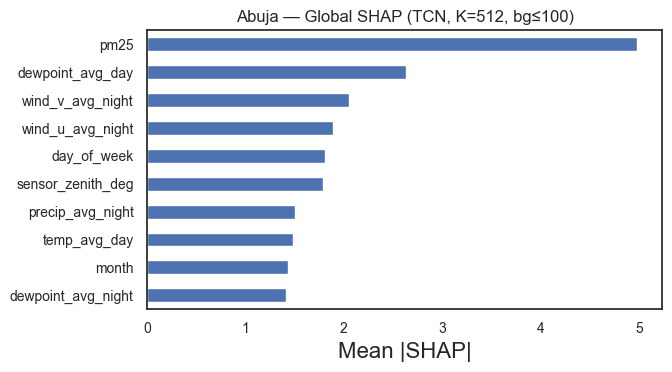

[Abuja] Global SHAP saved -> Datasets\explain\Abuja_TCN_GLOBAL_SHAP_train.csv


PermutationExplainer explainer: 513it [1:20:10,  9.40s/it]                         


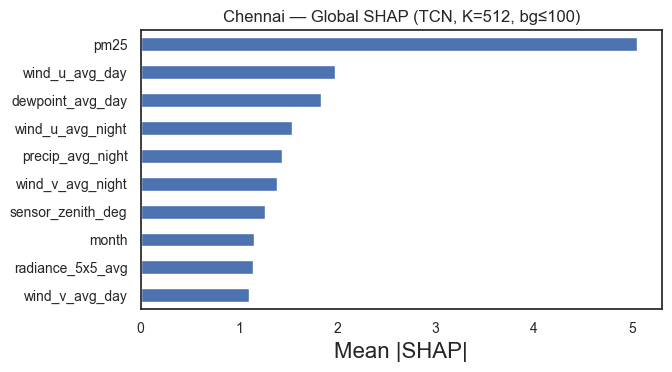

[Chennai] Global SHAP saved -> Datasets\explain\Chennai_TCN_GLOBAL_SHAP_train.csv


PermutationExplainer explainer: 513it [39:27,  4.63s/it]                         


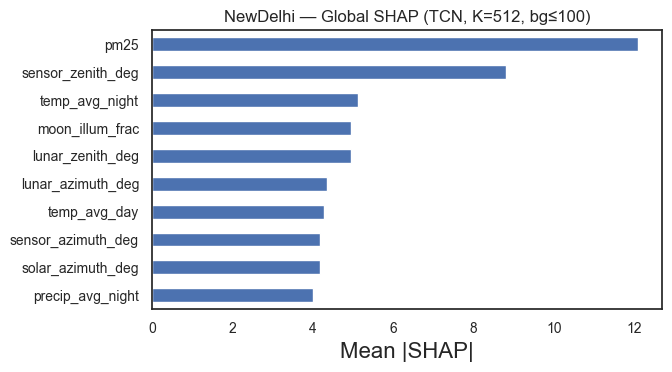

[NewDelhi] Global SHAP saved -> Datasets\explain\NewDelhi_TCN_GLOBAL_SHAP_train.csv


In [35]:
# ========== Global SHAP (TRAIN) for TCN residual models — mean |SHAP| per feature ==========
# where to save
Path("Datasets/explain").mkdir(parents=True, exist_ok=True)


def _plot_top_bar(series, title, top=10, figsize=(7,4), path=None):
    s = series.head(top)[::-1]
    ax = s.plot(kind="barh", figsize=figsize)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Mean |SHAP|")
    plt.tight_layout()
    if path: plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()

def tcn_global_shap_for_city(city, K_samples=512, background_max=100, random_seed=42):
    """
    Compute global importance for TCN by mean|SHAP| over a random subset of K train rows.
    """
    pack   = final_models_tcn_pc[city]
    adap   = pack["adapter_train"]                 # sklearn-like adapter with .model and .x_windows
    X_tr   = city_data_tcn_pc[city]["X_train_2d"]  # (N, D)  last-step features
    feats  = list(X_tr.columns)
    N      = len(X_tr)
    K      = min(K_samples, N)

    rng = np.random.default_rng(random_seed)
    idx = rng.choice(N, size=K, replace=False)

    # fixed subset tensors for SHAP
    base_windows = adap.x_windows[idx]           # (K, L, D)
    prev_vec     = adap.prev_vec[idx]            # (K,)
    X_sample     = X_tr.iloc[idx].reset_index(drop=True)
    y_sample     = city_data_tcn_pc[city]["y_train_seq"].iloc[idx].reset_index(drop=True)

    est  = _SubsetTCNEstimator(adap.model, base_windows, prev_vec)
    name = f"{city}_tcn_globalK{K}"

    # SHAP config: permutation explainer with Partition masker over TRAIN background
    shap_config = {
        "masker": shap.maskers.Partition(X_tr, max_samples=int(background_max), clustering="correlation"),
        "algorithm": "auto"
    }

    # Run SHAP via skexplain for consistency with your workflow
    explainer = skexplain.ExplainToolkit(
        estimators=[(name, est)],
        X=X_sample,
        y=y_sample,
        feature_names=feats
    )
    explanation = explainer.local_attributions(method=["shap"], shap_kws=shap_config)

    # aggregate to global mean |SHAP|
    shap_key = f"shap_values__{name}"
    sv = explanation[shap_key].values            # (K, D)
    g_series = pd.Series(np.abs(sv).mean(axis=0), index=feats).sort_values(ascending=False)

    # save + plot
    out_csv = Path("Datasets/explain") / f"{city}_TCN_GLOBAL_SHAP_train.csv"
    g_series.to_csv(out_csv)
    _plot_top_bar(g_series, title=f"{city} — Global SHAP (TCN, K={K}, bg≤{background_max})", top=10,
                  path=Path("Datasets/explain") / f"{city}_TCN_GLOBAL_SHAP_train_top10.png")
    print(f"[{city}] Global SHAP saved -> {out_csv}")
    return g_series

# ---- run for all TCN per-city models (TRAIN split) ----
tcn_global_shap_train = {}
for city in final_models_tcn_pc.keys():
    tcn_global_shap_train[city] = tcn_global_shap_for_city(
        city,
        K_samples=512,       # increase to 1000+ if you want more stable ranks (slower)
        background_max=100,  # background size for masker; tune for speed/accuracy
        random_seed=42
    )


### Feature Effect Curves

Abuja: ALE for ['pm25', 'dewpoint_avg_day', 'wind_v_avg_night', 'wind_u_avg_night', 'day_of_week', 'sensor_zenith_deg']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


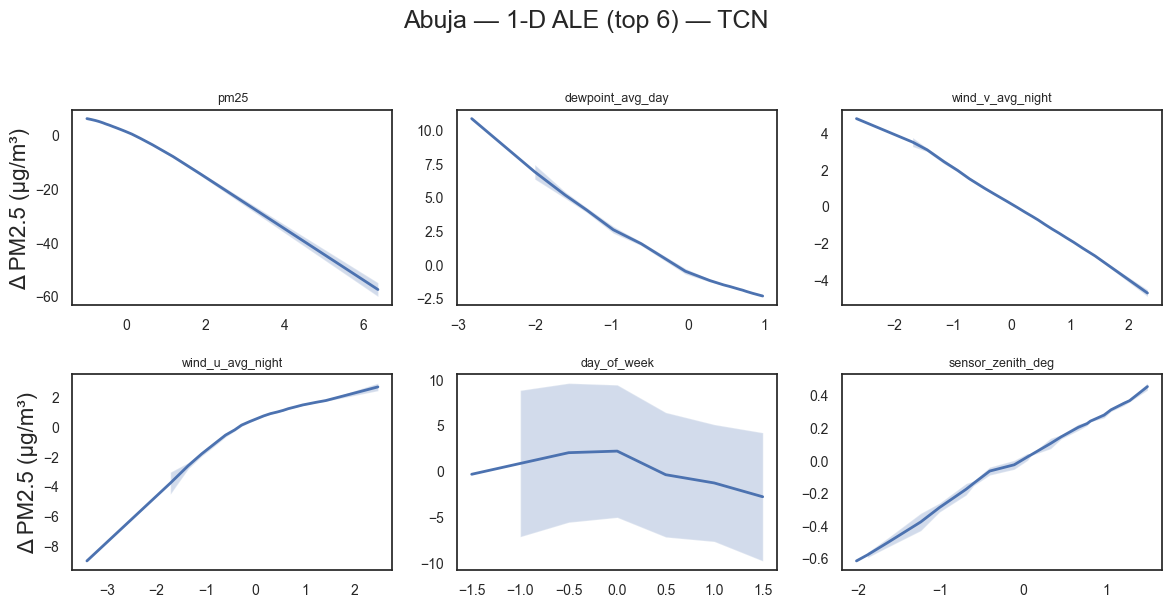

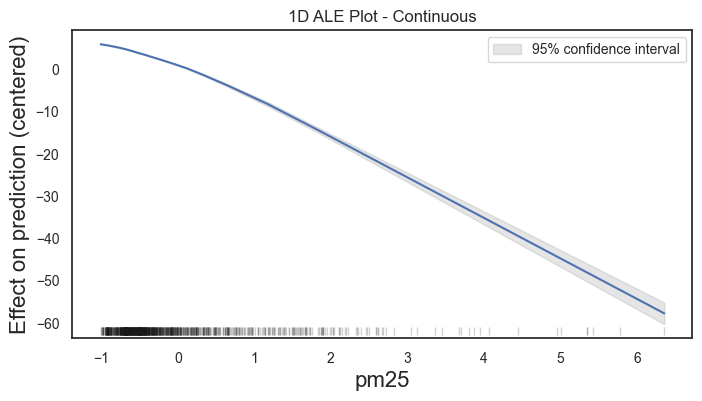

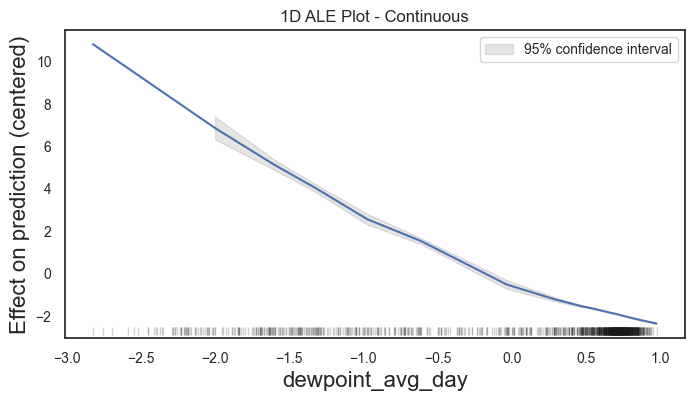

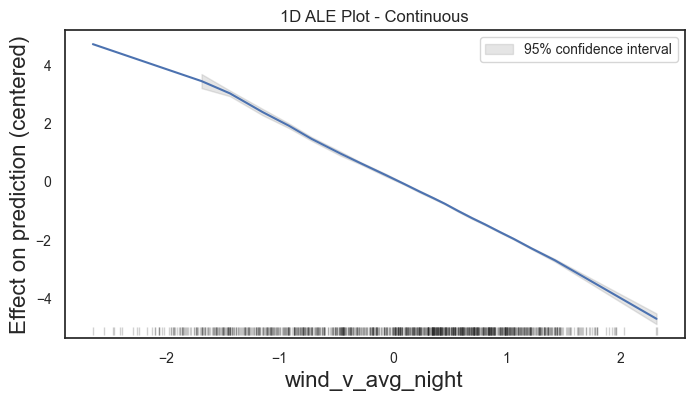

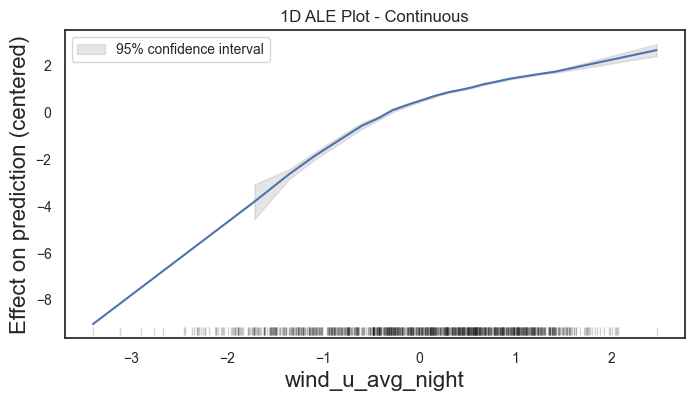

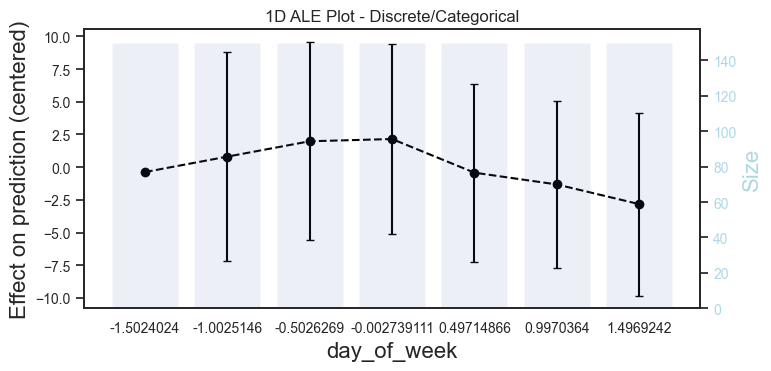

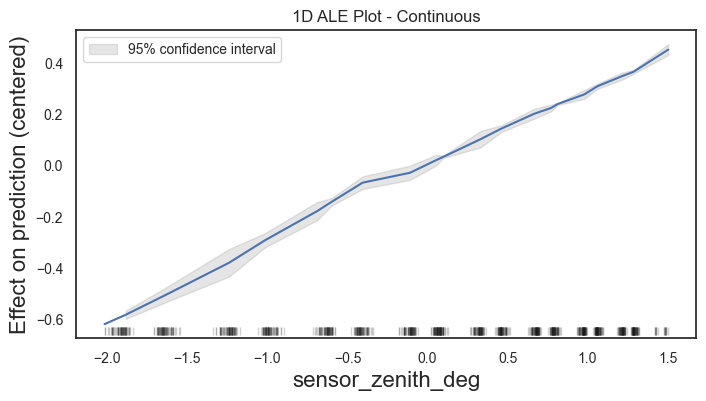

✔ Figures\ALE_TCN_Abuja.png
Chennai: ALE for ['pm25', 'wind_u_avg_day', 'dewpoint_avg_day', 'wind_u_avg_night', 'precip_avg_night', 'wind_v_avg_night']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


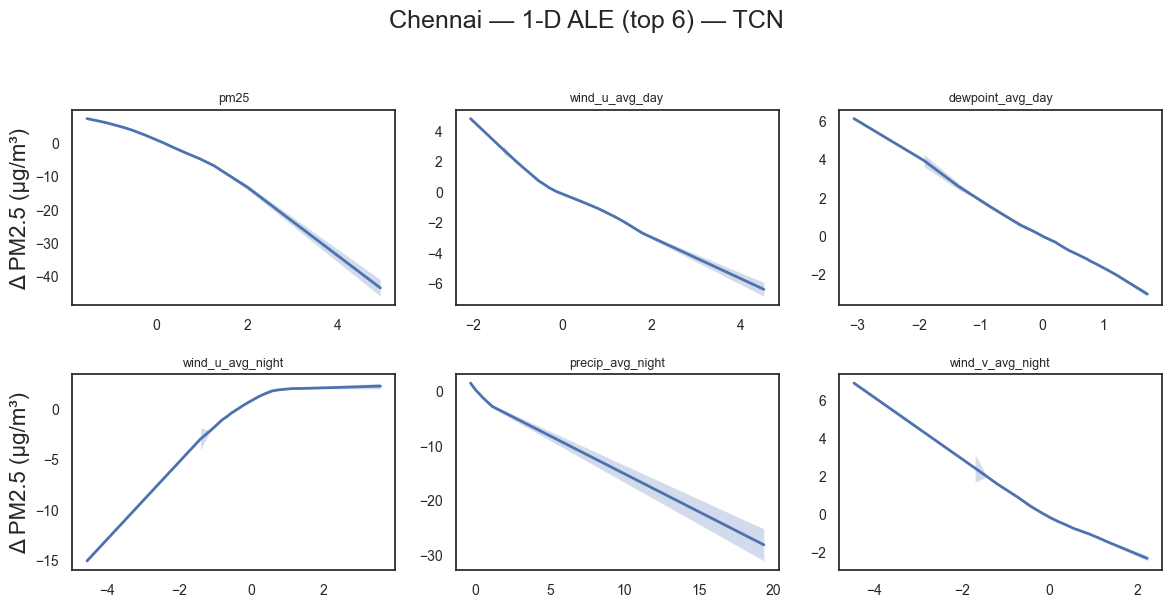

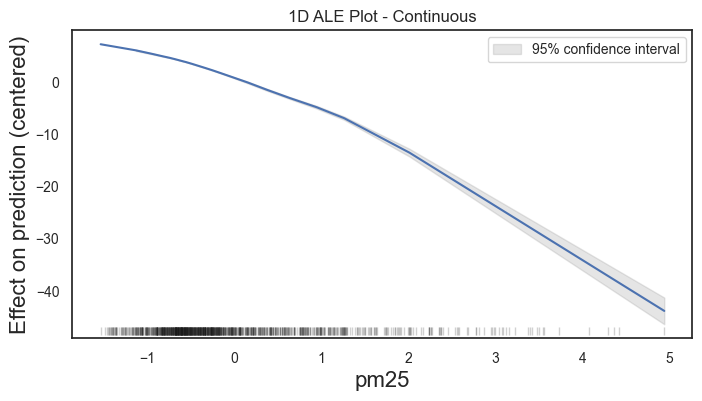

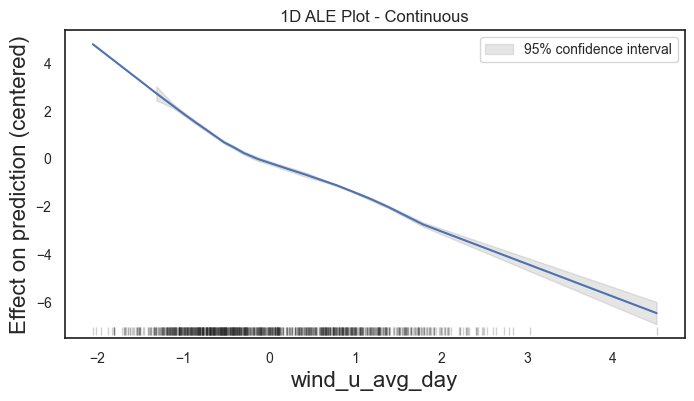

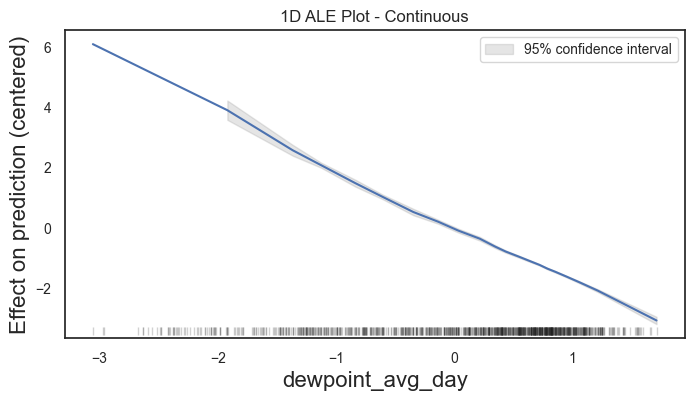

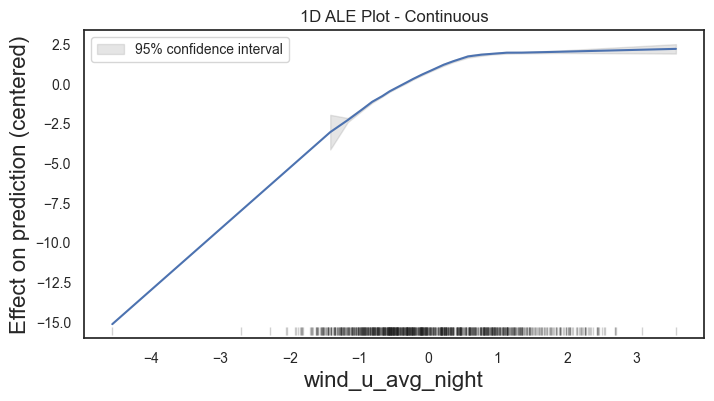

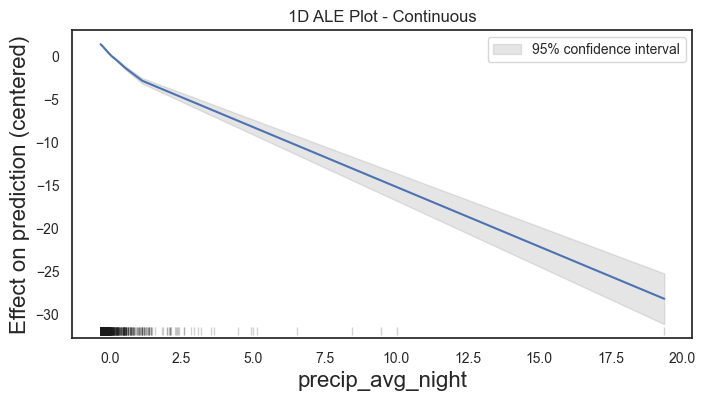

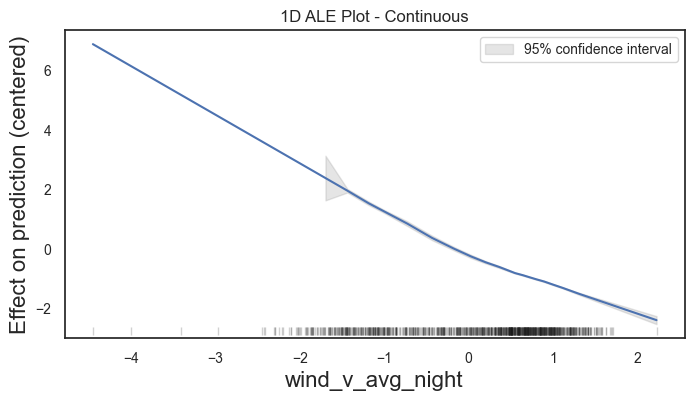

✔ Figures\ALE_TCN_Chennai.png
NewDelhi: ALE for ['pm25', 'sensor_zenith_deg', 'temp_avg_night', 'moon_illum_frac', 'lunar_zenith_deg', 'lunar_azimuth_deg']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


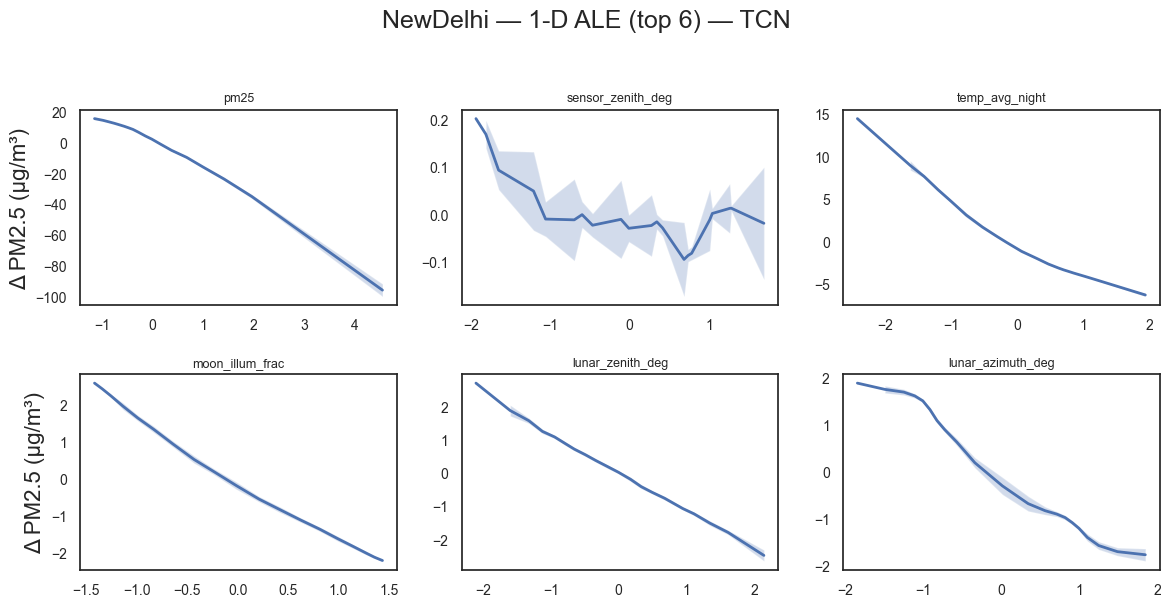

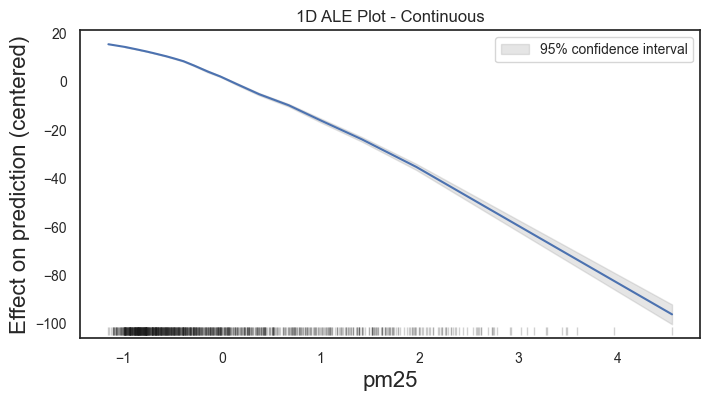

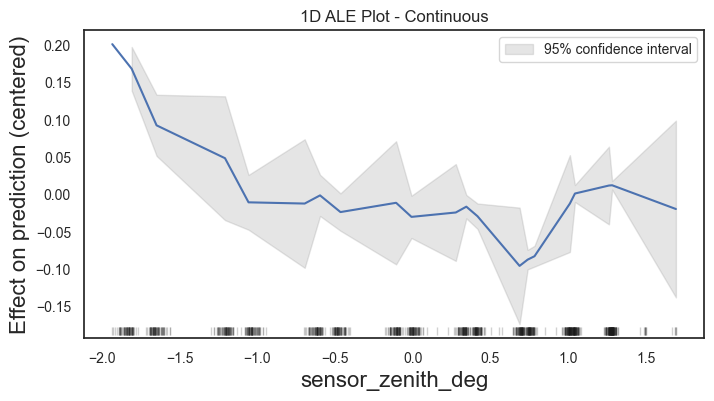

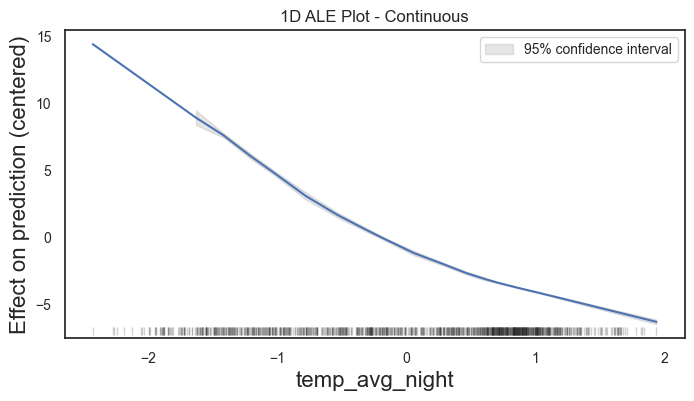

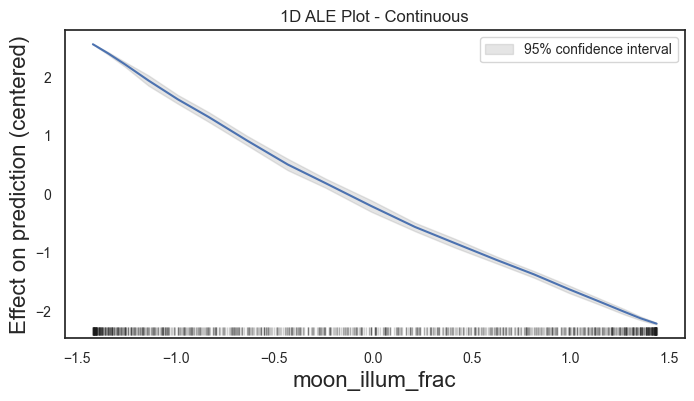

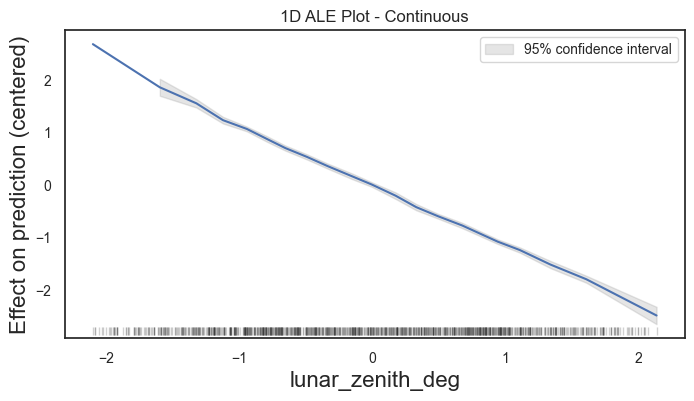

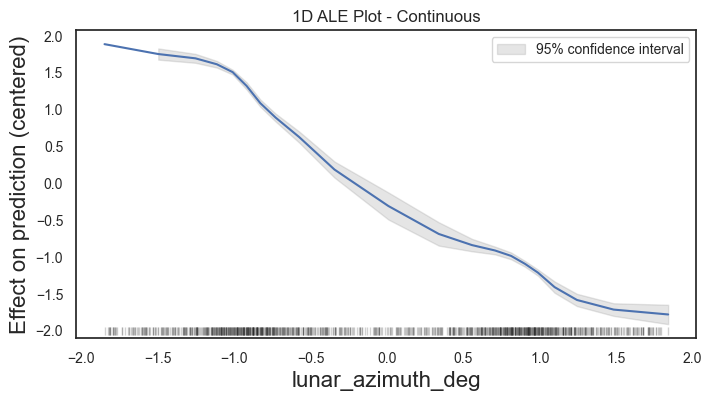

✔ Figures\ALE_TCN_NewDelhi.png


In [37]:
# === 1-D ALE (feature effects) for TCN, mirroring the XGBoost workflow ===
# Uses TRAIN split, top-K features from tcn_global_shap_train[city]

from PyALE import ale

os.makedirs("Figures", exist_ok=True)

class ALEModelTCN:
    """
    Wrapper exposing .predict(X_df) for PyALE.
    Repeats/slices stored windows & prev vector to match arbitrary batch size M.
    """
    def __init__(self, adapter):
        self.model   = adapter.model.eval()
        self.windows = adapter.x_windows.clone()                     # (N, L, D)
        self.prev    = (adapter.prev_vec.detach().cpu().numpy()
                        if isinstance(adapter.prev_vec, torch.Tensor)
                        else np.asarray(adapter.prev_vec, dtype=np.float32))
        self.K = int(self.windows.size(0))
        self.D = int(self.windows.size(-1))

    @torch.no_grad()
    def predict(self, X_df):
        X_np = X_df.to_numpy(dtype=np.float32, copy=False) if hasattr(X_df, "to_numpy") else np.asarray(X_df, dtype=np.float32)
        if X_np.ndim != 2 or X_np.shape[1] != self.D:
            raise ValueError(f"Expected input with D={self.D} features, got {X_np.shape}.")
        M = int(X_np.shape[0])
        K = self.K
        if M == K:
            Xw   = self.windows.clone()
            prev = self.prev
        elif M < K:
            Xw   = self.windows[:M].clone()
            prev = self.prev[:M]
        else:
            reps = math.ceil(M / K)
            Xw   = self.windows.repeat(reps, 1, 1)[:M].clone()
            prev = np.tile(self.prev, reps)[:M]
        Xw[:, -1, :] = torch.from_numpy(X_np)
        r_hat = self.model(Xw).cpu().numpy().reshape(M)
        return prev + r_hat

def plot_ale_tcn(city, adapter_train, X_train_2d, feats, grid=20, save_dir="Figures"):
    wrap = ALEModelTCN(adapter_train)
    r, c = 2, 3
    fig, axes = plt.subplots(r, c, figsize=(c*4, r*3)); axes = axes.ravel()

    for i, (ax, f) in enumerate(zip(axes, feats)):
        res = ale(X_train_2d, wrap, [f], grid_size=grid, include_CI=True, C=0.95)

        # x-axis compatibility across PyALE versions
        x = res.index if getattr(res.index, "name", None) is not None else \
            (res['x_values'] if 'x_values' in res else res.iloc[:, 0])

        y  = res['eff']           if 'eff'           in res else res.get('ALE_effect', res.iloc[:, 1])
        lo = res['lowerCI_95%']   if 'lowerCI_95%'  in res else res.get('ALE_ci_low')
        hi = res['upperCI_95%']   if 'upperCI_95%'  in res else res.get('ALE_ci_high')

        ax.plot(x, y, lw=2)
        if lo is not None and hi is not None:
            ax.fill_between(x, lo, hi, alpha=.25)

        ax.set_title(f, fontsize=9)
        if i % c == 0: ax.set_ylabel("Δ PM2.5 (µg/m³)")
        ax.set_xlabel("")

    for ax in axes[len(feats):]: ax.axis('off')
    fig.suptitle(f"{city} — 1-D ALE (top {len(feats)}) — TCN", y=1.02)
    fig.tight_layout()
    out = os.path.join(save_dir, f"ALE_TCN_{city}.png")
    fig.savefig(out, dpi=250); plt.show()
    print("✔", out)

# ─── drive it (TRAIN split, top-K by global SHAP) ─────────────────────────
TOPK = 6
for city, pack in final_models_tcn_pc.items():
    Xtr   = city_data_tcn_pc[city]["X_train_2d"]
    feats = list(tcn_global_shap_train[city].head(TOPK).index)
    print(f"{city}: ALE for {feats}")
    plot_ale_tcn(city, adapter_train=pack["adapter_train"], X_train_2d=Xtr, feats=feats)
